In [21]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from sklearn.model_selection import ParameterGrid

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 12})

In [22]:
# 下载股票数据
def load_stock_data(stock_symbol):
    df = yf.download(stock_symbol, period="5y")
    df['Stock Symbol'] = stock_symbol
    return df

In [23]:
# 本金定义
principle = 100000

# 读取股票代码
stocks_df = pd.read_excel('Stocks.xlsx',sheet_name = 'Watchlist')
stock_symbols = stocks_df['Stock Symbol'].tolist()
stock_names = stocks_df['Stock Name'].tolist()
stock_industry = stocks_df['Industry'].tolist()
stock_names_dic = stocks_df.set_index('Stock Symbol')['Stock Name'].to_dict()
all_stock_data = {symbol: load_stock_data(symbol) for symbol in stock_symbols}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [24]:
# 计算股票的波动率和换手率
def calculate_volatility(stock_data):
    return stock_data['Close'].pct_change().std()

volatility_dict = {symbol: calculate_volatility(df) for symbol, df in all_stock_data.items()}

# 将股票按波动率进行分类
def categorize_volatility(volatility):
    if volatility < 0.025:
        return 'Low'
    elif volatility <= 0.030:
        return 'Medium'
    else:
        return 'High'

volatility_category_dict = {symbol: categorize_volatility(vol) for symbol, vol in volatility_dict.items()}

In [25]:
# 计算技术指标和衍生特征
def add_technical_indicators(df_stock, stock_symbol):
    scaler = MinMaxScaler()
    df_stock = df_stock.replace(0, method='ffill')
    df_stock['Close_scaled'] = scaler.fit_transform(df_stock[['Close']])
    df_stock['Returns'] = df_stock['Close'].pct_change()
    df_stock['Historical Volatility'] = df_stock['Returns'].rolling(window=7).std()
    df_stock['Volume Volatility'] = df_stock['Volume'].pct_change().rolling(window=10).std()
    
    ticker = yf.Ticker(stock_symbol)
    info = ticker.info
    shares_outstanding = info['sharesOutstanding']
    df_stock['Turnover Rate'] = df_stock['Volume'] / shares_outstanding

    df_stock['Volatility'] = df_stock['Returns'].rolling(window=10).std()
    df_stock = df_stock.dropna()
    return df_stock

# 创建自定义损失函数
def custom_loss_function(volatility_window, turnover_window, original_data):
    data = original_data.copy()
    # 计算volatility和turnover
    data['Vol'] = data['Returns'].rolling(window=volatility_window).std()
    data['Turnover'] = data['Turnover Rate'].rolling(window=turnover_window).mean()
    data = data.dropna()
    
    data['BullBearIndex'] = data['Vol'] / data['Turnover']
    scaler = MinMaxScaler()
    data['BullBearIndex_scaled'] = scaler.fit_transform(data[['BullBearIndex']])
    
    correlation = data[['BullBearIndex_scaled', 'Close_scaled']].corr().iloc[0, 1]
    
    # 返回相关性，因为我们想最大化负相关性
    return correlation

# 创建输入
def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data)-time_step-5):
        X.append(data[i:(i+time_step)])
        Y.append(data[i + time_step:i + time_step + 1, 2])  # 预测未来1天的波动率
    return np.array(X), np.array(Y)

# 数据标准化
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

In [26]:
# 计算指标
def calculate_sma_signal(data, short_window, long_window, index):
    sma_short = data.rolling(window=short_window).mean()
    sma_long = data.rolling(window=long_window).mean()
    buy_signal = sma_short.iloc[index] > sma_long.iloc[index]
    sell_signal = sma_short.iloc[index] < sma_long.iloc[index]
    return buy_signal, sell_signal

def calculate_rsi_signal(data, window, index):
    low_threshold=30
    high_threshold=70
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    buy_signal = rsi.iloc[index] < low_threshold
    sell_signal = rsi.iloc[index] > high_threshold
    return buy_signal, sell_signal

def calculate_macd_signal(data, index):
    slow = 26
    fast = 12
    signal = 9
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    buy_signal = macd.iloc[index] > signal_line.iloc[index]
    sell_signal = macd.iloc[index] < signal_line.iloc[index]
    return buy_signal, sell_signal

def true_range(high, low, close):
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - prev_close)
    tr3 = abs(low - prev_close)
    true_range = pd.DataFrame({'TR1': tr1, 'TR2': tr2, 'TR3': tr3}).max(axis=1)
    return true_range

def calculate_adx_signal(high, low, close):
    window=7
    threshold=25
    # 确保 high, low, close 是 pandas Series
    high_series = pd.Series(high)
    low_series = pd.Series(low)
    close_series = pd.Series(close)
    
    df = pd.DataFrame({'High': high_series, 'Low': low_series, 'Close': close_series})

    # 计算真实波幅 (True Range, TR)
    df['TR'] = true_range(df['High'], df['Low'], df['Close'])
    
    # 计算方向性运动 (+DM 和 -DM)
    df['+DM'] = df['High'].diff().apply(lambda x: x if x > 0 else 0)
    df['-DM'] = df['Low'].diff().apply(lambda x: -x if x < 0 else 0)
    
    # 计算平滑的方向性指标 (+DI 和 -DI)
    df['+DI'] = 100 * (df['+DM'].ewm(alpha=1/window, min_periods=window).mean() / df['TR'].ewm(alpha=1/window, min_periods=window).mean())
    df['-DI'] = 100 * (df['-DM'].ewm(alpha=1/window, min_periods=window).mean() / df['TR'].ewm(alpha=1/window, min_periods=window).mean())
    
    # 计算方向性运动指数 (DX)
    df['DX'] = 100 * abs((df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])).fillna(0)
    
    # 计算平均方向性指数 (ADX)
    df['ADX'] = df['DX'].ewm(alpha=1/window, min_periods=window).mean()
    
    # 获取当前时间点的买入和卖出信号
    # buy_signal = (df['ADX'].iloc[index] > threshold) & (df['+DI'].iloc[index] > df['-DI'].iloc[index])
    # sell_signal = (df['ADX'].iloc[index] > threshold) & (df['+DI'].iloc[index] < df['-DI'].iloc[index])
    
    adx_signal = (df['ADX'] > threshold)
    
    adx_signal = np.where(df['ADX'] > threshold, 
                                np.where(df['+DI'] > df['-DI'], 'up', 'down'), 
                                'none')
    return adx_signal

# 布林带指标
def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

# 牛熊市判断指标
def calculate_market_state(bull_bear_index, adx_signal, BBI_lower, BBI_upper):
    if bull_bear_index < BBI_lower and adx_signal == 'up':
        return 'bull'
    elif bull_bear_index > BBI_upper and adx_signal == 'down':
        return 'bear'
    else:
        return 'neutral'

In [27]:
# 可视化交易策略
def plot_trading_strategy(test_volatility, df, length, buy_dates, sell_dates, position_list, title):
    trade_df = df[-length:]
    test_dates  = trade_df.index
    
    # 计算 ADX 信号
    adx_signal = calculate_adx_signal(trade_df['High'], trade_df['Low'], trade_df['Close'])
    
    # fig, ax1 = plt.subplots(figsize=(10, 5))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 绘制股价在ax1
    color = 'tab:blue'
    
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df.index[-length:], df['Close'][-length:], label='Close Price', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # # 添加 BullBearIndex_scaled
    # color = 'tab:red'
    # ax1.plot(df.index[-length:], df['BullBearIndex_scaled'][-length:], label='BullBear Index', color=color)
    # ax1.tick_params(axis='y', labelcolor=color)
    
    # 添加买卖点在ax1
    for date in buy_dates:
        ax1.axvline(x=date, color='g', linestyle='--', lw=0.8)
    for date in sell_dates:
        ax1.axvline(x=date, color='r', linestyle='--', lw=0.8)
        
    # 箭头图
    # 将buy_dates列表转换为数据框
    buy_dates_df = pd.DataFrame({'Date': pd.to_datetime(buy_dates)})
    sell_dates_df = pd.DataFrame({'Date': pd.to_datetime(sell_dates)})
    
    stock_data_reset = df.reset_index()
    
    buy_prices = pd.merge(buy_dates_df, stock_data_reset[['Date', 'Close']], how='left', on='Date')
    buy_prices.rename(columns={'Close': 'Buy Price'}, inplace=True)
    
    sell_prices = pd.merge(sell_dates_df, stock_data_reset[['Date', 'Close']], how='left', on='Date')
    sell_prices.rename(columns={'Close': 'Sell Price'}, inplace=True)
        
    ax1.scatter(buy_prices['Date'],buy_prices['Buy Price'], marker='^', color='g', label='Buy Signal', s=30, alpha=0.7)
    ax1.scatter(sell_prices['Date'], sell_prices['Sell Price'], marker='v', color='r', label='Sell Signal', s=30, alpha=0.7)
    
    # 添加 ADX 信号的色块在ax1
    for i in range(len(test_dates) - 1):
        if adx_signal[i] == 'up':
            ax1.axvspan(test_dates[i], test_dates[i + 1], color='green', alpha=0.1)
        elif adx_signal[i] == 'down':
            ax1.axvspan(test_dates[i], test_dates[i + 1], color='red', alpha=0.1)
    
    # 创建第二个纵轴用于绘制波动率
    ax1b = ax1.twinx()
    color = 'tab:orange'
    ax1b.set_ylabel('Volatility', color=color)
    
    # 改变波动率线的显示方式
    ax1b.plot(np.array(test_dates), np.array(test_volatility), label='Volatility', color=color, linestyle='--', linewidth=1)
    ax1b.tick_params(axis='y', labelcolor=color)
    
    # 设置不同的Y轴范围
    ax1.set_ylim([df['Close'][-length:].min() * 0.9, df['Close'][-length:].max() * 1.1])
    ax1b.set_ylim([test_volatility.min() * 0.9, test_volatility.max() * 5])
    
    # 持仓数量
    color = 'tab:green'
    ax2.set_ylabel('Position', color=color)
    ax2.plot(np.array(test_dates), np.array(position_list), label='Position', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 绘制买卖点在 ax2
    ax2.scatter(buy_prices['Date'], buy_prices['Buy Price'], marker='^', color='g', label='Buy Signal', s=30, alpha=0.7)
    ax2.scatter(sell_prices['Date'], sell_prices['Sell Price'], marker='v', color='r', label='Sell Signal', s=30, alpha=0.7)
    
    # 添加图例
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(title)
    plt.show()
    
# 评估函数
def evaluate_strategy(df, length, pnl, buy_dates, sell_dates, principle):
    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    
    # 计算最终资产价值
    final_balance = pnl[-1]

    # 计算年化回报率
    num_years = (test_dates[-1] - test_dates[0]).days / 365.0
    annualized_return = ((final_balance / principle) ** (1 / num_years)) - 1

    # 计算每日收益率
    daily_returns = pd.Series(pnl).pct_change().dropna()

    # 计算夏普比率
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

    # 计算最大回撤
    cumulative_returns = pd.Series(pnl).pct_change().dropna().cumsum()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()

    # 计算换手率
    turnover_rate = (len(buy_dates) + len(sell_dates)) / len(test_dates)

    # 计算买入次数和卖出次数
    num_buys = len(buy_dates)
    num_sells = len(sell_dates)
    
    # 计算胜率
    wins = 0
    test_dates_index = pd.Index(test_dates)
    for buy_date in buy_dates:
        buy_index = test_dates_index.get_loc(buy_date)
        sell_date = next((date for date in sell_dates if test_dates_index.get_loc(date) > buy_index), None)
        if sell_date:
            sell_index = test_dates_index.get_loc(sell_date)
            if test_prices[sell_index] > test_prices[buy_index]:
                wins += 1

    total_trades = num_buys
    win_rate = wins / total_trades if total_trades > 0 else 0


    # 输出结果
    results = {
        'Final Balance': final_balance,
        'Annualized Return': (annualized_return * 100).round(2),
        'Sharpe Ratio': (sharpe_ratio).round(2),
        'Max Drawdown': round(max_drawdown * 100, 2),
        'Win Rate': round(win_rate * 100, 2),
        'Turnover Rate': round(turnover_rate, 2),
        'Long Count': num_buys,
        'Short Count': num_sells
    }
    
    results_df = pd.DataFrame([results])
    
    return results_df

In [28]:
# 表格分组和格式化
def display_results(final_results_df):
    grouped = final_results_df.groupby(['Stock Symbol','Stock Name', 'Volatility Category','Industry', 'Strategy']).agg(
        {'Annualized Return': 'mean', 'Sharpe Ratio': 'mean', 'Max Drawdown': 'mean', 'Win Rate': 'mean',
         'Turnover Rate': 'mean', 'Long Count': 'sum', 'Short Count': 'sum'})
    
    # 对关键指标进行颜色编码
    styled = grouped.style.background_gradient(cmap='RdYlGn', subset=['Annualized Return'])
    styled = styled.background_gradient(cmap='RdYlGn', subset=['Sharpe Ratio'])
    styled = styled.background_gradient(cmap='RdYlGn', subset=['Max Drawdown'])
    styled = styled.background_gradient(cmap='RdYlGn', subset=['Win Rate'])
    styled = styled.background_gradient(cmap='RdYlGn', subset=['Turnover Rate'])
    
    # 显示表格
    display(styled)

In [29]:
# 重新排列输出表格的列
def results(final_results_df):
    # 计算每个股票代码的两个策略的平均 Final Balance
    average_final_balance = final_results_df.groupby('Stock Symbol')['Final Balance'].mean()
    
    # 按照平均 Final Balance 排序
    average_final_balance = average_final_balance.sort_values(ascending=False)

    # 设置股票代码为索引并调整列顺序
    final_results_df.set_index('Stock Symbol', inplace=True, drop=False)
    final_results_df = final_results_df.loc[average_final_balance.index]
    
    columns = ['Stock Name', 'Industry', 'Strategy', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate', 'Turnover Rate','Long Count', 'Short Count']
    final_results_df = final_results_df[columns]
    
    return final_results_df

In [30]:
# 可视化结果
def visualize_strategy_performance_by_volatility(grouped_by_volatility):
    grouped_reset = grouped_by_volatility.reset_index()

    # 创建图表展示年化收益率
    plt.figure()
    sns.barplot(x='Volatility Category', y='Annualized Return', hue='Strategy', data=grouped_reset)
    plt.title('Annualized Return by Volatility Category and Strategy')
    plt.xlabel('Volatility Category')
    plt.ylabel('Annualized Return (%)')
    plt.legend(title='Strategy')
    plt.tight_layout()
    plt.show()

    # 创建图表展示夏普比率
    plt.figure()
    sns.barplot(x='Volatility Category', y='Sharpe Ratio', hue='Strategy', data=grouped_reset)
    plt.title('Sharpe Ratio by Volatility Category and Strategy')
    plt.xlabel('Volatility Category')
    plt.ylabel('Sharpe Ratio')
    plt.legend(title='Strategy')
    plt.tight_layout()
    plt.show()

    # 创建图表展示最大回撤
    plt.figure()
    sns.barplot(x='Volatility Category', y='Max Drawdown', hue='Strategy', data=grouped_reset)
    plt.title('Max Drawdown by Volatility Category and Strategy')
    plt.xlabel('Volatility Category')
    plt.ylabel('Max Drawdown')
    plt.legend(title='Strategy')
    plt.tight_layout()
    plt.show()
    
    # 胜率
    plt.figure()
    sns.barplot(x='Volatility Category', y='Win Rate', hue='Strategy', data=grouped_reset)
    plt.title('Win Rate by Volatility Category and Strategy')
    plt.xlabel('Volatility Category')
    plt.ylabel('Turnover Rate')
    plt.legend(title='Strategy')
    plt.tight_layout()
    plt.show()
    
    # 创建图表展示换手率
    plt.figure()
    sns.barplot(x='Volatility Category', y='Turnover Rate', hue='Strategy', data=grouped_reset)
    plt.title('Turnover Rate by Volatility Category and Strategy')
    plt.xlabel('Volatility Category')
    plt.ylabel('Turnover Rate')
    plt.legend(title='Strategy')
    plt.tight_layout()
    plt.show()

In [31]:
# V1 动量交易策略
def momentum_v1_strategy(test_volatility, df, length, principle):
    short_window = 6
    trend_window = 12
    
    balance = principle
    position = 0  # 当前持有股票数量
    buy_dates = []
    sell_dates = []
    pnl = []
    
    trade_amount = principle * 0.20
    
    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    high = df['High'].values[-length:]
    low  = df['Low'].values[-length:]
    
    # 将 test_prices 转换为 pandas Series
    test_prices_series = pd.Series(test_prices)
    high_series = pd.Series(high)
    low_series = pd.Series(low)
    close_series = test_prices_series
    
    # 填充前面部分的 pnl，使其与 test_dates 长度一致
    pnl = [balance] * (trend_window -1)
    position_list = [0] * (trend_window - 1)
    
    adx_signal = calculate_adx_signal(high=high_series, low=low_series, close=close_series)
    
    for i in range(trend_window, len(test_volatility)):
        if adx_signal[i] == 'none':
            window = trend_window
        else:
            window = short_window
            
        current_volatility = test_volatility[i]
        current_window = test_prices[i-window:i]
        support_level = np.percentile(current_window, 35)
        resistance_level = np.percentile(current_window, 65)
        
        low_vol_threshold = np.percentile(test_volatility[i-window:i], 35)
        high_vol_threshold = np.percentile(test_volatility[i-window:i], 65)
        
        buy_rsi, sell_rsi = calculate_rsi_signal(test_prices_series, window, index=i)
    
        buy_signal = (current_volatility < low_vol_threshold) and (buy_rsi or test_prices[i] <= support_level)
        sell_signal = (current_volatility > high_vol_threshold) and (sell_rsi or test_prices[i] >= resistance_level)
        
        if buy_signal and balance >= test_prices[i] * 100:
            shares_to_buy = int(trade_amount // (test_prices[i] * 100)) * 100
            if shares_to_buy > 0:
                position += shares_to_buy
                balance -= shares_to_buy * test_prices[i]
                buy_dates.append(test_dates[i])

        elif sell_signal and position >= 100:
            # 如果初始资金的25%小于一手的价格，但持仓大于等于一手，我们卖出一手
            if trade_amount < test_prices[i] * 100:
                shares_to_sell = 100
            else:
                shares_to_sell = int(trade_amount // (test_prices[i] * 100)) * 100
            if shares_to_sell > 0 and shares_to_sell <= position:
                balance += shares_to_sell * test_prices[i]
                position -= shares_to_sell
                sell_dates.append(test_dates[i])

        # 记录每天的资产价值
        total_value = balance + position * test_prices[i]
        pnl.append(total_value)
        position_list.append(position)
    # 计算最终资产价值
    final_balance = balance + (position * test_prices[-1])
    pnl.append(final_balance)
    position_list.append(position)
    return pnl, buy_dates, sell_dates, position_list

In [32]:
# V2 动量交易策略
def momentum_v2_strategy(test_volatility, df, length, principle, short_window, trend_window):
    balance = principle
    position = 0  # 当前持有股票数量
    buy_dates = []
    sell_dates = []
    pnl = []
    
    # 设置止损
    buy_price = 0  # 记录买入价格
    buy_costs = []  # 记录每次买入的成本
    vol_percentage = 35

    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    high = df['High'].values[-length:]
    low  = df['Low'].values[-length:]
    bullbear = df["BullBearIndex_scaled"].values[-length:]
    
    # 将 test_prices 转换为 pandas Series
    test_prices_series = pd.Series(test_prices)
    high_series = pd.Series(high)
    low_series = pd.Series(low)
    close_series = test_prices_series
    
    # 填充前面部分的 pnl，使其与 test_dates 长度一致
    pnl = [balance] * (trend_window -1)
    position_list = [0] * (trend_window - 1)
    
    adx_signal = calculate_adx_signal(high_series, low_series, close_series)
    BBI_lower = np.percentile(df['BullBearIndex_scaled'], 25)
    BBI_upper = np.percentile(df['BullBearIndex_scaled'], 75)
    
    for i in range(trend_window, len(test_volatility)):
        
        current_volatility = test_volatility[i]
        current_bullbear = bullbear[i]
        
        market_state = calculate_market_state(current_bullbear, adx_signal[i], BBI_lower, BBI_upper)

        if adx_signal[i] == 'up':  # 强劲趋势
            window = short_window
            trade_amount = principle * 0.2  # 增加持仓比例
            support = 40
            resistance = 70
            vol_percentage = 45
        elif adx_signal[i] == 'down':  # 弱趋势或震荡市场
            window = short_window
            trade_amount = principle * 0.1  # 减少持仓比例
            support = 5
            resistance = 90
        else:
            window = trend_window
            trade_amount = principle * 0.15  # 默认持仓比例
            support = 35
            resistance = 65
            
        
        # if market_state == 'bull':  # 强劲趋势
        #     window = trend_window
        #     trade_amount = principle * 0.2  # 增加持仓比例
        #     support = 30
        #     resistance = 70
        #     vol_percentage = 45
        # elif market_state == 'bear':  # 弱趋势或震荡市场
        #     window = short_window
        #     trade_amount = principle * 0.05  # 减少持仓比例
        #     support = 5
        #     resistance = 90
        # else:
        #     window = short_window
        #     trade_amount = principle * 0.15  # 默认持仓比例
        #     support = 35
        #     resistance = 65
            
        current_window = test_prices[i-window:i]
        support_level = np.percentile(current_window, support)
        resistance_level = np.percentile(current_window, resistance)
            
        low_vol_threshold = np.percentile(test_volatility[i-window:i], vol_percentage)
        high_vol_threshold = np.percentile(test_volatility[i-window:i], 100 - vol_percentage)
        
        buy_rsi, sell_rsi = calculate_rsi_signal(test_prices_series, 14, i)

    
        # buy_signal = (current_volatility < low_vol_threshold) and ( buy_rsi or test_prices[i] <= support_level)
        if adx_signal[i] == 'up':
            buy_signal = (current_volatility < low_vol_threshold)
        elif adx_signal[i] == 'down':
            buy_signal = (current_volatility < low_vol_threshold) and (test_prices[i] <= support_level)
            # buy_signal = (current_volatility < low_vol_threshold)
        else:
            buy_signal = (current_volatility < low_vol_threshold) and ( buy_rsi or test_prices[i] <= support_level)
        sell_signal = (current_volatility > high_vol_threshold) and (sell_rsi or test_prices[i] >= resistance_level)
    
        # 添加止损机制
        total_cost = sum(buy_costs)
        if position > 0 and (test_prices[i] * position < total_cost * 0.9):
            sell_signal = True
        if position > 0 and (test_prices[i] * position < total_cost * 1.3):
            sell_signal = True
            
        if buy_signal and balance >= test_prices[i] * 100:
            shares_to_buy = int(trade_amount // (test_prices[i] * 100)) * 100
            if shares_to_buy > 0:
                position += shares_to_buy
                balance -= shares_to_buy * test_prices[i]
                buy_dates.append(test_dates[i])
                buy_costs.append(shares_to_buy * test_prices[i])  # 记录每次买入的成本

        elif sell_signal and position >= 100:
            # 如果初始资金的25%小于一手的价格，但持仓大于等于一手，我们卖出一手
            if trade_amount < test_prices[i] * 100:
                shares_to_sell = 100
            else:
                shares_to_sell = int(trade_amount // (test_prices[i] * 100)) * 100
            if shares_to_sell > 0 and shares_to_sell <= position:
                balance += shares_to_sell * test_prices[i]
                position -= shares_to_sell
                sell_dates.append(test_dates[i])
                
                # 移除对应数量的买入成本
                sell_cost = shares_to_sell * test_prices[i]
                while sell_cost > 0 and buy_costs:
                    if buy_costs[0] <= sell_cost:
                        sell_cost -= buy_costs.pop(0)
                    else:
                        buy_costs[0] -= sell_cost
                        sell_cost = 0
                

        # 记录每天的资产价值
        total_value = balance + position * test_prices[i]
        pnl.append(total_value)
        position_list.append(position)
        
    # 计算最终资产价值
    final_balance = balance + (position * test_prices[-1])
    pnl.append(final_balance)
    position_list.append(position)
    # plot_trading_strategy(test_volatility, df, length, buy_dates, sell_dates, 'Revision')

    return pnl, buy_dates, sell_dates, position_list

In [33]:
def buy_and_hold_strategy(df, length, principle):
    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    
    buy_dates = []
    sell_dates = []
    sell_dates.append(test_dates[-1])
    buy_dates.append(test_dates[0])
    buy_price = test_prices[0]
    sell_price = test_prices[-1]
    
    position = principle / buy_price
    final_balance = position * sell_price
    
    # 计算PnL曲线
    pnl = principle * (test_prices / buy_price)
    
    return pnl, buy_dates, sell_dates

In [34]:
def annual_performance(pnl, test_dates, buy_dates, sell_dates, principle):
    test_dates = pd.to_datetime(test_dates)
    years = test_dates.year.unique()
    results = []

    for year in years:
        year_mask = (test_dates.year == year)
        year_dates = test_dates[year_mask]
        year_pnl = np.array(pnl)[year_mask]
        year_buy_dates = [date for date in buy_dates if pd.DatetimeIndex([date]).year[0] == year]
        year_sell_dates = [date for date in sell_dates if pd.DatetimeIndex([date]).year[0] == year]
        year_test_dates = test_dates[year_mask]

        if len(year_pnl) < 2:
            continue

        annual_return = ((year_pnl[-1] / principle) ** (1 / len(years))) - 1
        daily_returns = pd.Series(year_pnl).pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
        cumulative_returns = pd.Series(year_pnl).pct_change().dropna().cumsum()
        running_max = cumulative_returns.cummax()
        drawdown = running_max - cumulative_returns
        max_drawdown = drawdown.max()
        
        # win_rate = len([date for date in year_sell_dates if pd.DatetimeIndex([date]).year[0] == year]) / max(len(year_buy_dates), 1)
        turnover_rate = (len(year_buy_dates) + len(year_sell_dates)) / len(year_test_dates)
        long_count = len(year_buy_dates)
        short_count = len(year_sell_dates)

        results.append({
            'Year': year,
            'Annualized Return': (annual_return * 100).round(2),
            'Sharpe Ratio': (sharpe_ratio).round(2),
            'Max Drawdown': round(max_drawdown * 100, 2),
        })

    results_df = pd.DataFrame(results)
    return results_df


In [35]:
# 参数优化模块
from sklearn.model_selection import ParameterGrid

def optimize_strategy(test_volatility, df, length, principle):
    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    
    best_params = None
    best_performance = -np.inf

    # Define the parameter grid
    param_grid = {
        'short_window': [3, 5, 7],
        'trend_window': [10, 12, 15, 20],
        'support': [25, 30, 35],
        'resistance': [55, 65, 75],
        'vol_percentile': [35,40]
    }

    # Iterate over all combinations of parameters
    for params in ParameterGrid(param_grid):
        pnl, buy_dates, sell_dates = momentum_v2_strategy(
            test_volatility, df, length, principle,
            params['short_window'], params['trend_window'],
            params['support'], params['resistance'],
            params['vol_percentile']
        )

        # Evaluate the performance of the strategy
        performance = evaluate_performance(pnl)

        # Update the best parameters if the current performance is better
        if performance > best_performance:
            best_performance = performance
            best_params = params

    return best_params, best_performance

def evaluate_performance(pnl):
    # Calculate metrics to evaluate the performance of the strategy
    annualized_return = (pnl[-1] / pnl[0]) ** (252 / len(pnl)) - 1
    daily_returns = pd.Series(pnl).pct_change().dropna()
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
    
    # Combine multiple metrics into a single performance score
    performance_score = annualized_return * sharpe_ratio  # You can customize this

    return performance_score


[*********************100%%**********************]  1 of 1 completed

Processing 002299.SZ (圣农发展)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 27}
Best score:  -0.3646200085144927
Final Balance: [95094.00177002]  
 Annualized Return: [-13.46] 
 Max Drawdown: [8.38]


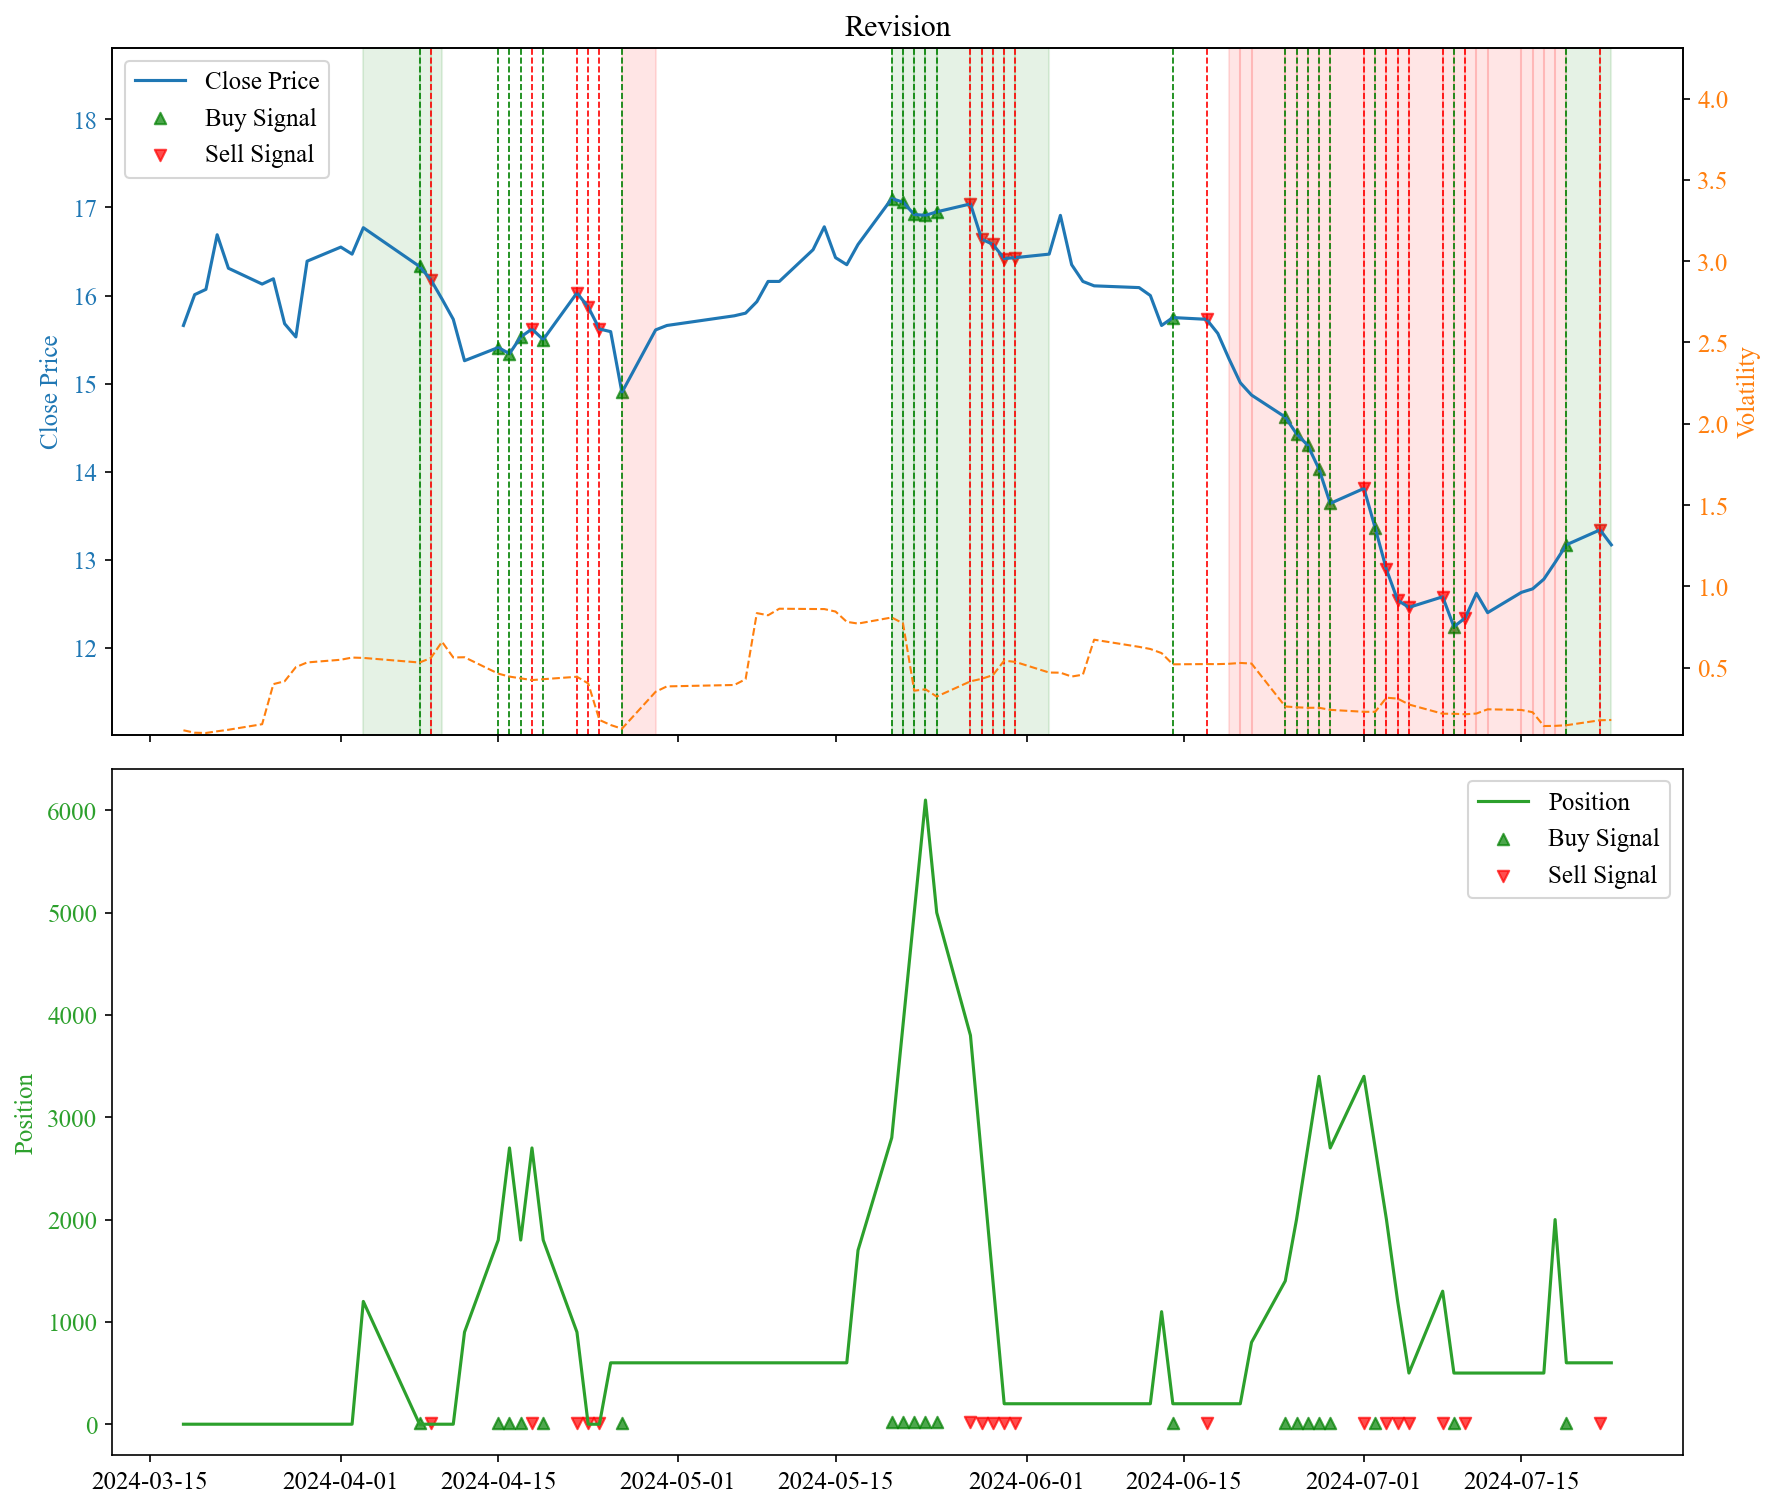

[*********************100%%**********************]  1 of 1 completed

Processing 600938.SS (中国海油)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 27}
Best score:  -0.10533843702157376
Final Balance: [100926.00040436]  
 Annualized Return: [2.68] 
 Max Drawdown: [12.09]


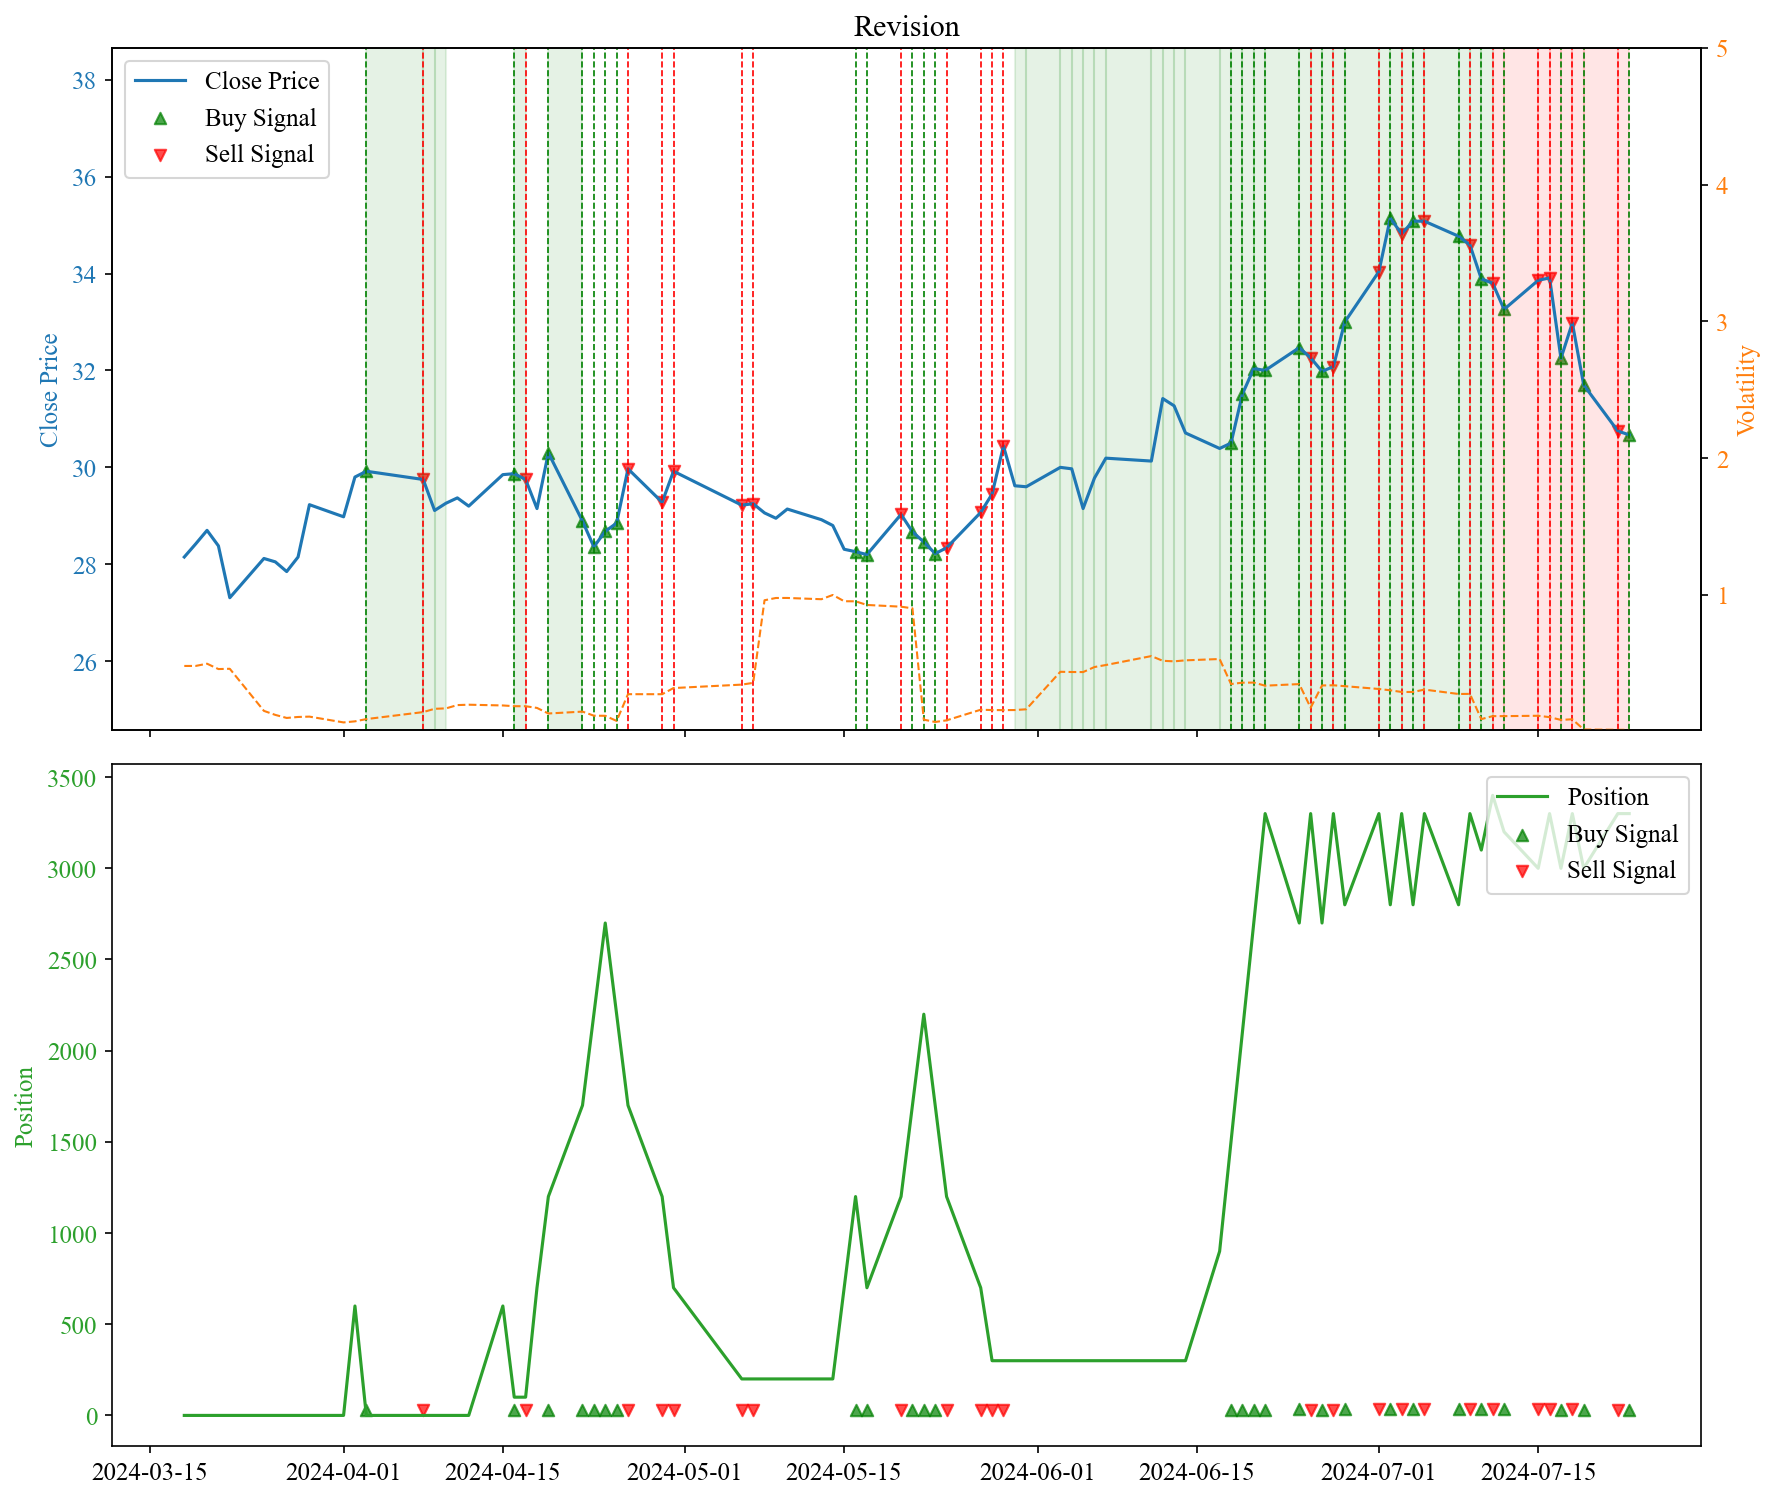

[*********************100%%**********************]  1 of 1 completed

Processing 601225.SS (陕西煤业)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 27}
Best score:  0.018246295571919115
Final Balance: [95312.99953461]  
 Annualized Return: [-12.89] 
 Max Drawdown: [6.25]


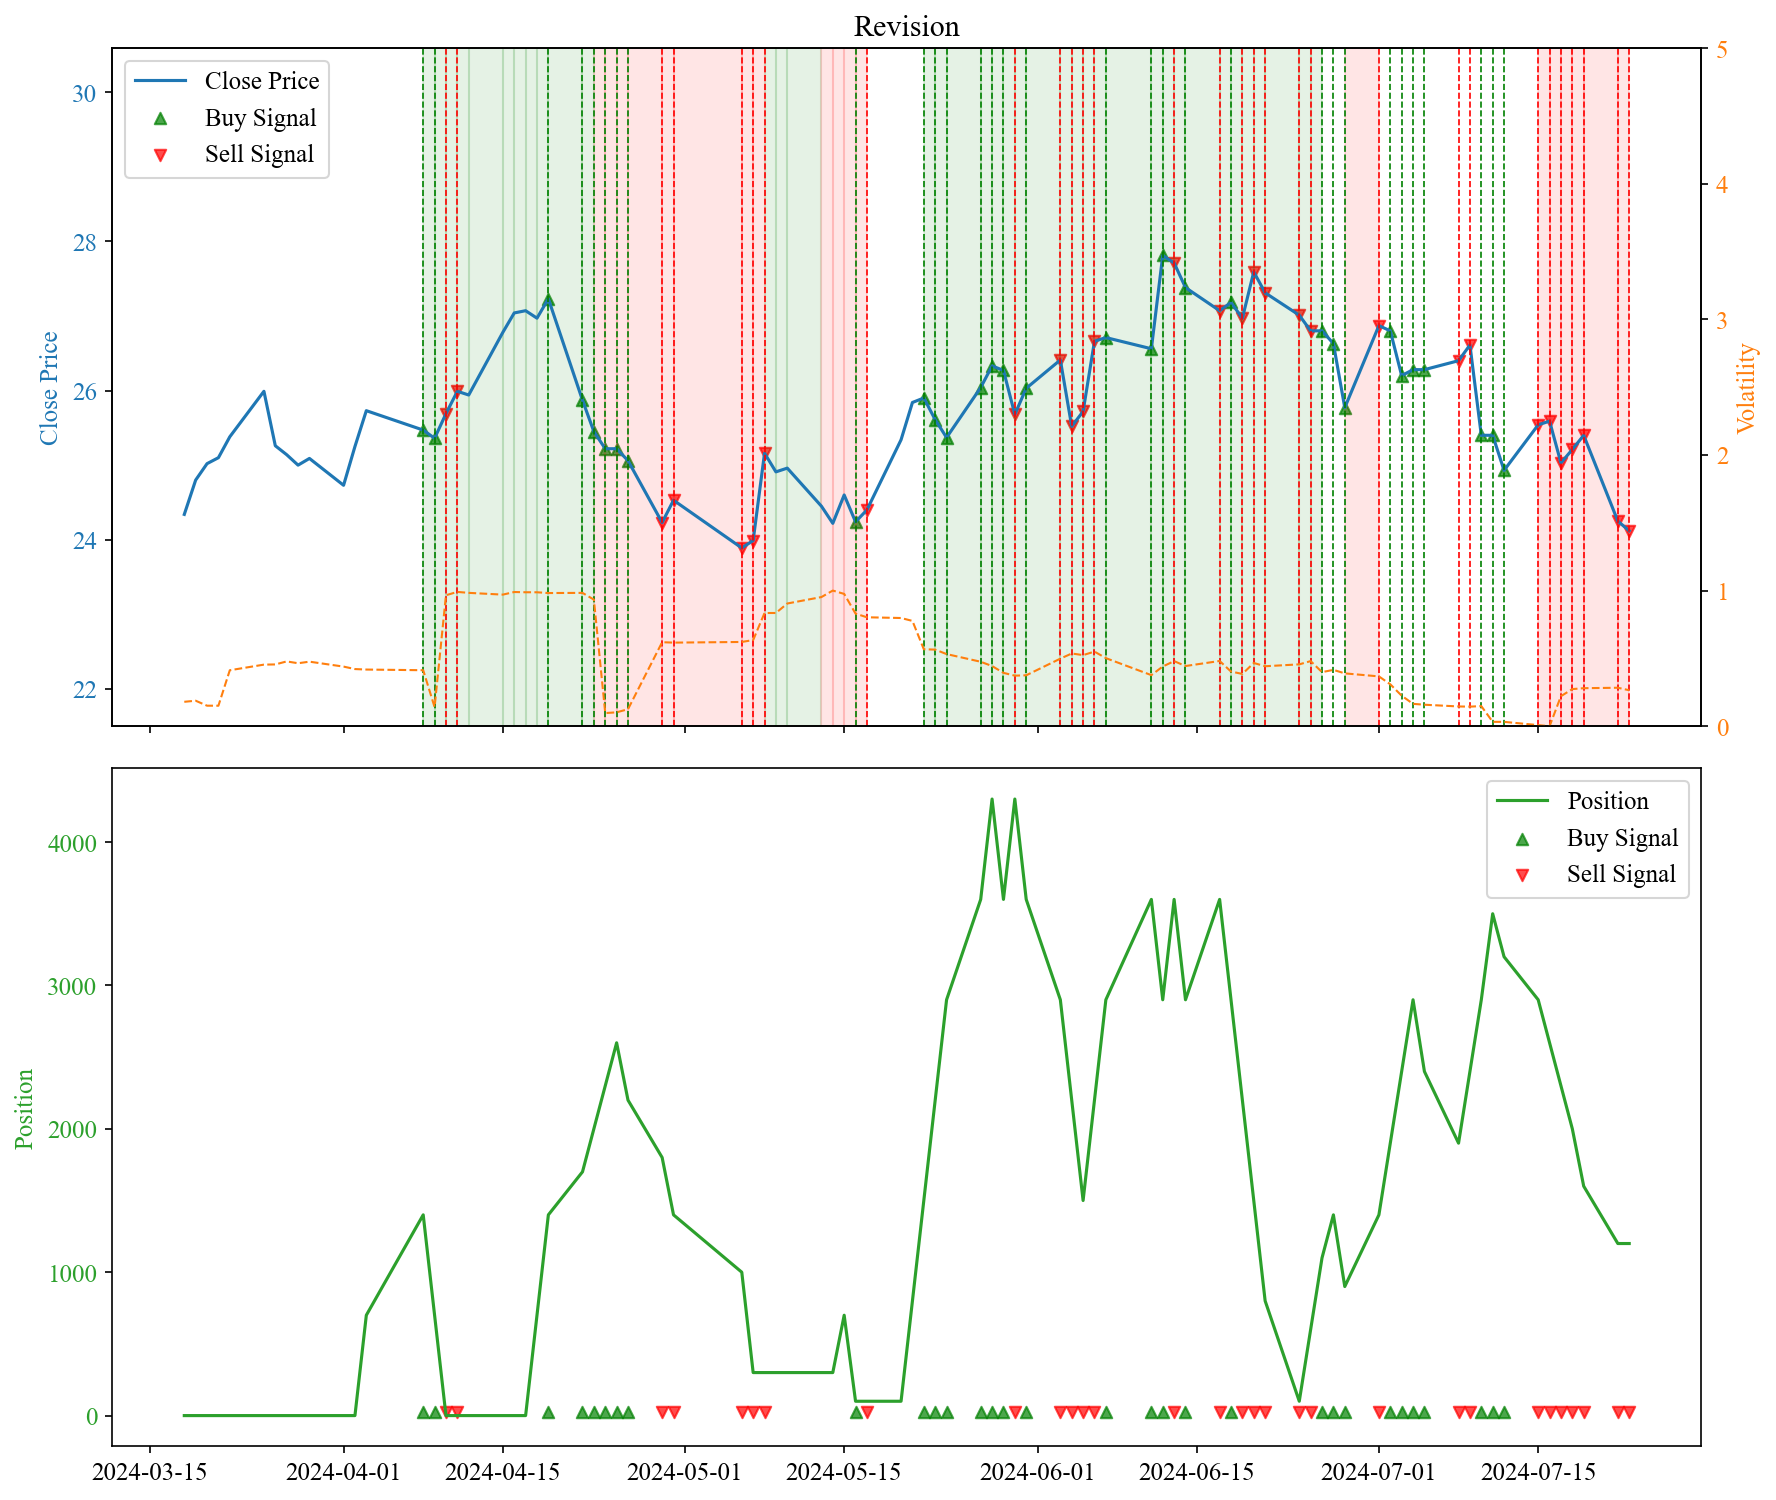

Processing 601898.SS (中煤能源)...


[*********************100%%**********************]  1 of 1 completed
/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 3, 'turnover_window': 12}
Best score:  0.18155331608404593
Final Balance: [102758.00065994]  
 Annualized Return: [6.13] 
 Max Drawdown: [2.79]


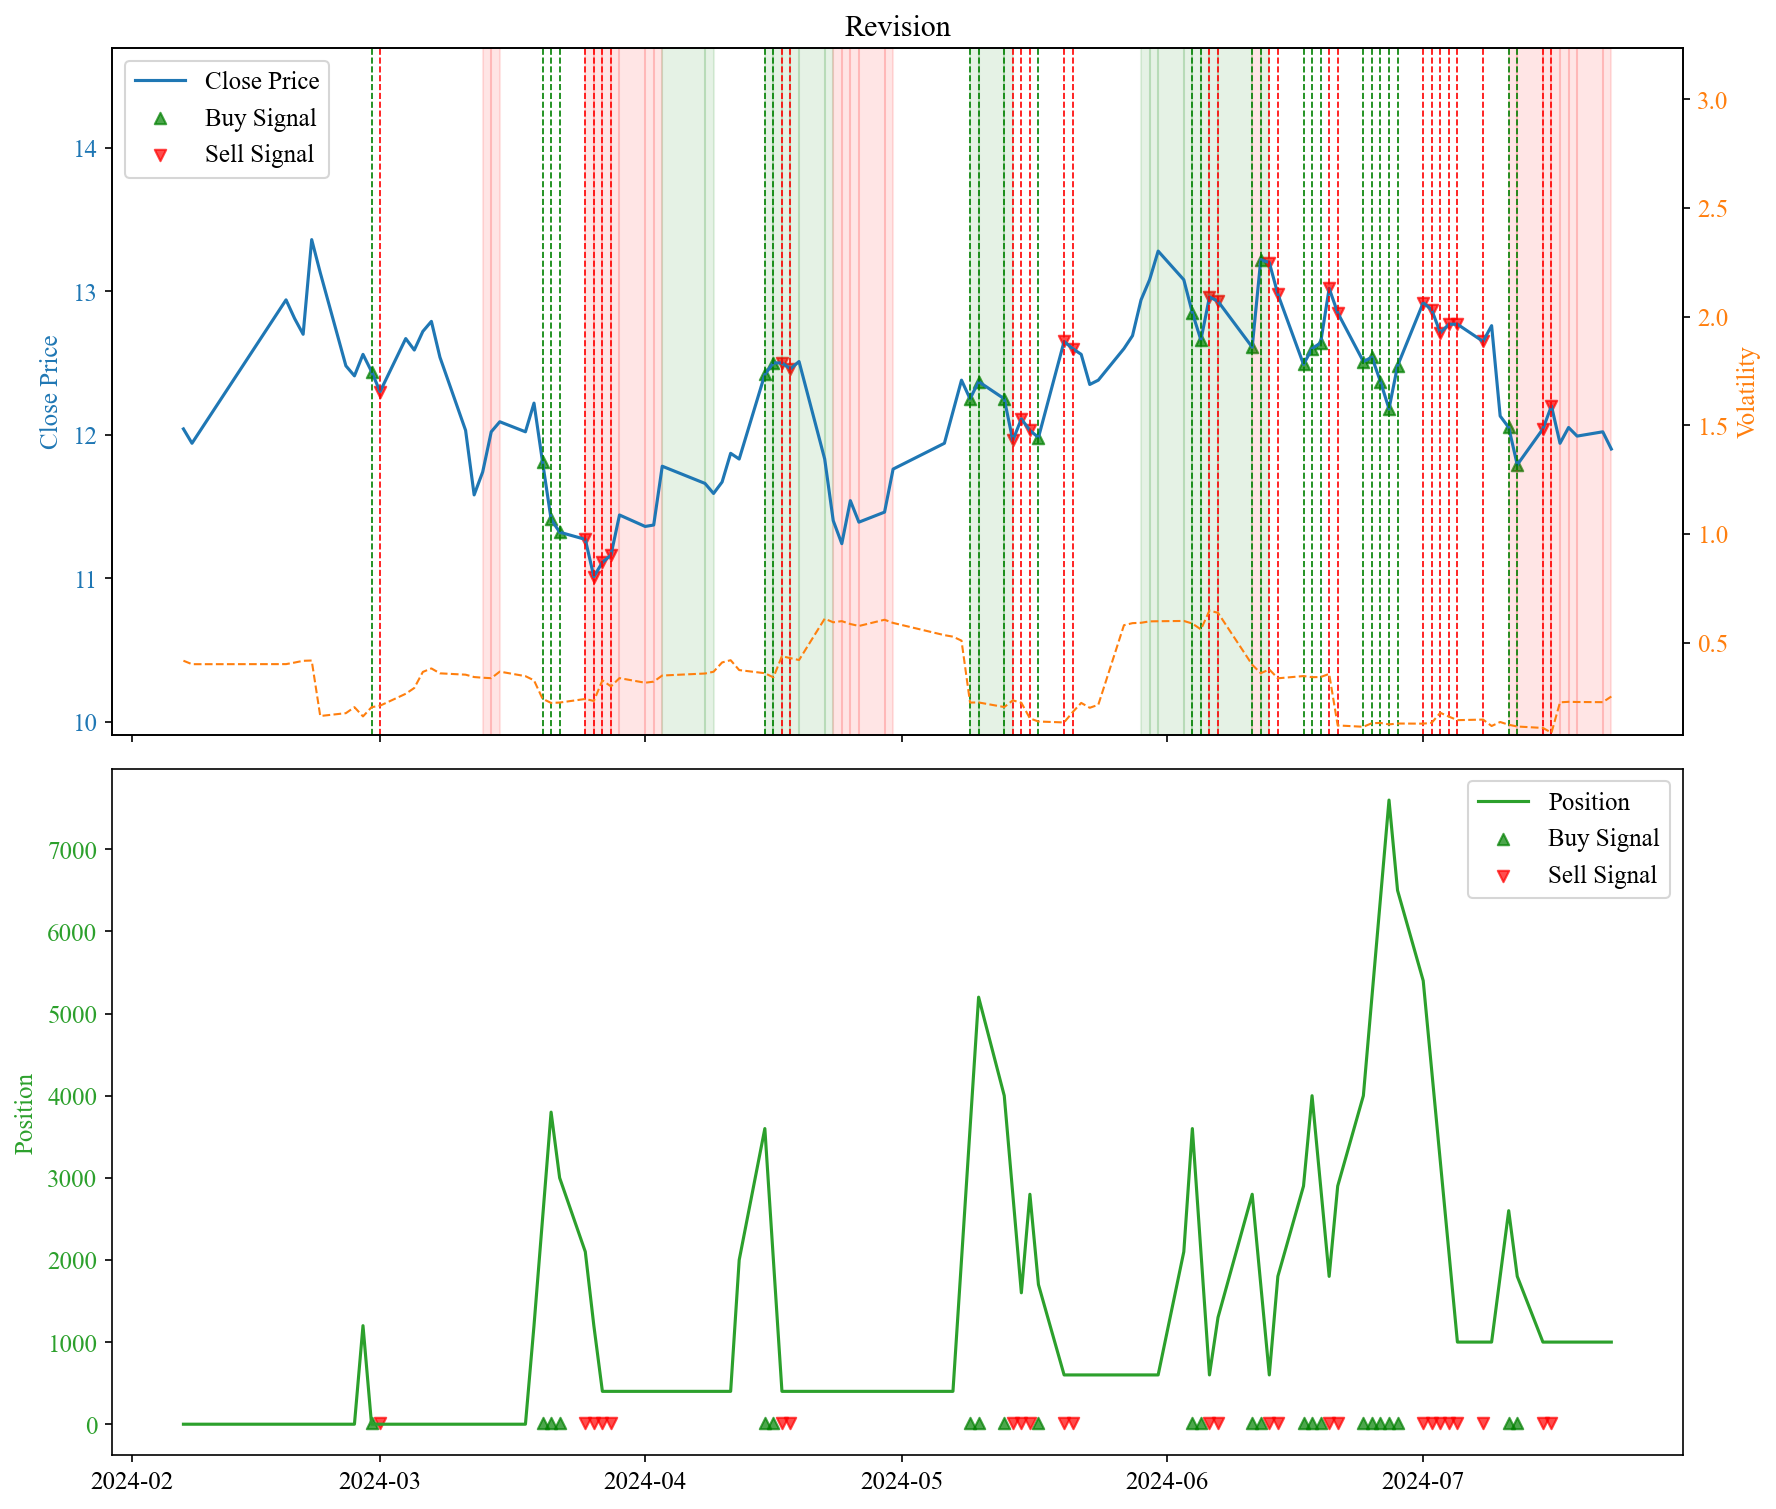

[*********************100%%**********************]  1 of 1 completed

Processing 603993.SS (洛阳钼业)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 51}
Best score:  -0.7076935513996692
Final Balance: [103606.99701309]  
 Annualized Return: [10.72] 
 Max Drawdown: [5.04]


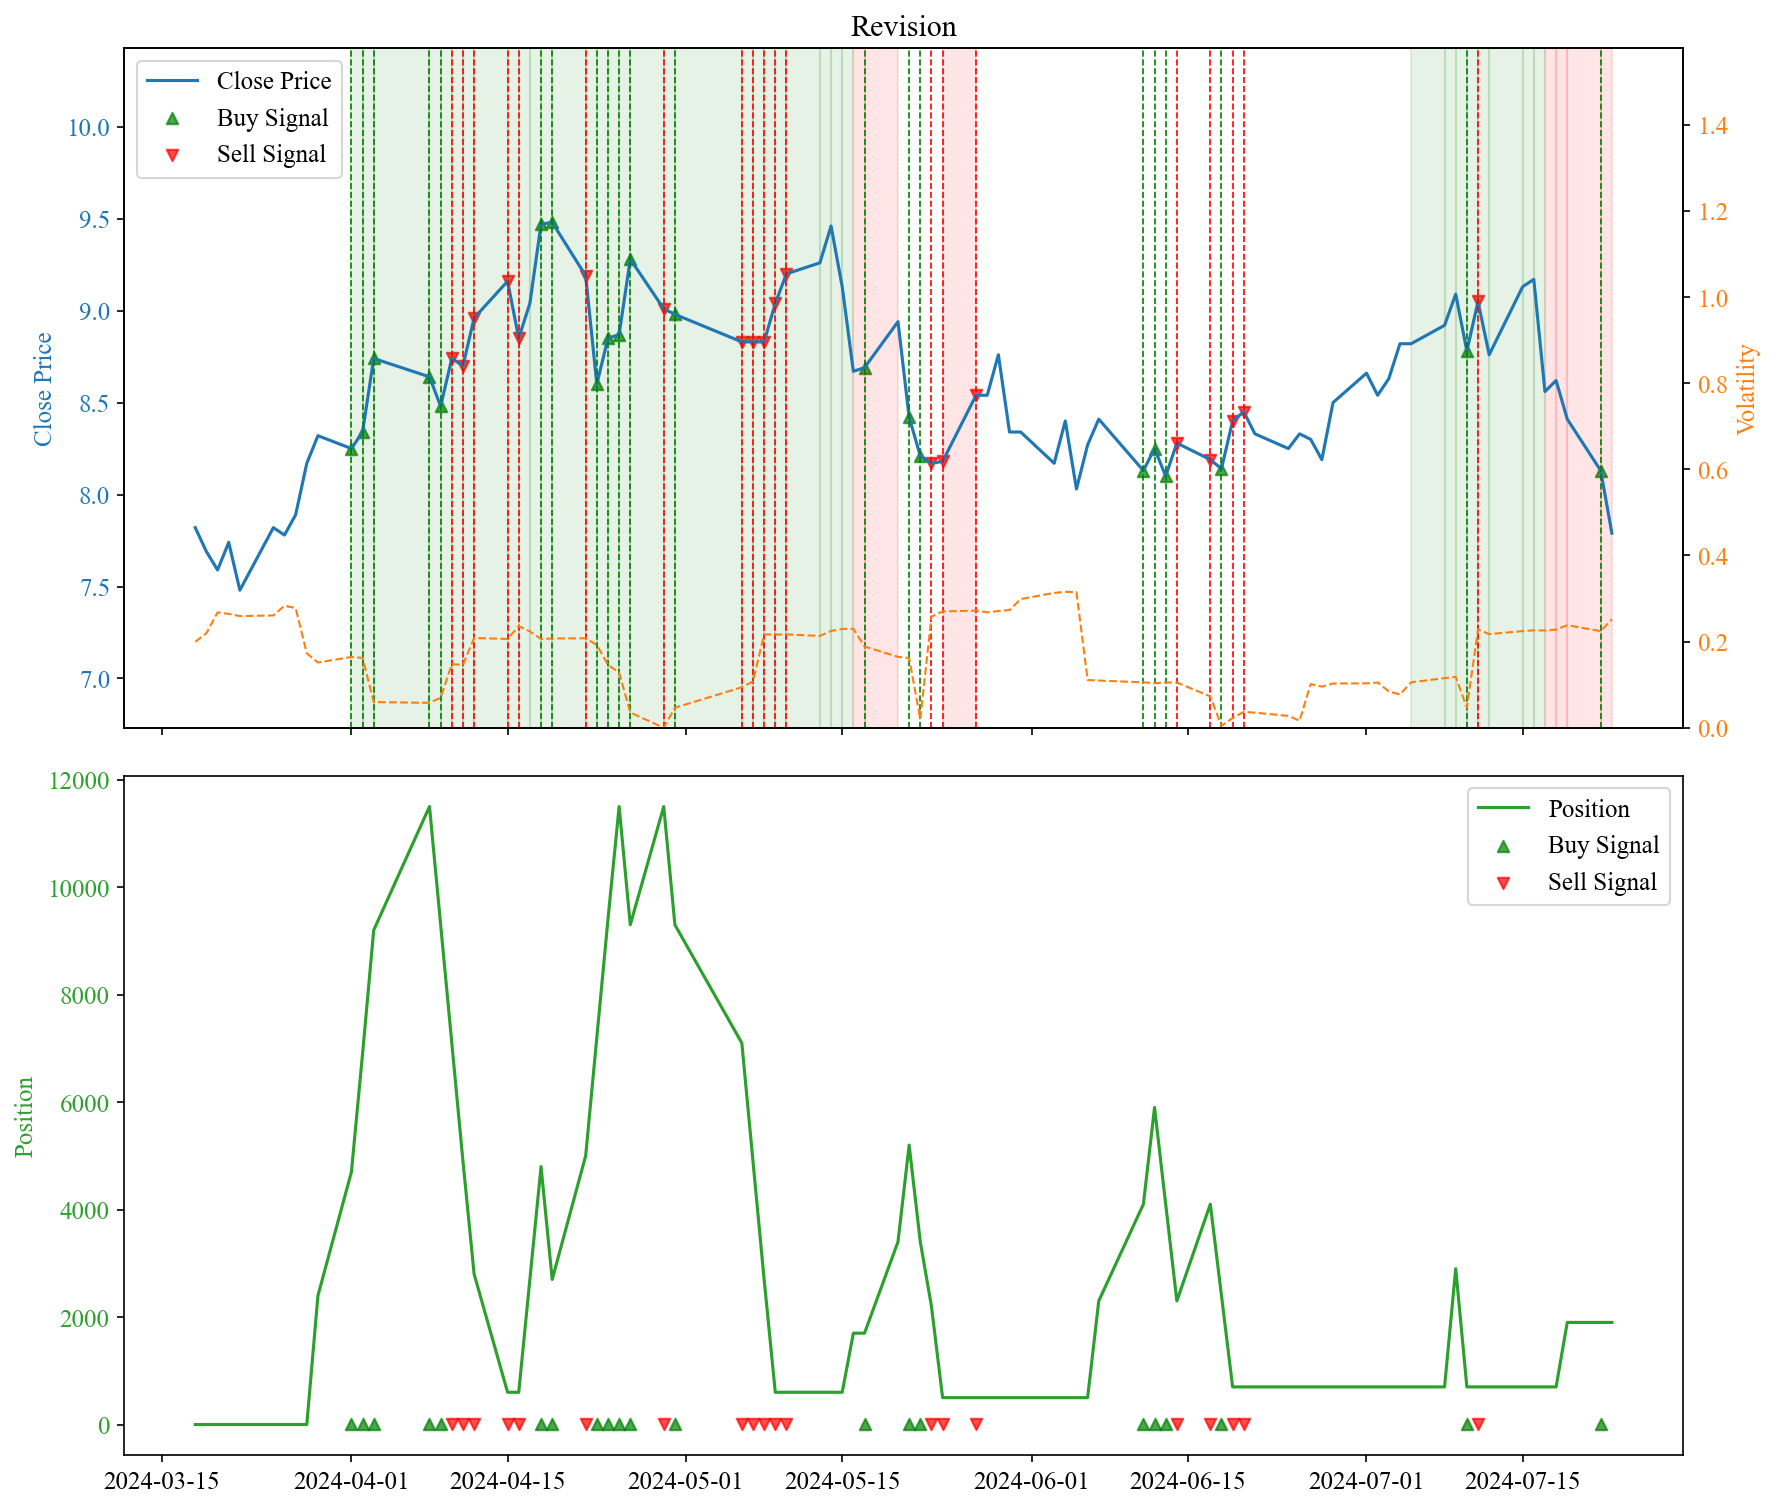

[*********************100%%**********************]  1 of 1 completed

Processing 600111.SS (北方稀土)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 21}
Best score:  -0.5115502186001918
Final Balance: [97771.99783325]  
 Annualized Return: [-6.27] 
 Max Drawdown: [3.79]


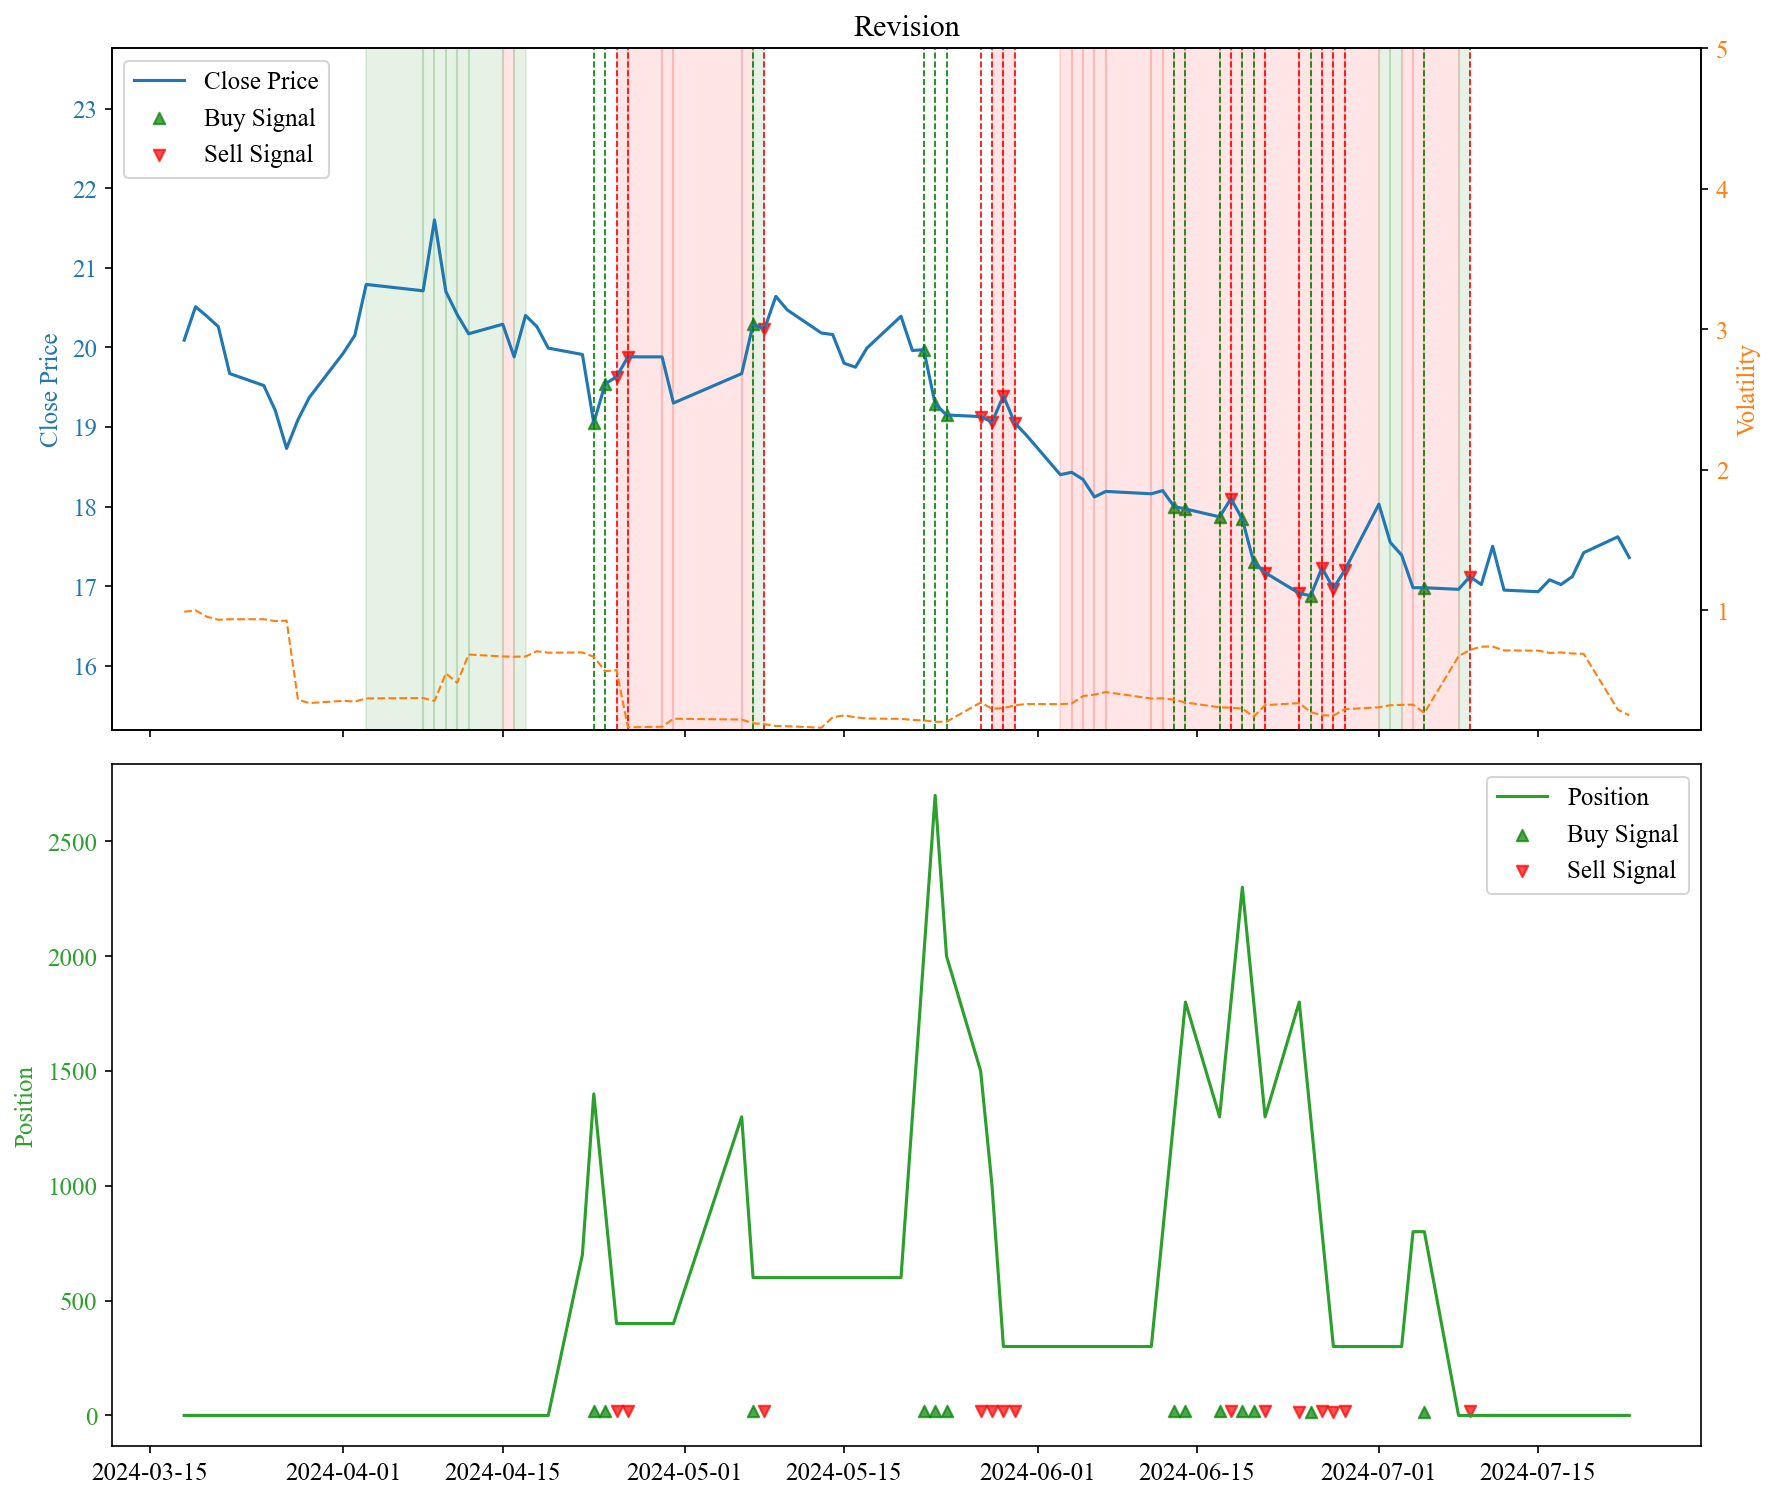

[*********************100%%**********************]  1 of 1 completed

Processing 000831.SZ (中国稀土)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 21}
Best score:  -0.41846908666280386
Final Balance: [98050.99887848]  
 Annualized Return: [-5.5] 
 Max Drawdown: [10.15]


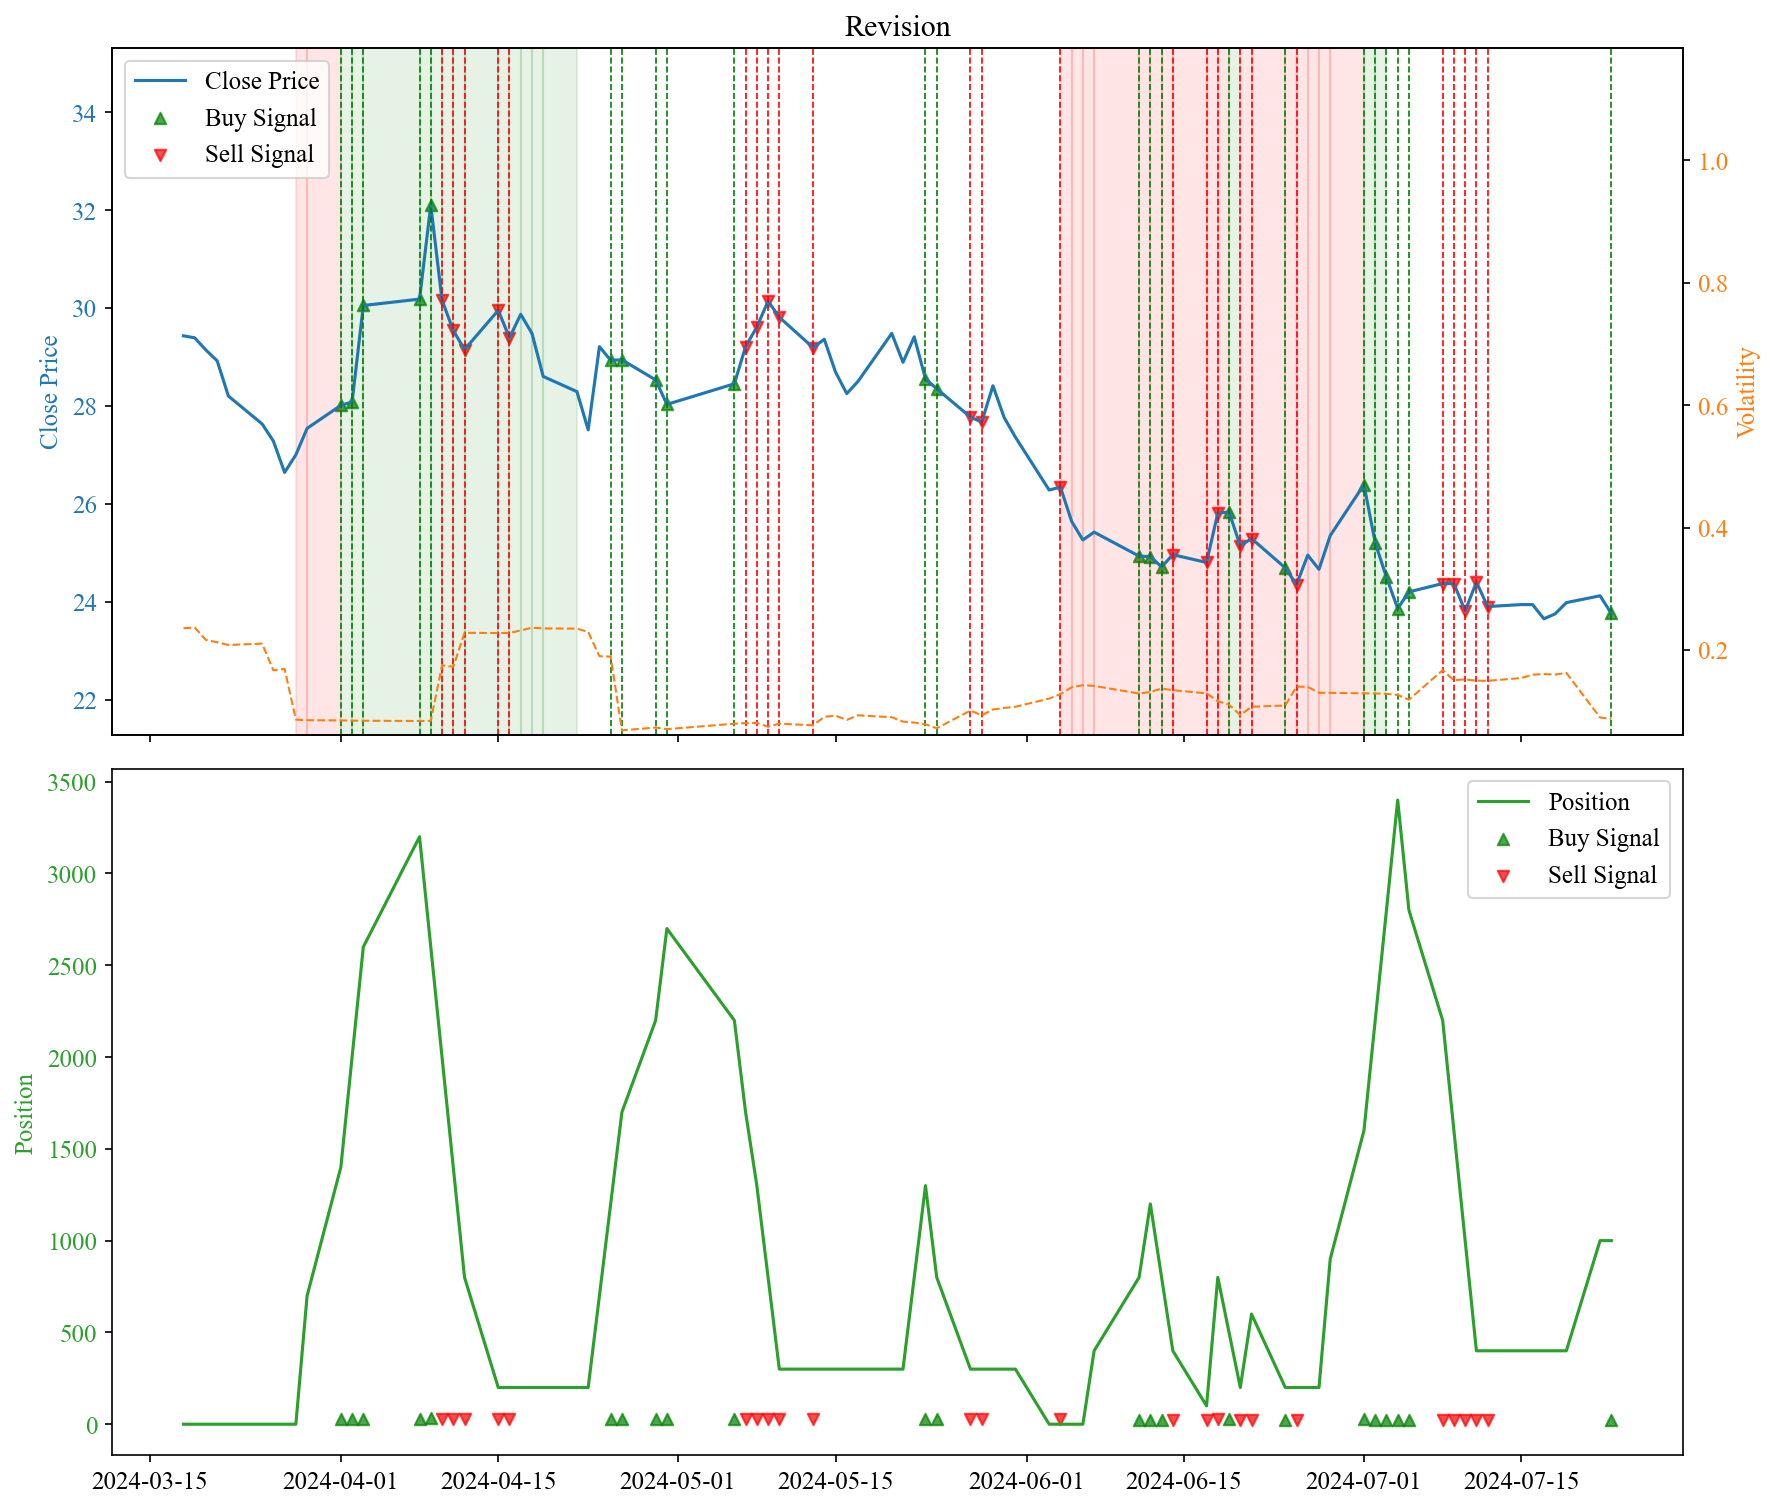

[*********************100%%**********************]  1 of 1 completed

Processing 002460.SZ (赣锋锂业)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 36}
Best score:  -0.8542504811241589
Final Balance: [96328.00045013]  
 Annualized Return: [-10.19] 
 Max Drawdown: [7.73]


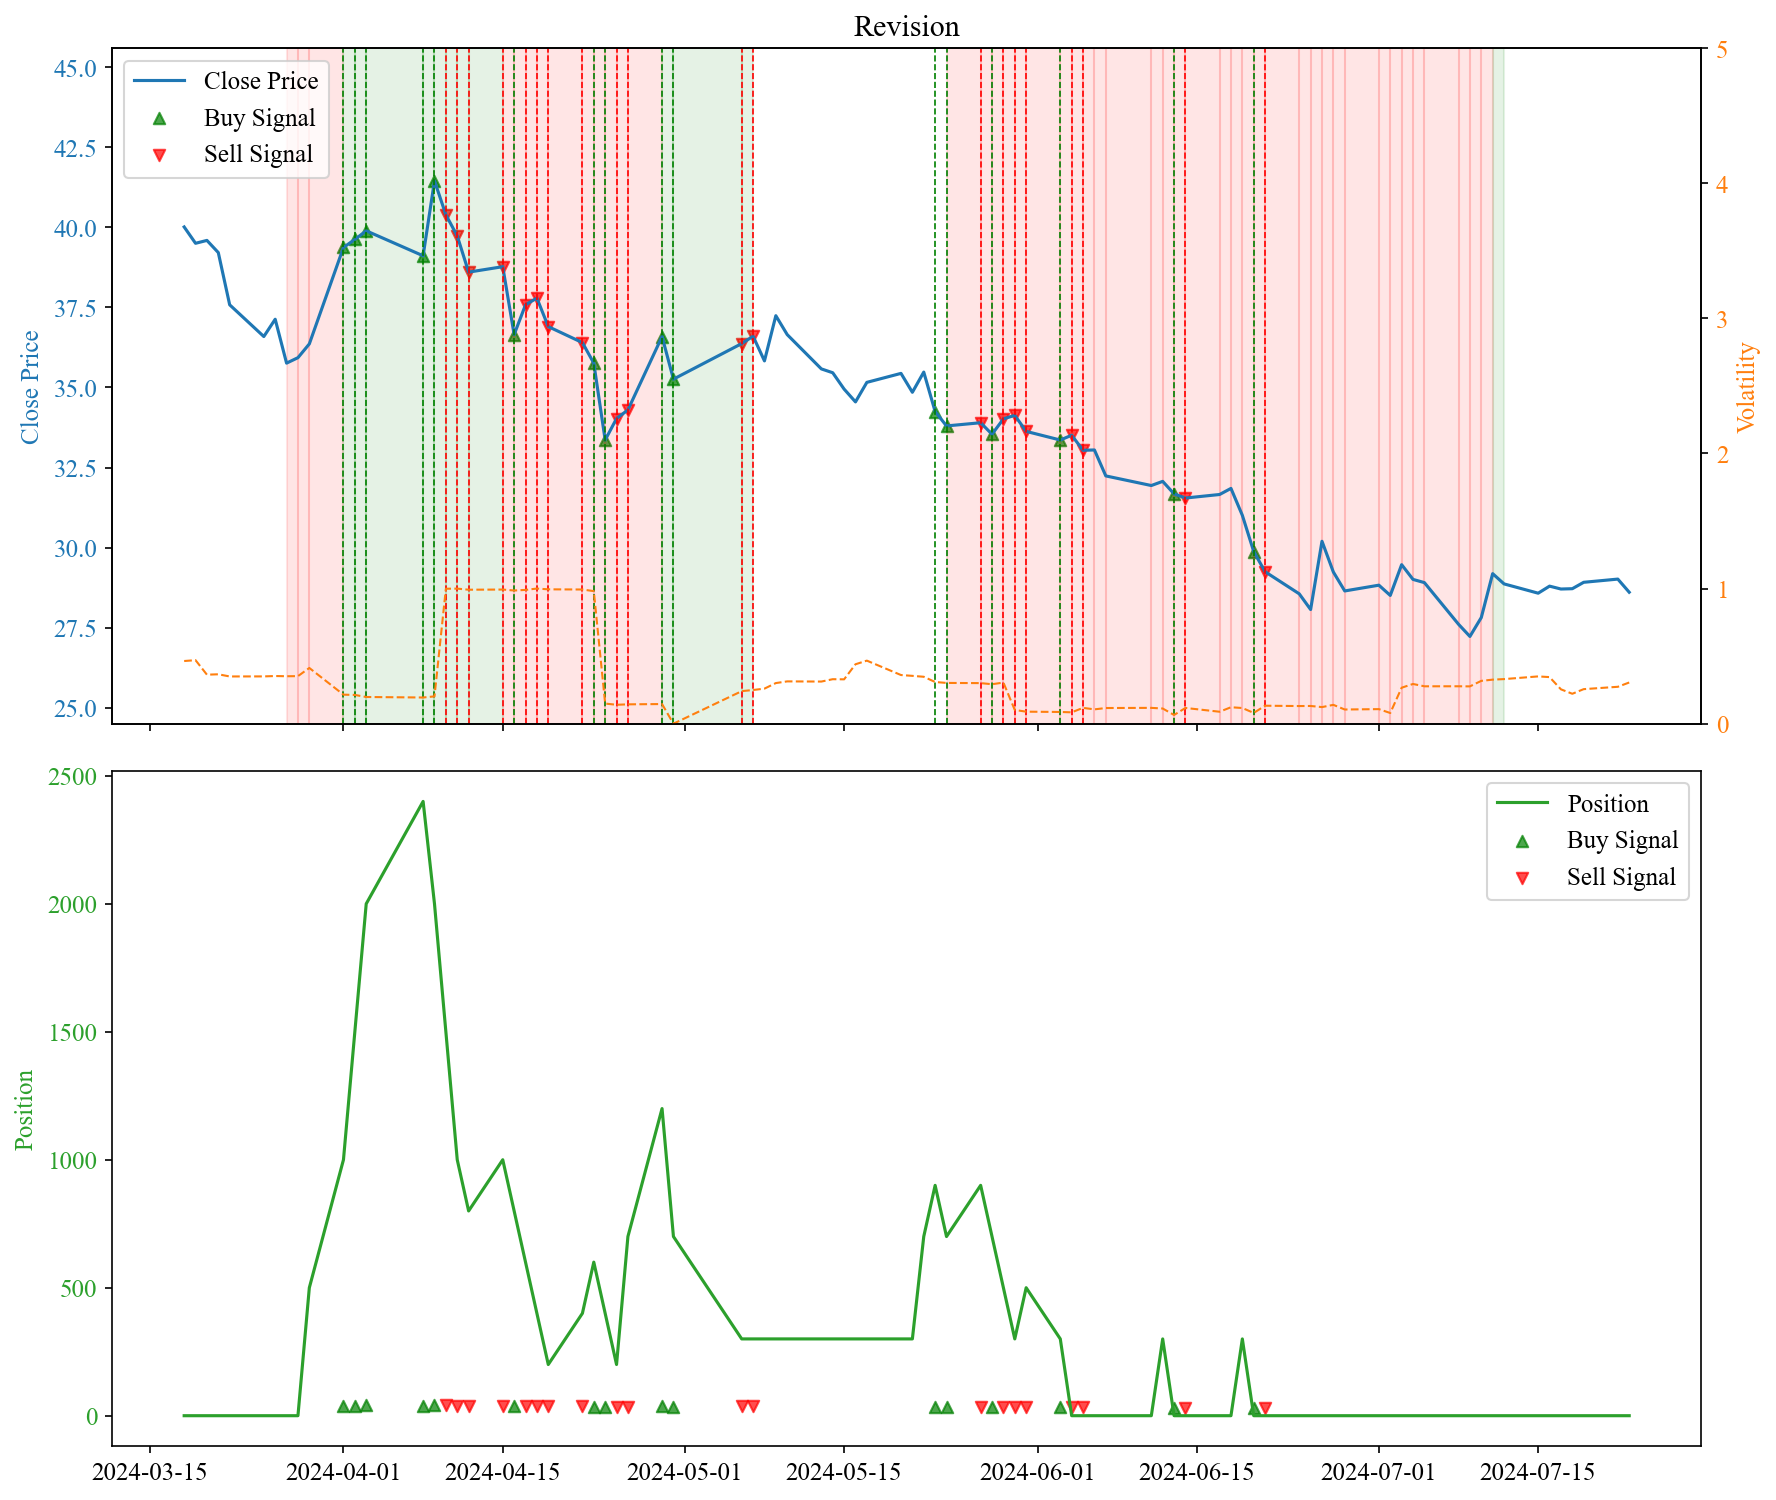

[*********************100%%**********************]  1 of 1 completed

Processing 002466.SZ (天齐锂业)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 39}
Best score:  -0.8188182121218746
Final Balance: [96786.99684143]  
 Annualized Return: [-8.96] 
 Max Drawdown: [5.65]


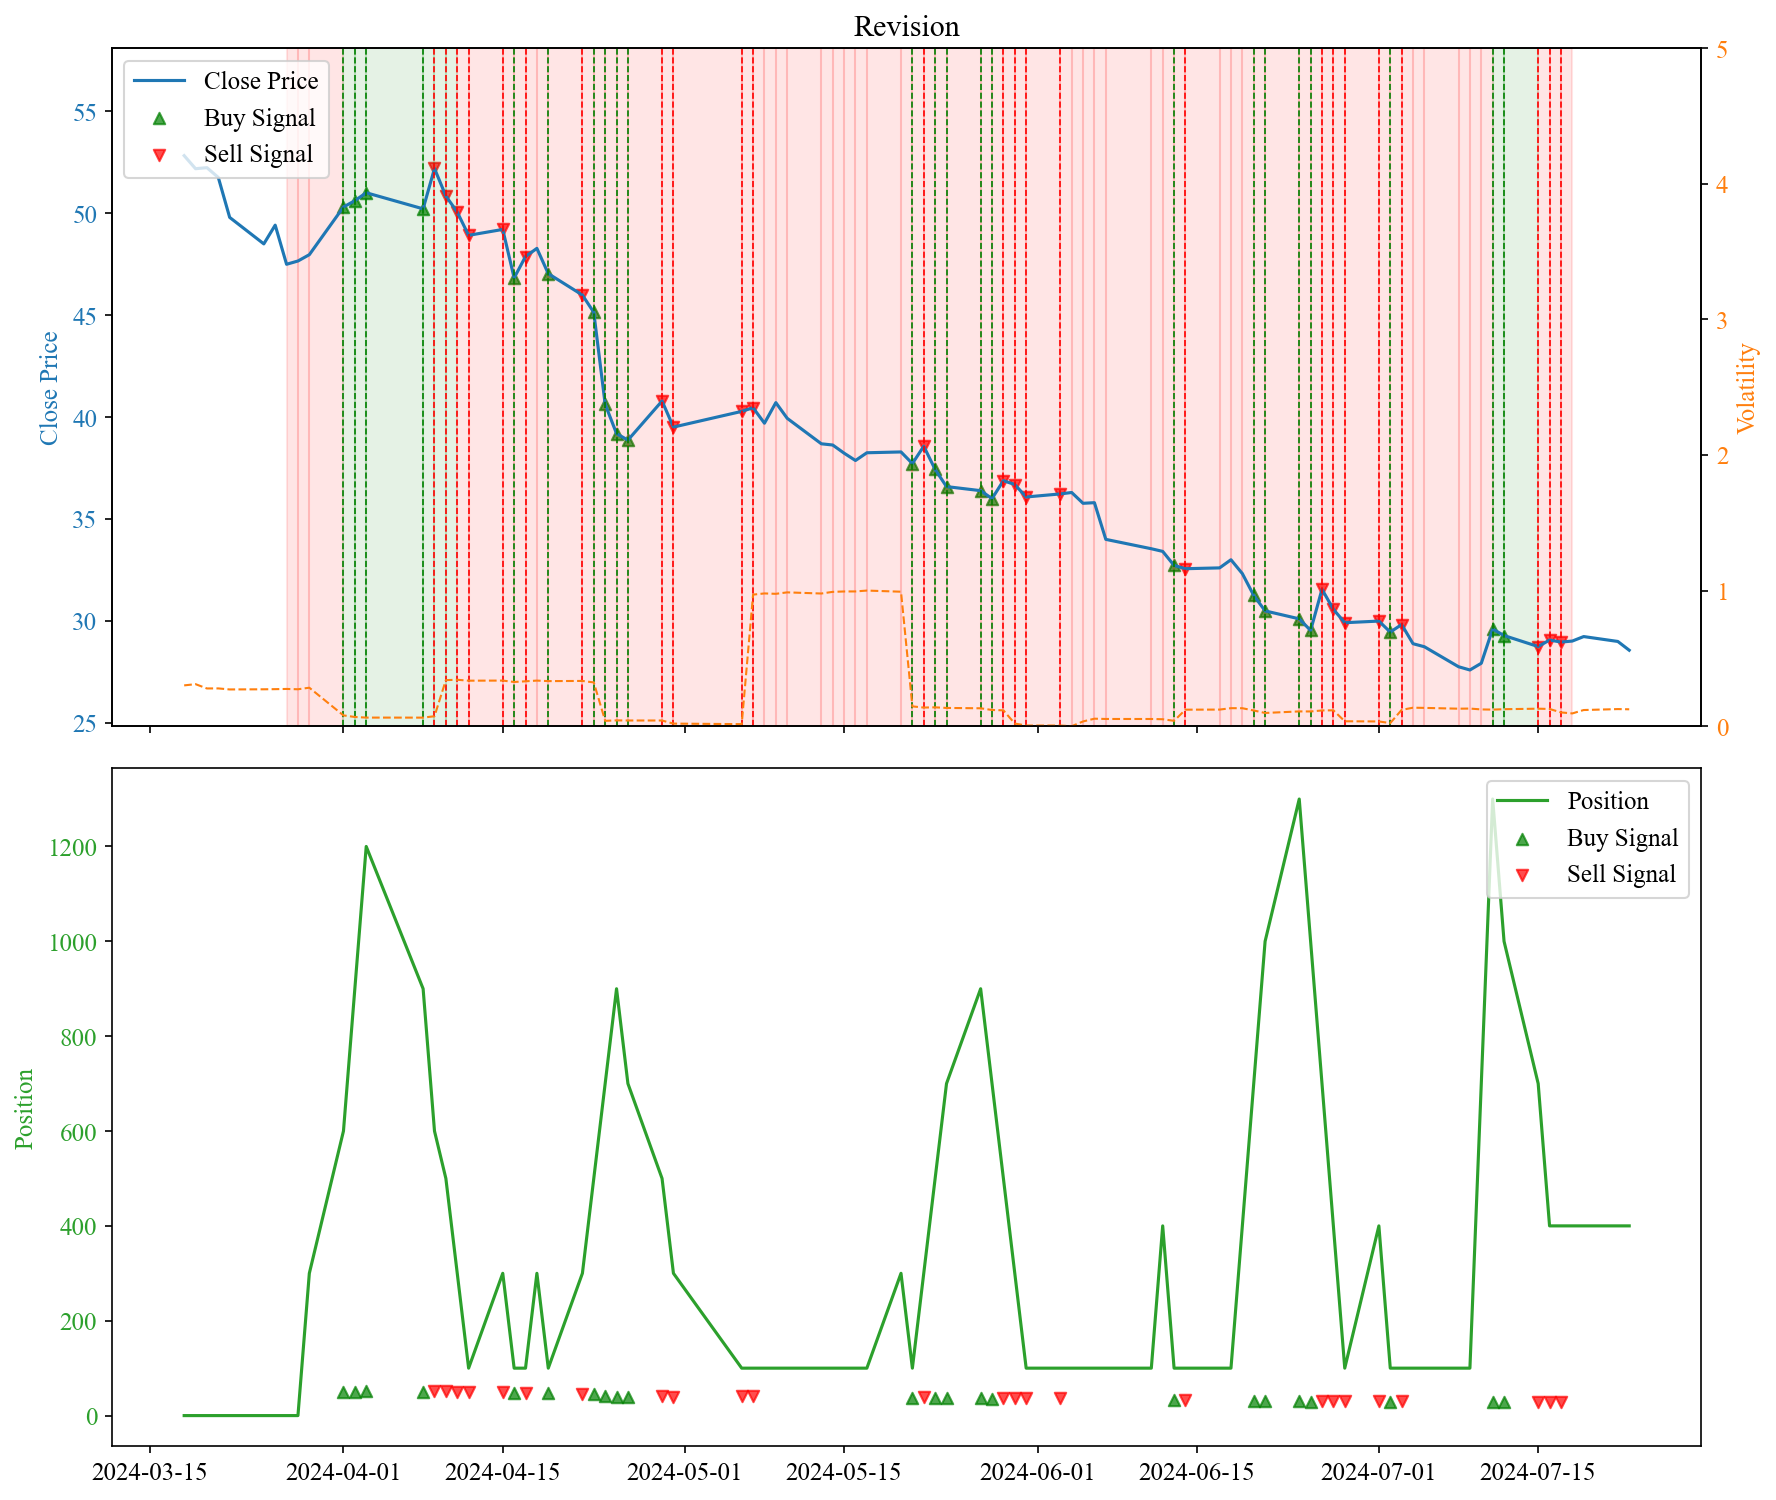

[*********************100%%**********************]  1 of 1 completed

Processing 601600.SS (中国铝业)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 54}
Best score:  -0.525822886073434
Final Balance: [100810.00366211]  
 Annualized Return: [2.35] 
 Max Drawdown: [6.97]


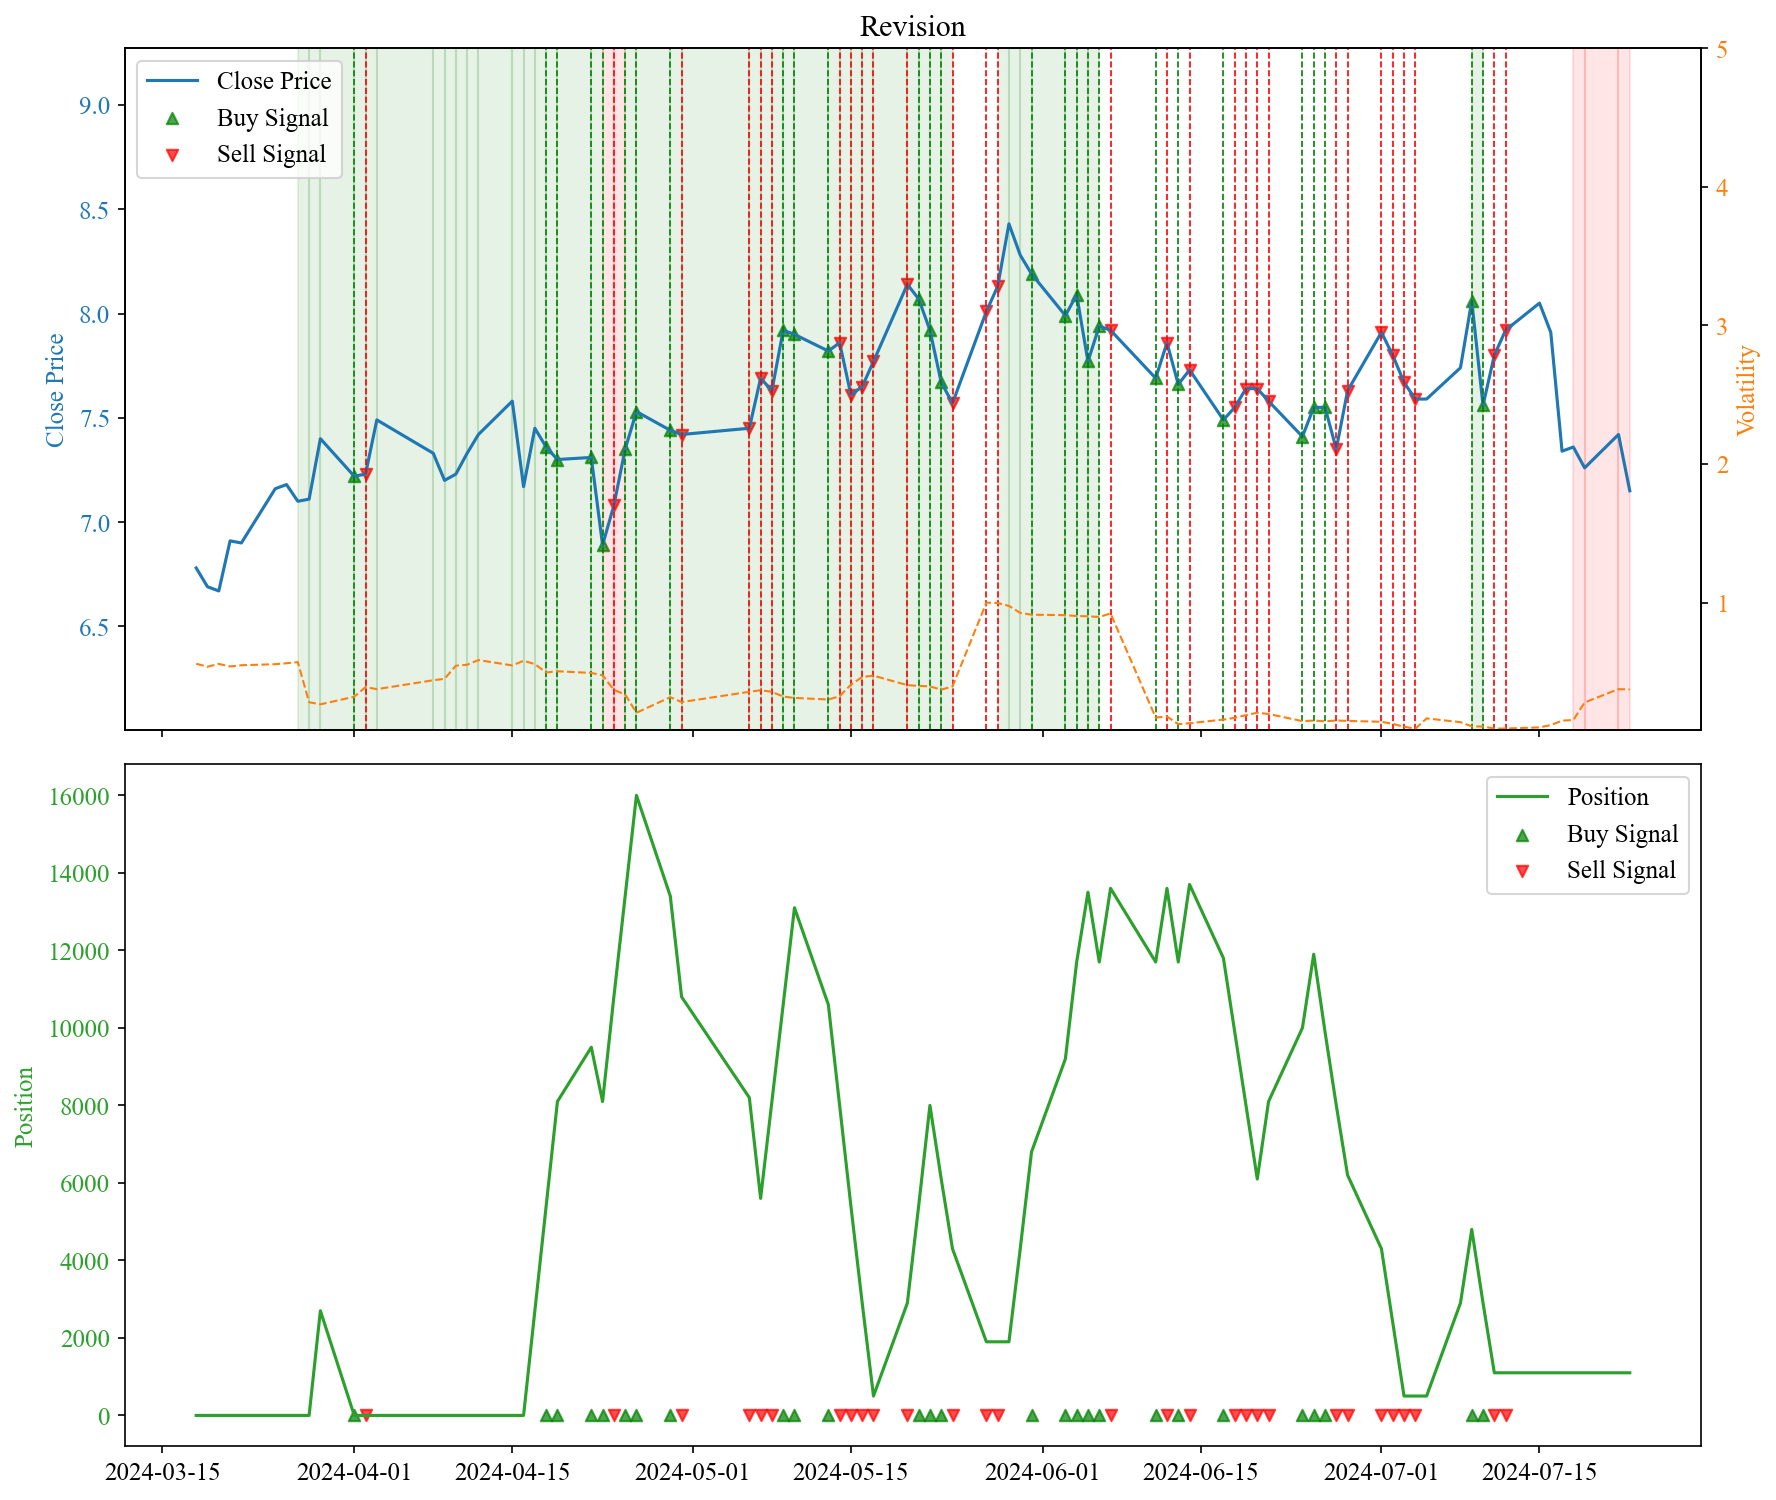

Processing 603799.SS (华友钴业)...


[*********************100%%**********************]  1 of 1 completed
/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 24}
Best score:  -0.3103074533788764
Final Balance: [88242.99736023]  
 Annualized Return: [-30.2] 
 Max Drawdown: [14.28]


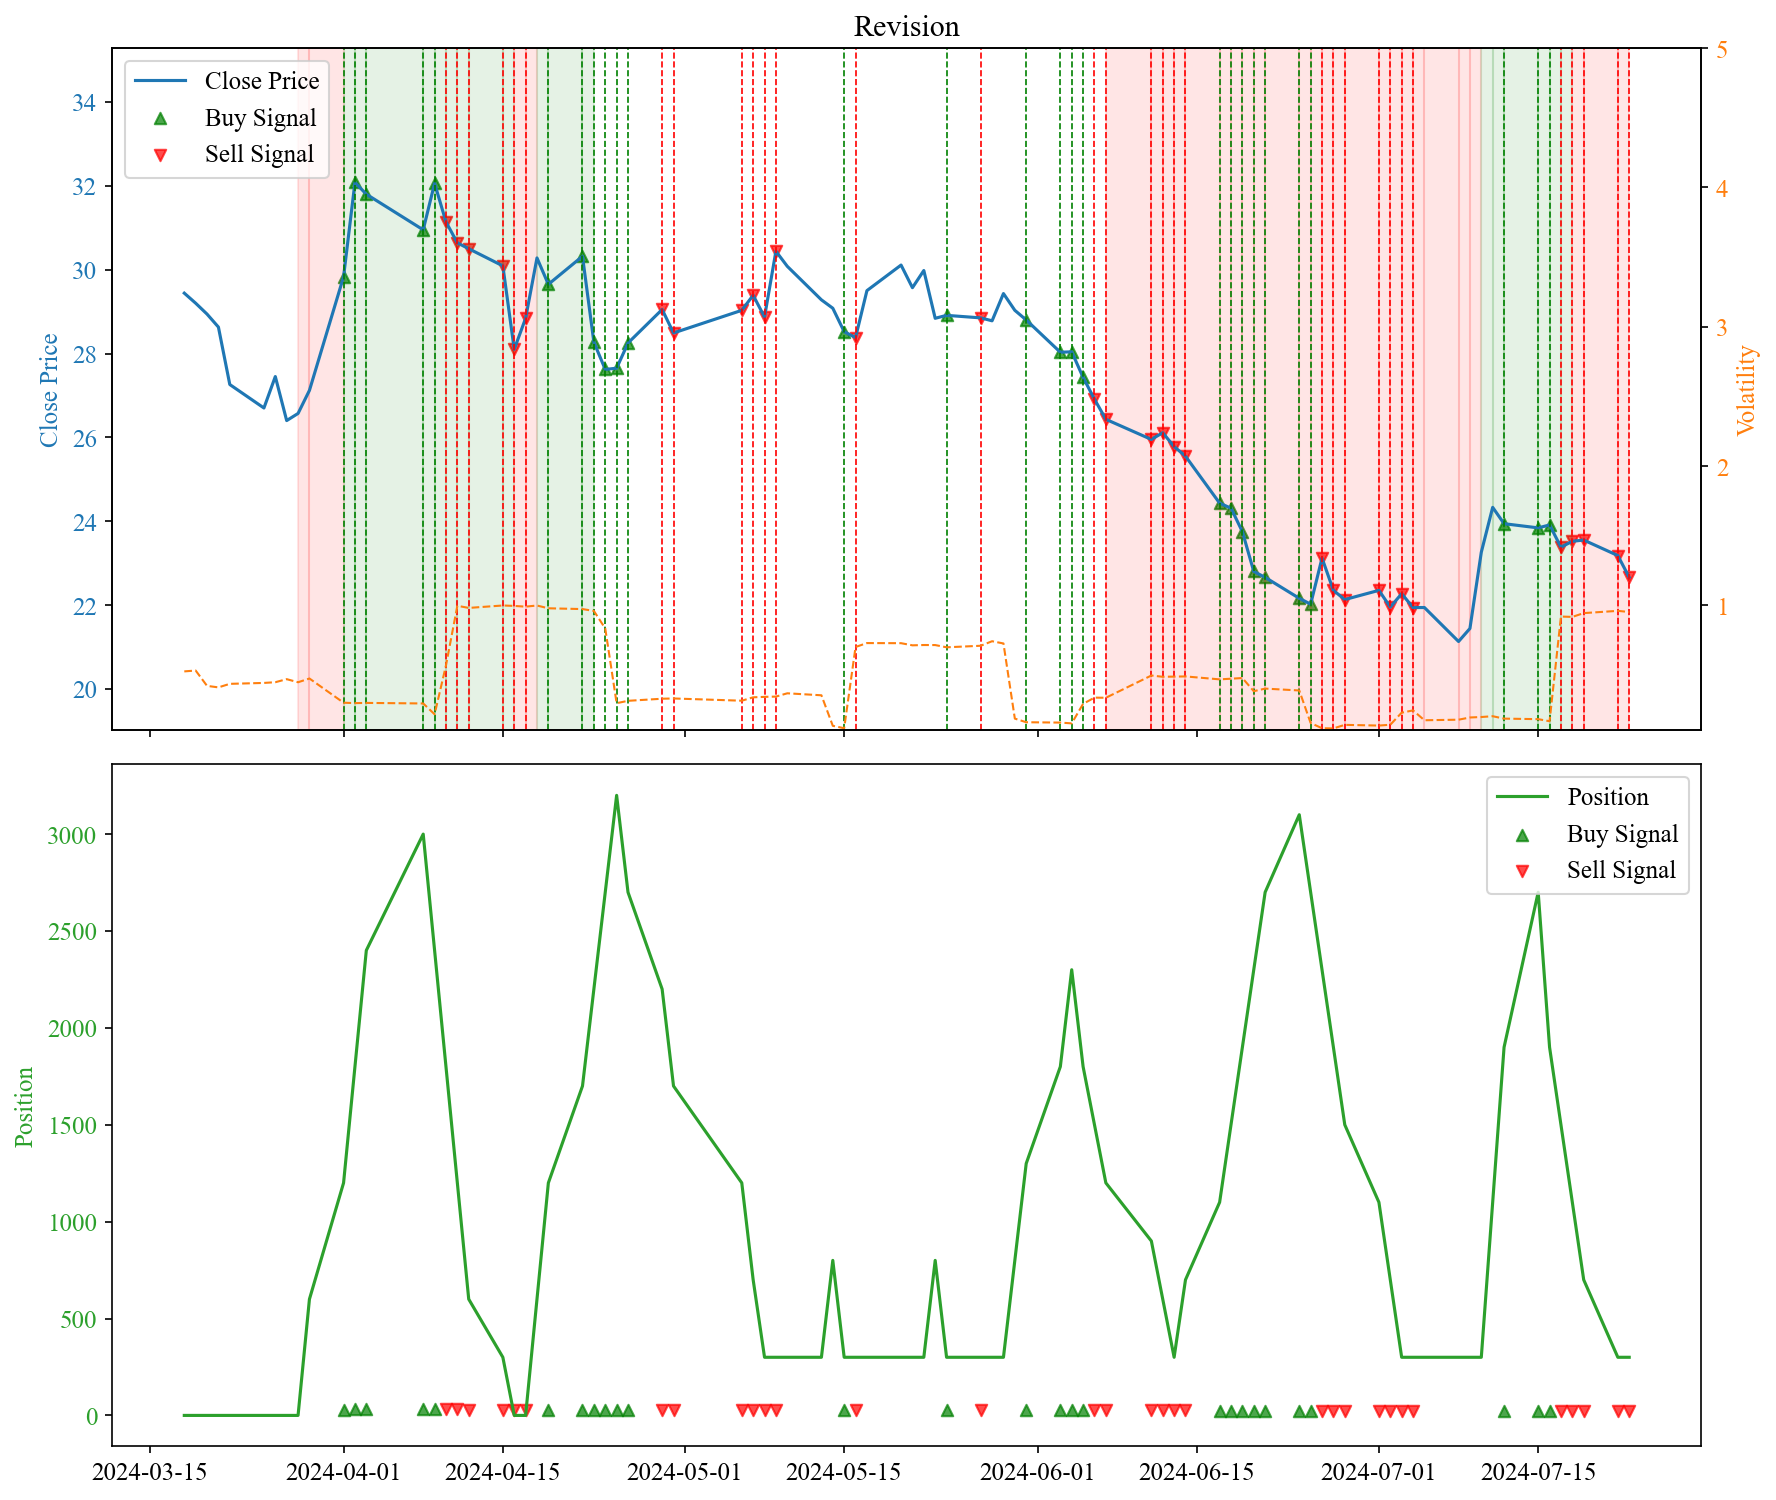

Processing 601919.SS (中远海控)...


[*********************100%%**********************]  1 of 1 completed
/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 33}
Best score:  -0.8334165878997668
Final Balance: [103122.99938202]  
 Annualized Return: [9.24] 
 Max Drawdown: [12.1]


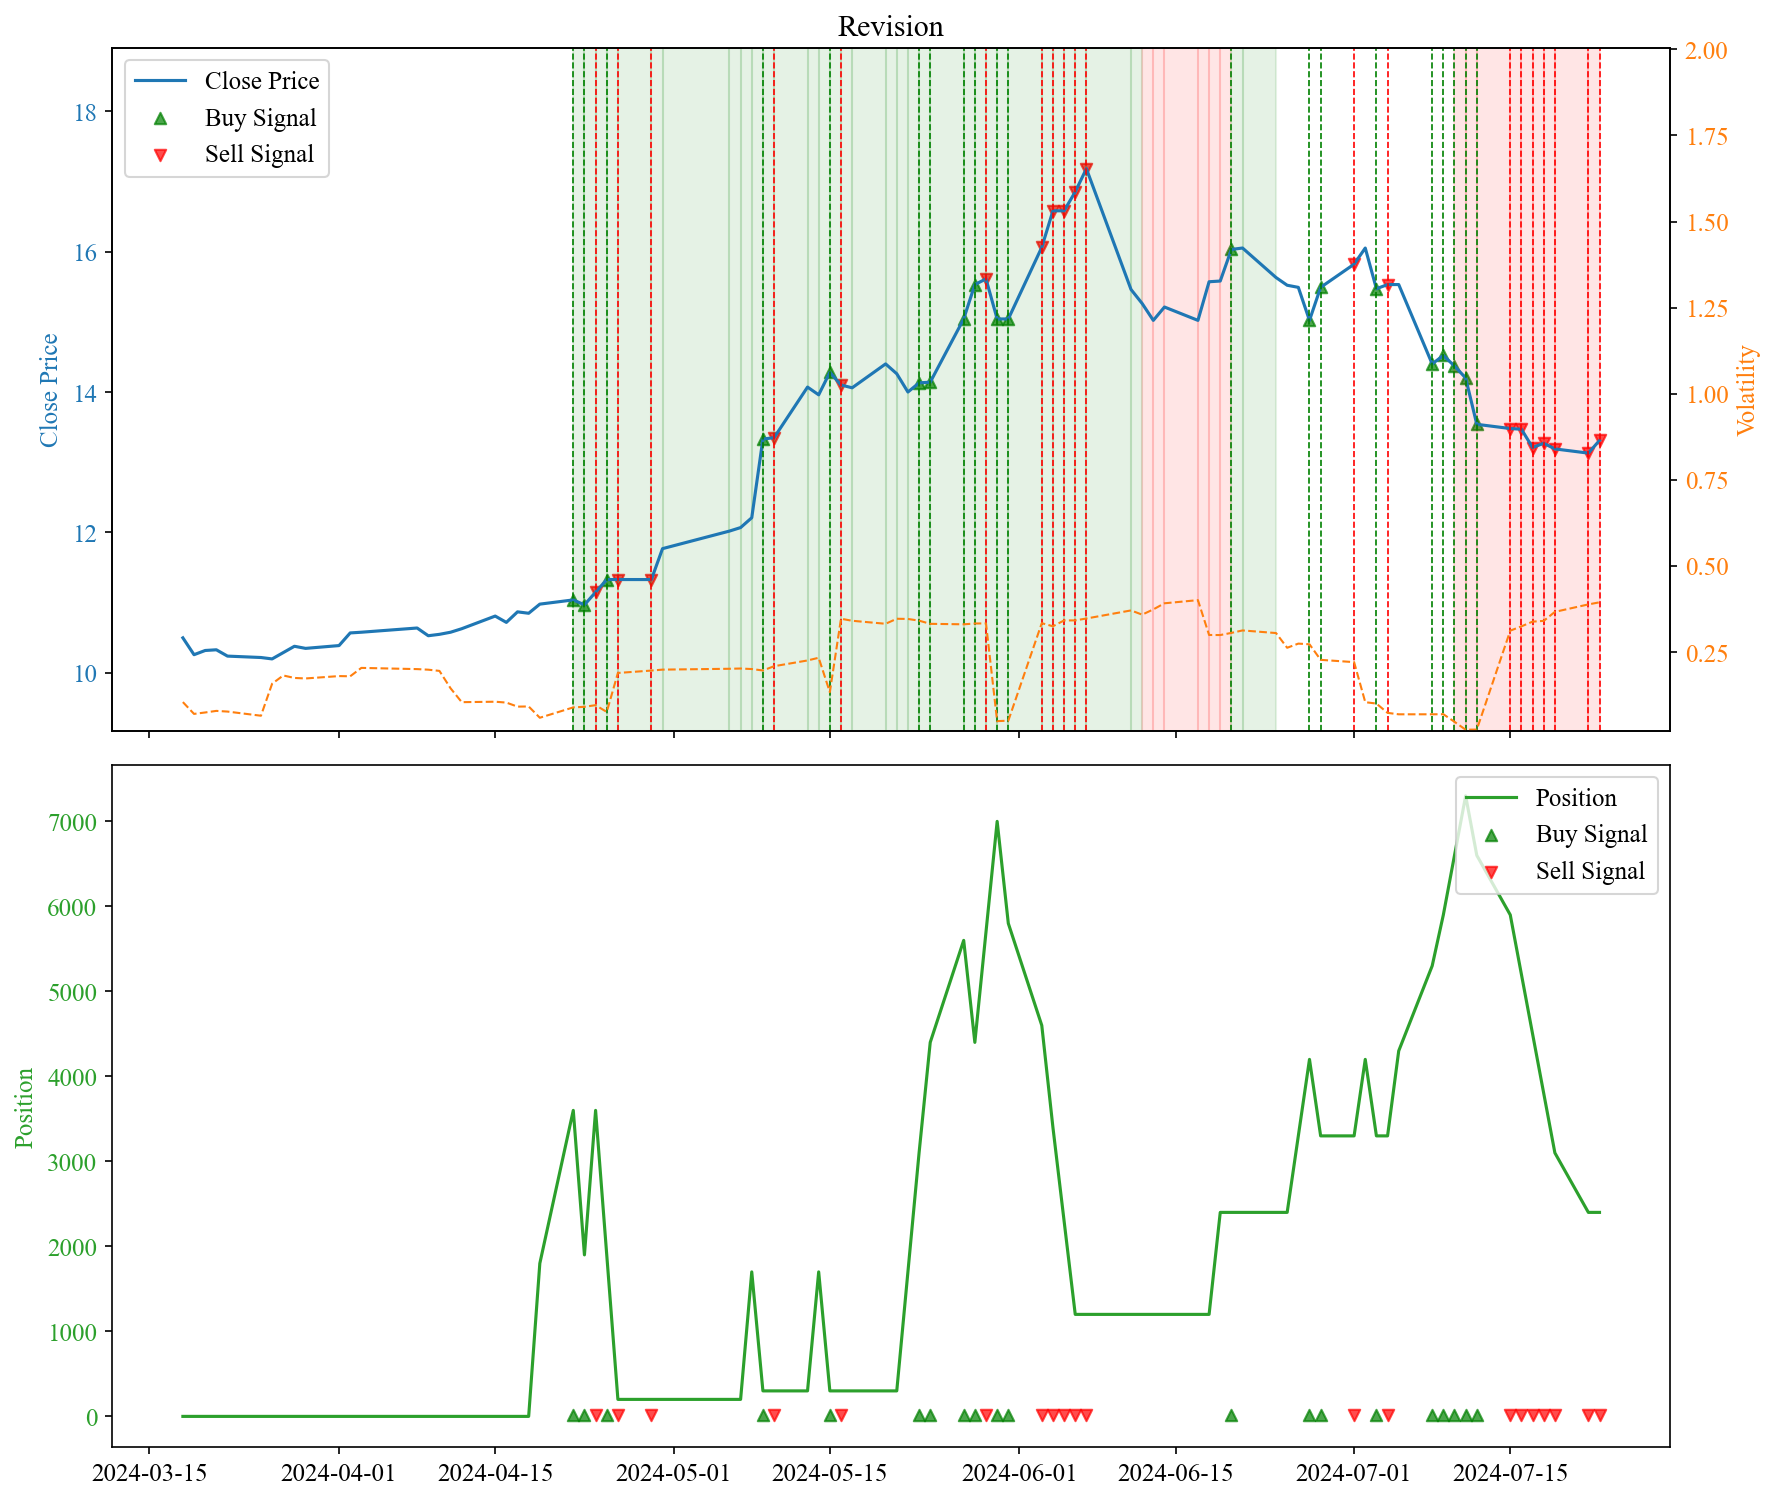

[*********************100%%**********************]  1 of 1 completed

Processing 600026.SS (中远海能)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 21, 'turnover_window': 24}
Best score:  -0.14028663046083625
Final Balance: [101847.99985886]  
 Annualized Return: [4.53] 
 Max Drawdown: [10.64]


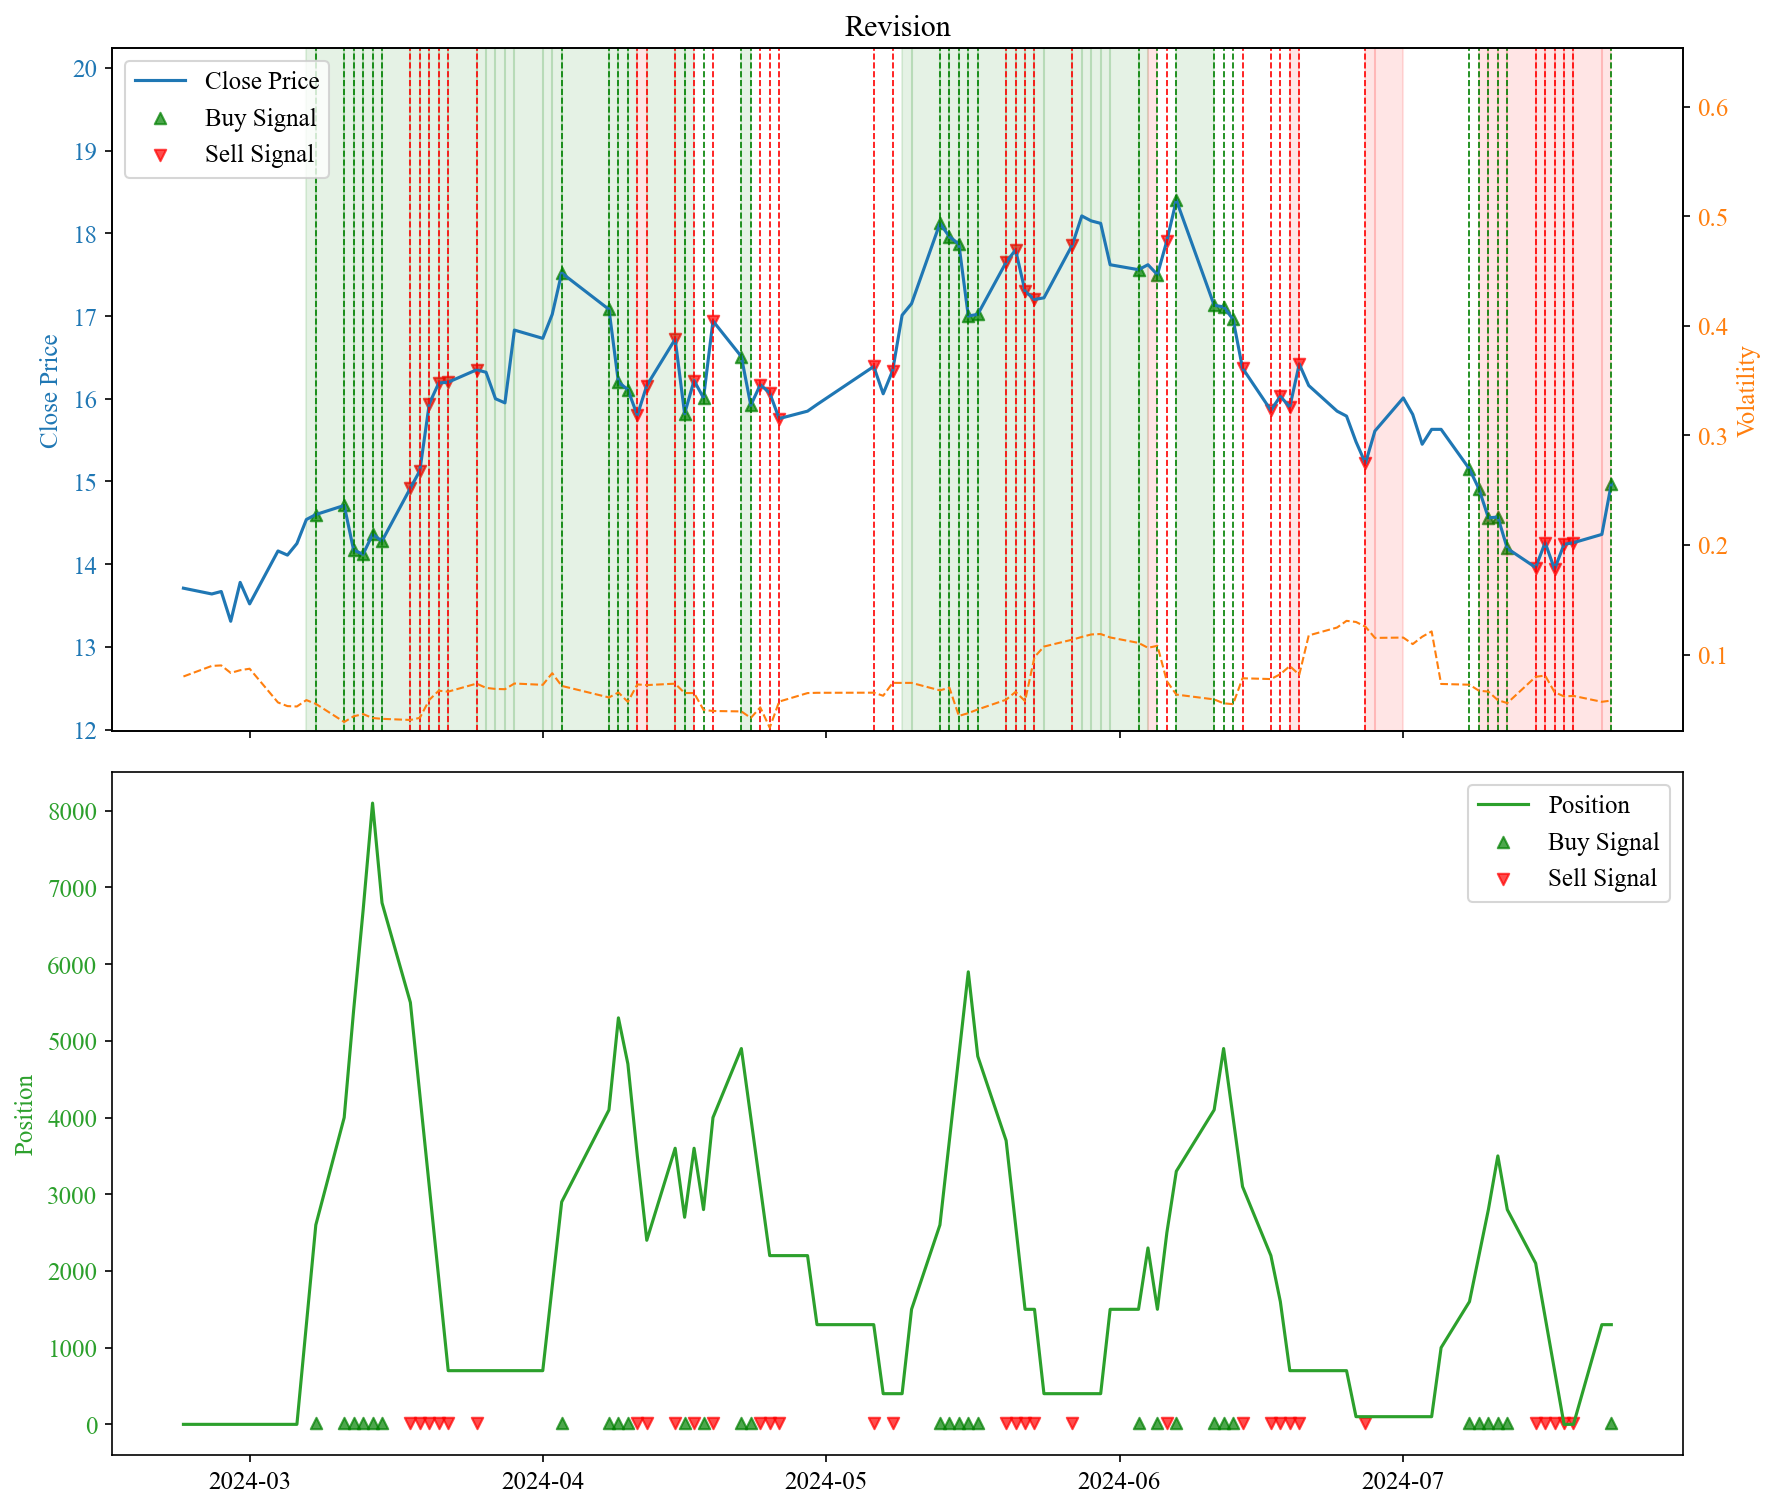

[*********************100%%**********************]  1 of 1 completed

Processing 000975.SZ (银泰黄金)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 33}
Best score:  -0.48618586740002584
Final Balance: [99226.00002289]  
 Annualized Return: [-2.21] 
 Max Drawdown: [8.51]


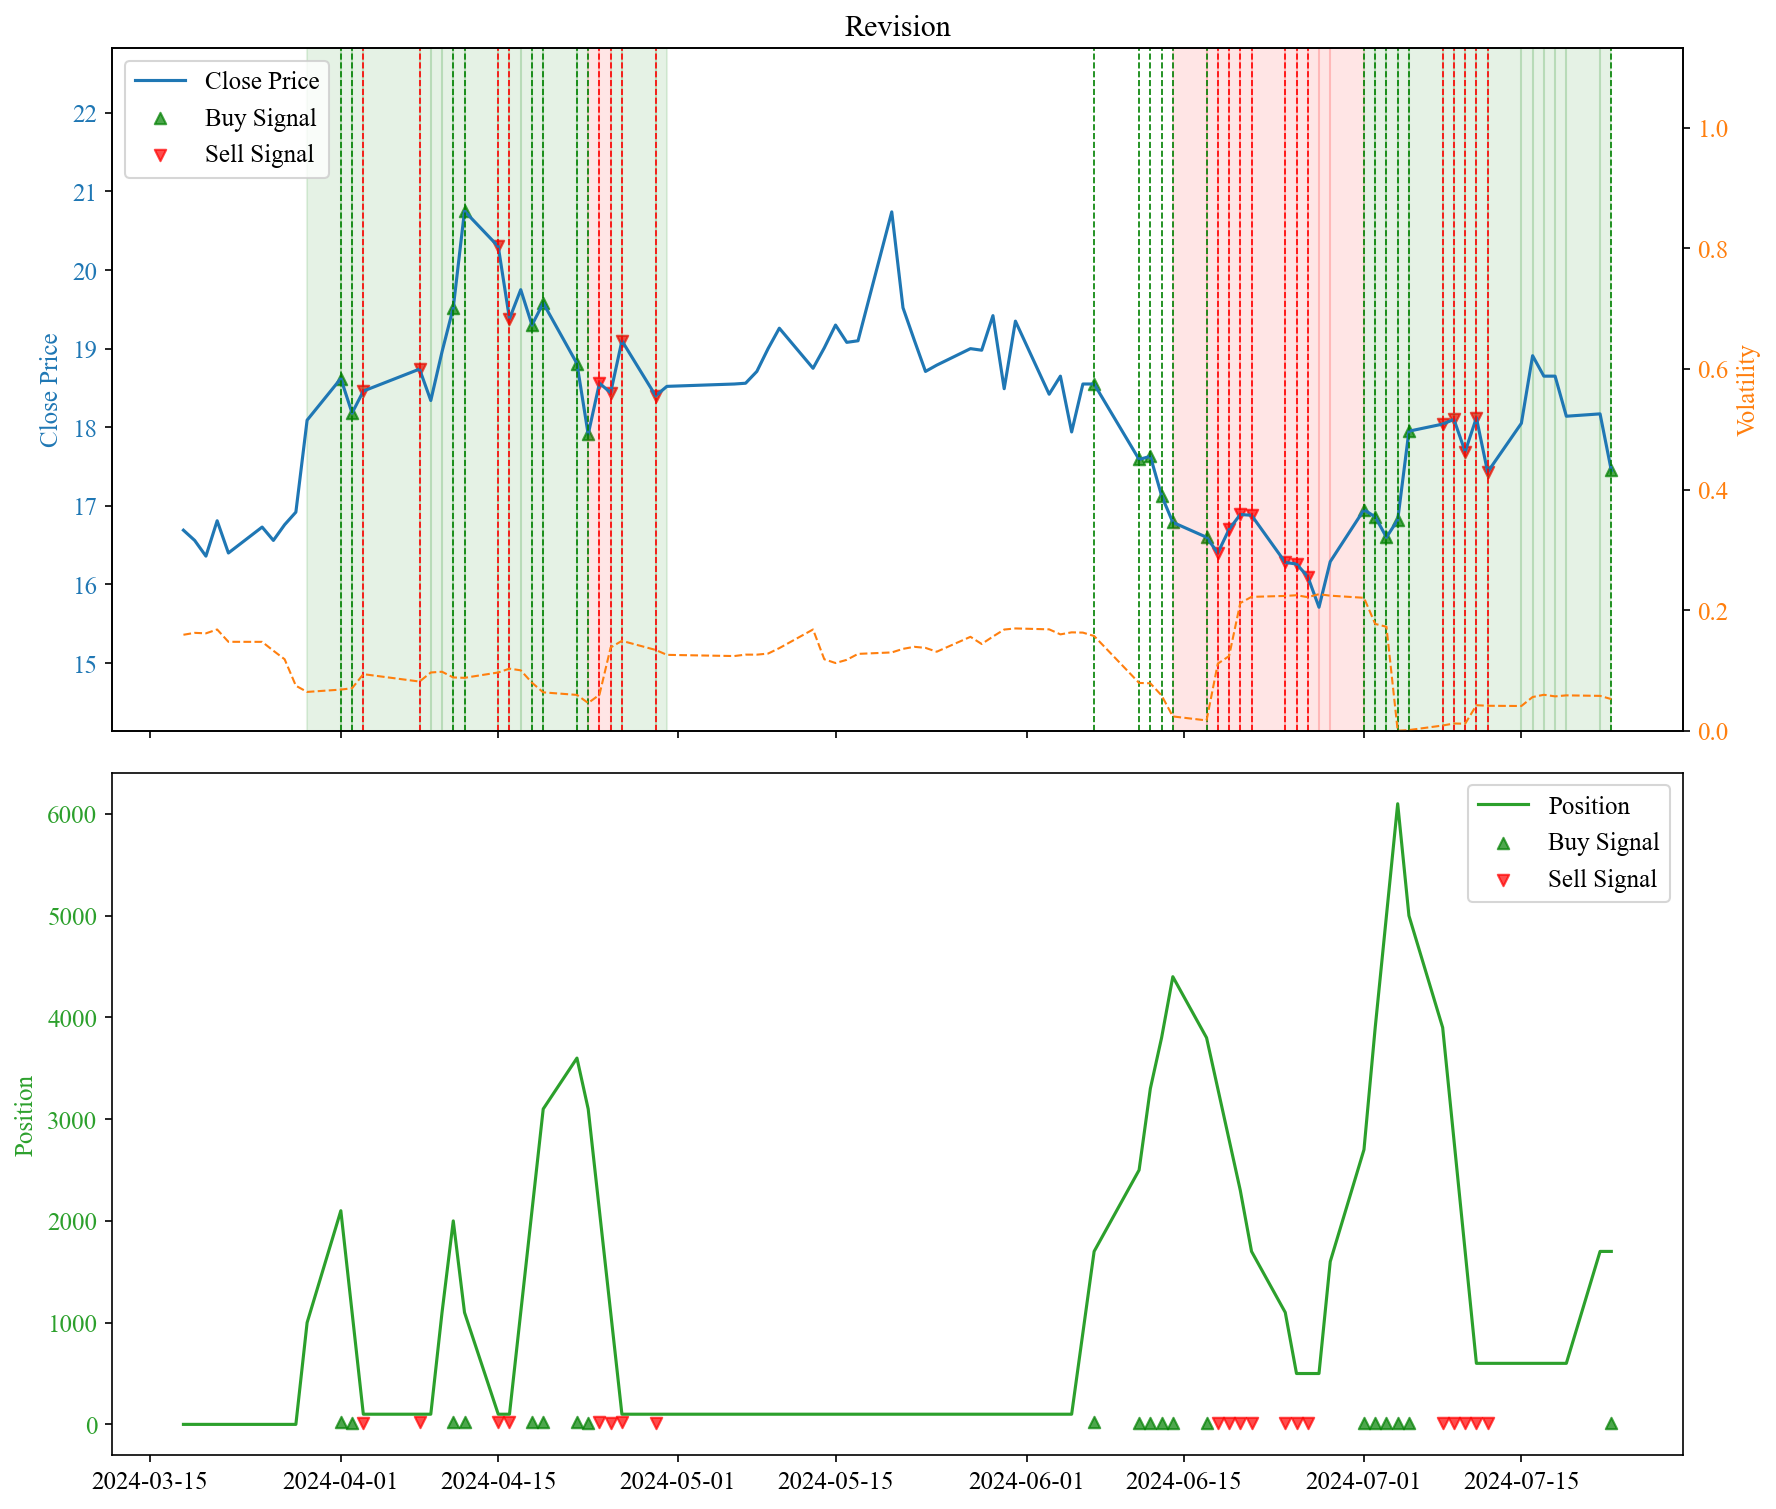

[*********************100%%**********************]  1 of 1 completed

Processing 002155.SZ (湖南黄金)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 33}
Best score:  -0.5536539952919165
Final Balance: [126562.99686432]  
 Annualized Return: [96.8] 
 Max Drawdown: [16.63]


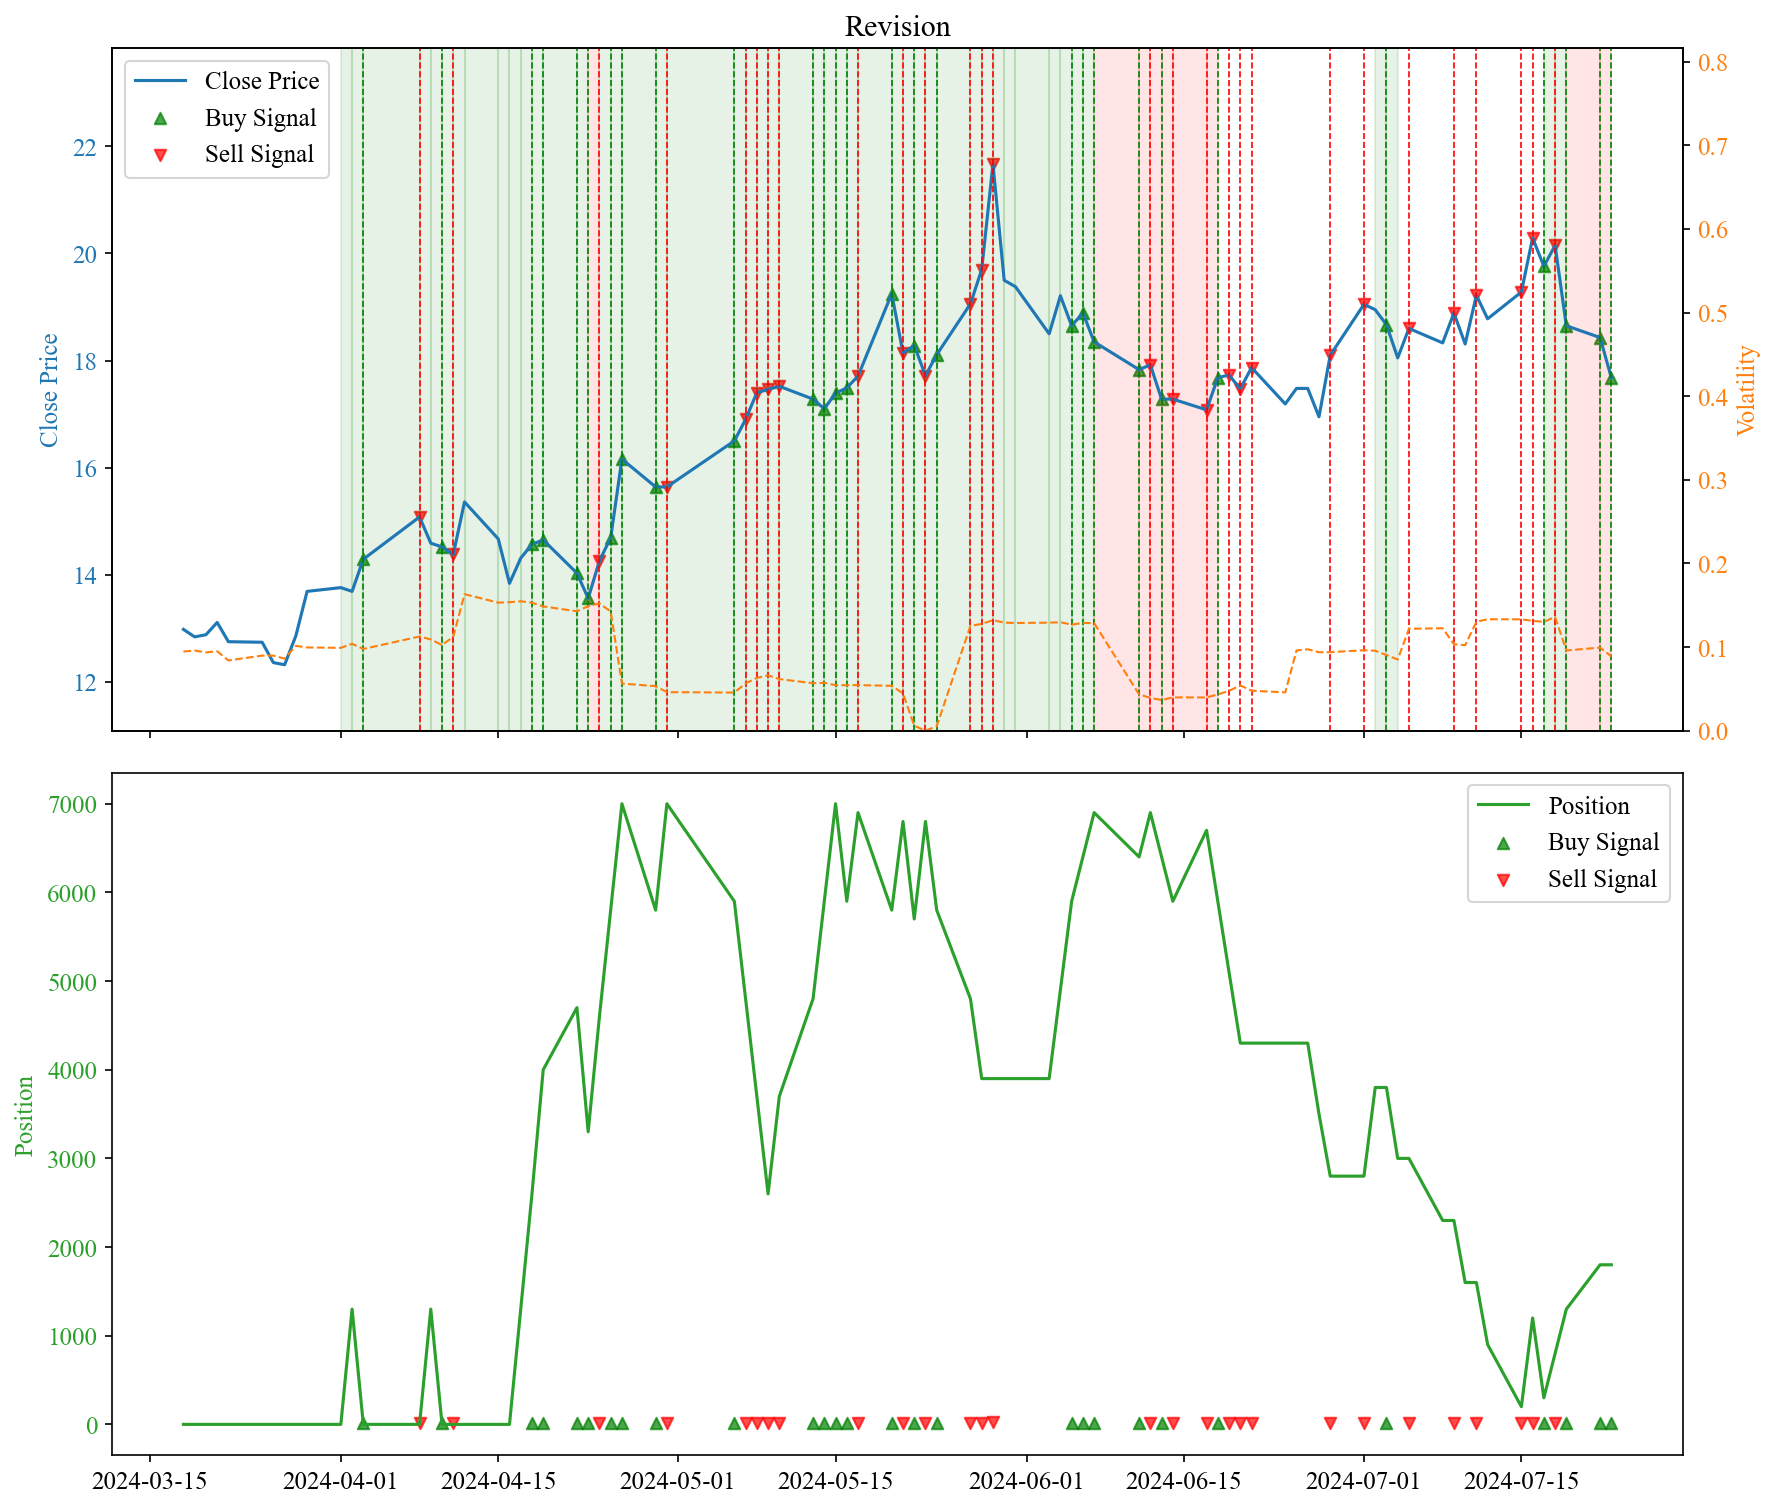

[*********************100%%**********************]  1 of 1 completed

Processing 600301.SS (华锡有色)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 42, 'turnover_window': 57}
Best score:  -0.8405558951735113
Final Balance: [117230.0037384]  
 Annualized Return: [57.91] 
 Max Drawdown: [11.42]


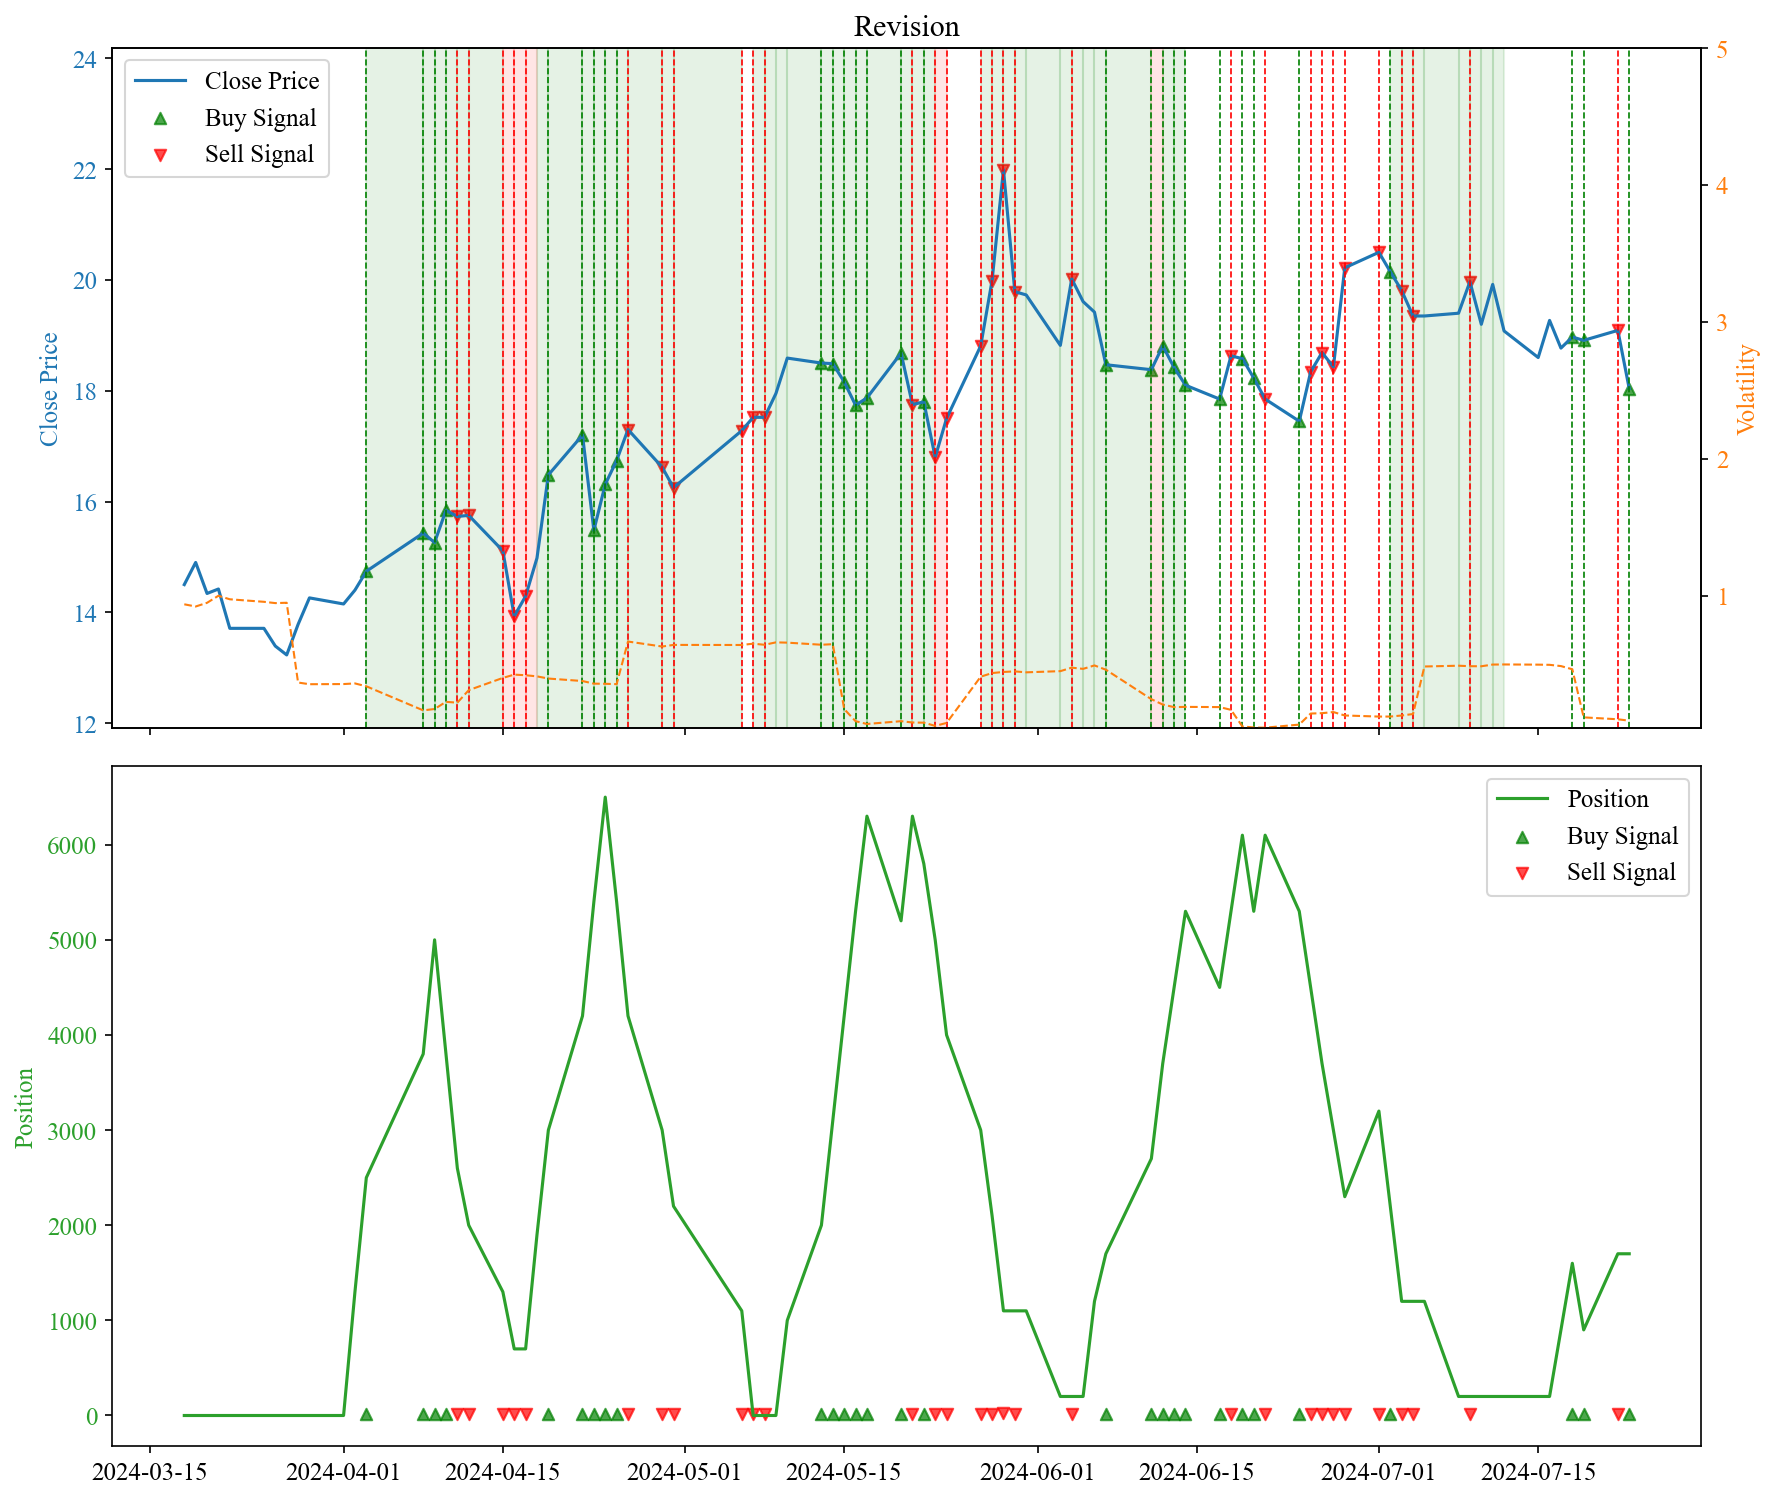

[*********************100%%**********************]  1 of 1 completed

Processing 601298.SS (青岛港)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 48, 'turnover_window': 57}
Best score:  -0.27521390066858575
Final Balance: [104845.9956646]  
 Annualized Return: [14.57] 
 Max Drawdown: [6.45]


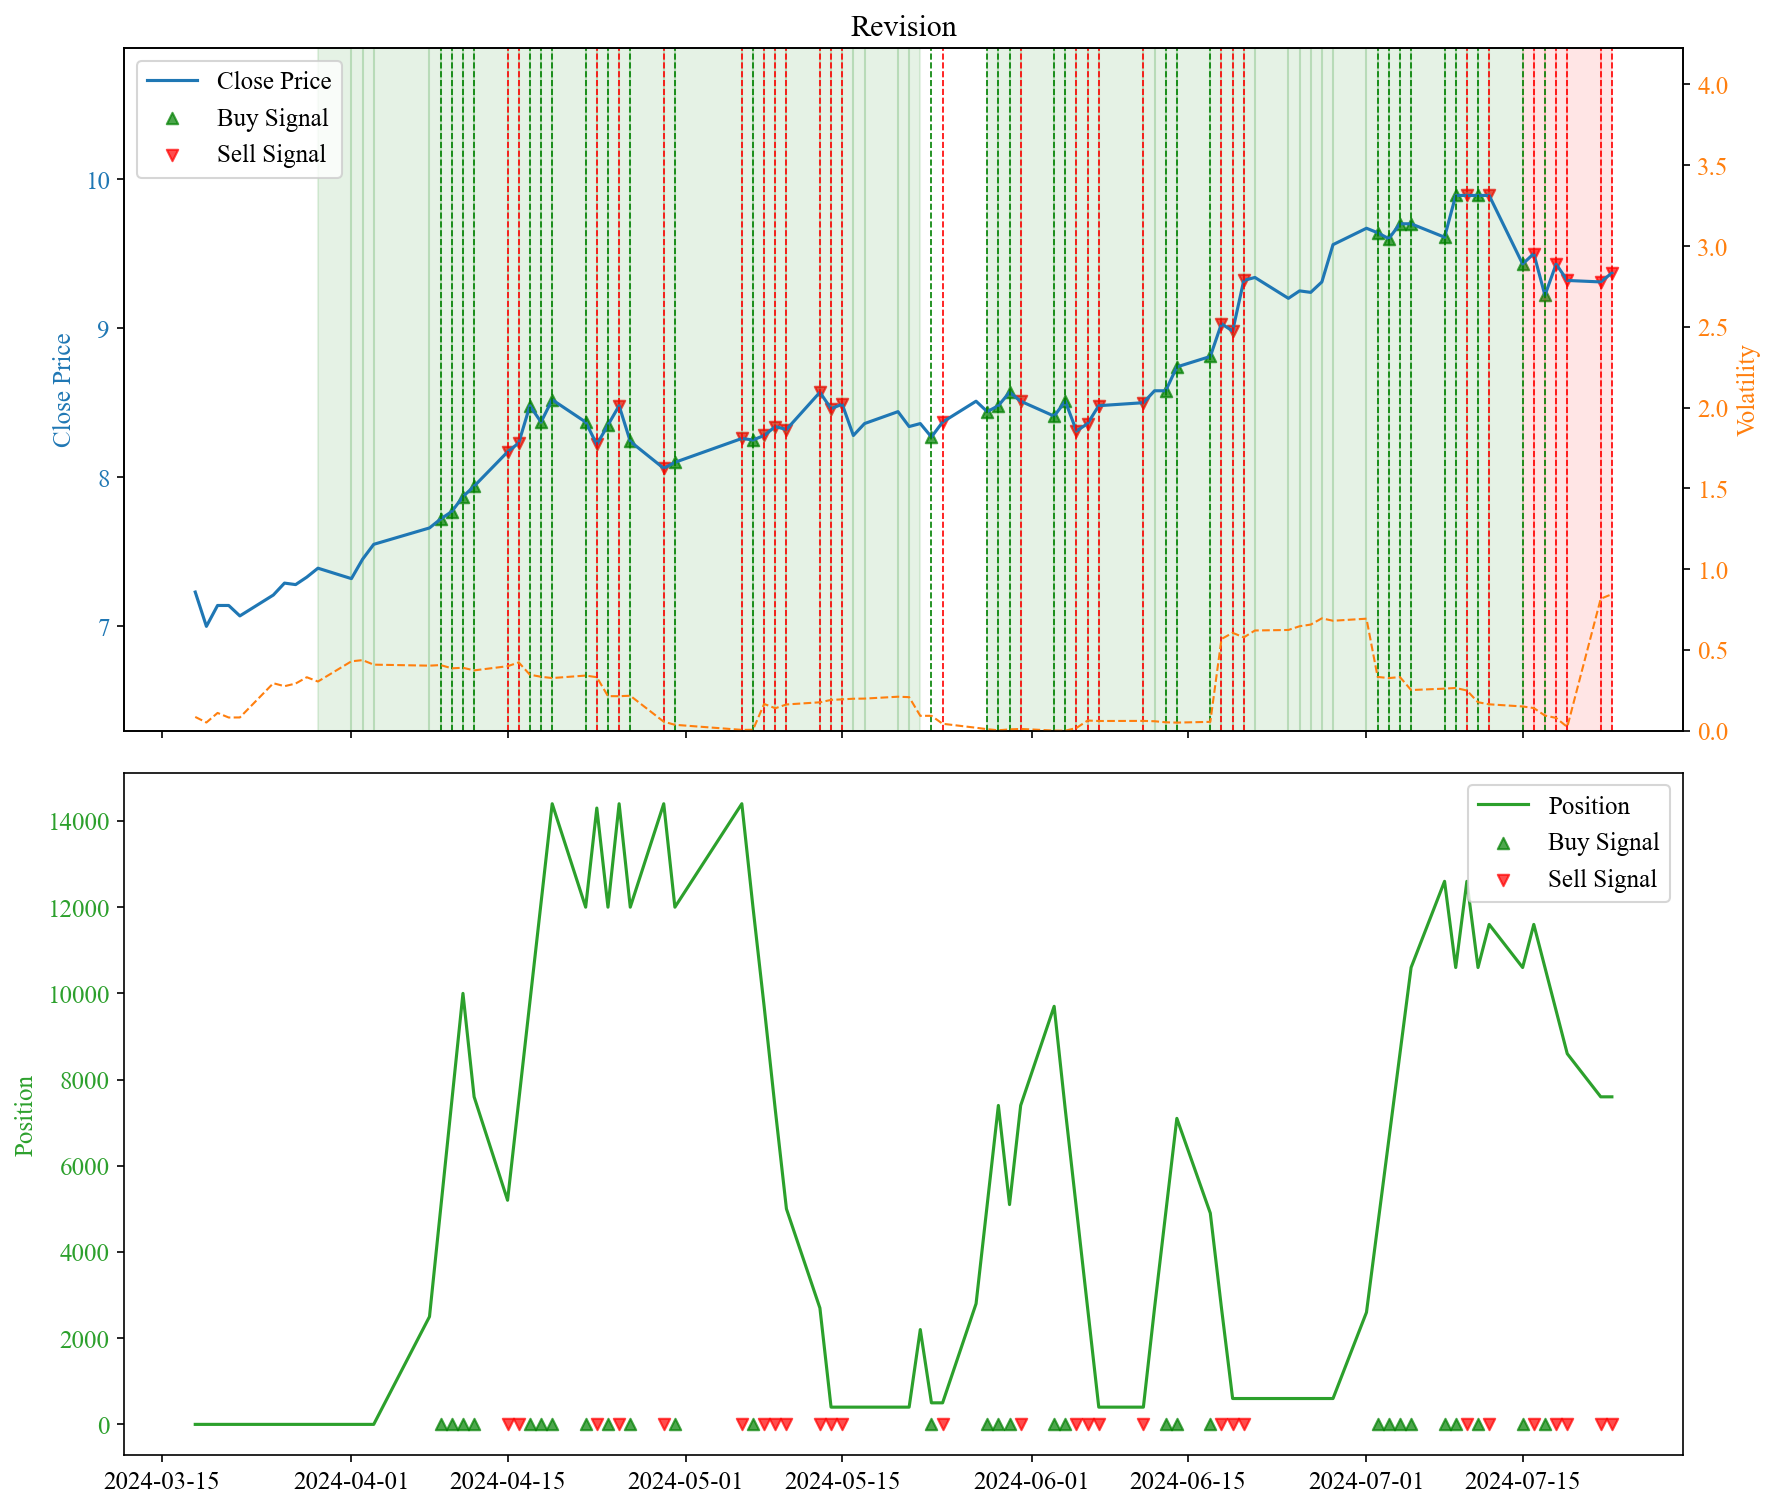

[*********************100%%**********************]  1 of 1 completed

Processing 600895.SS (张江高科)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 12, 'turnover_window': 6}
Best score:  -0.7953201744581162
Final Balance: [83626.00288391]  
 Annualized Return: [-32.35] 
 Max Drawdown: [21.69]


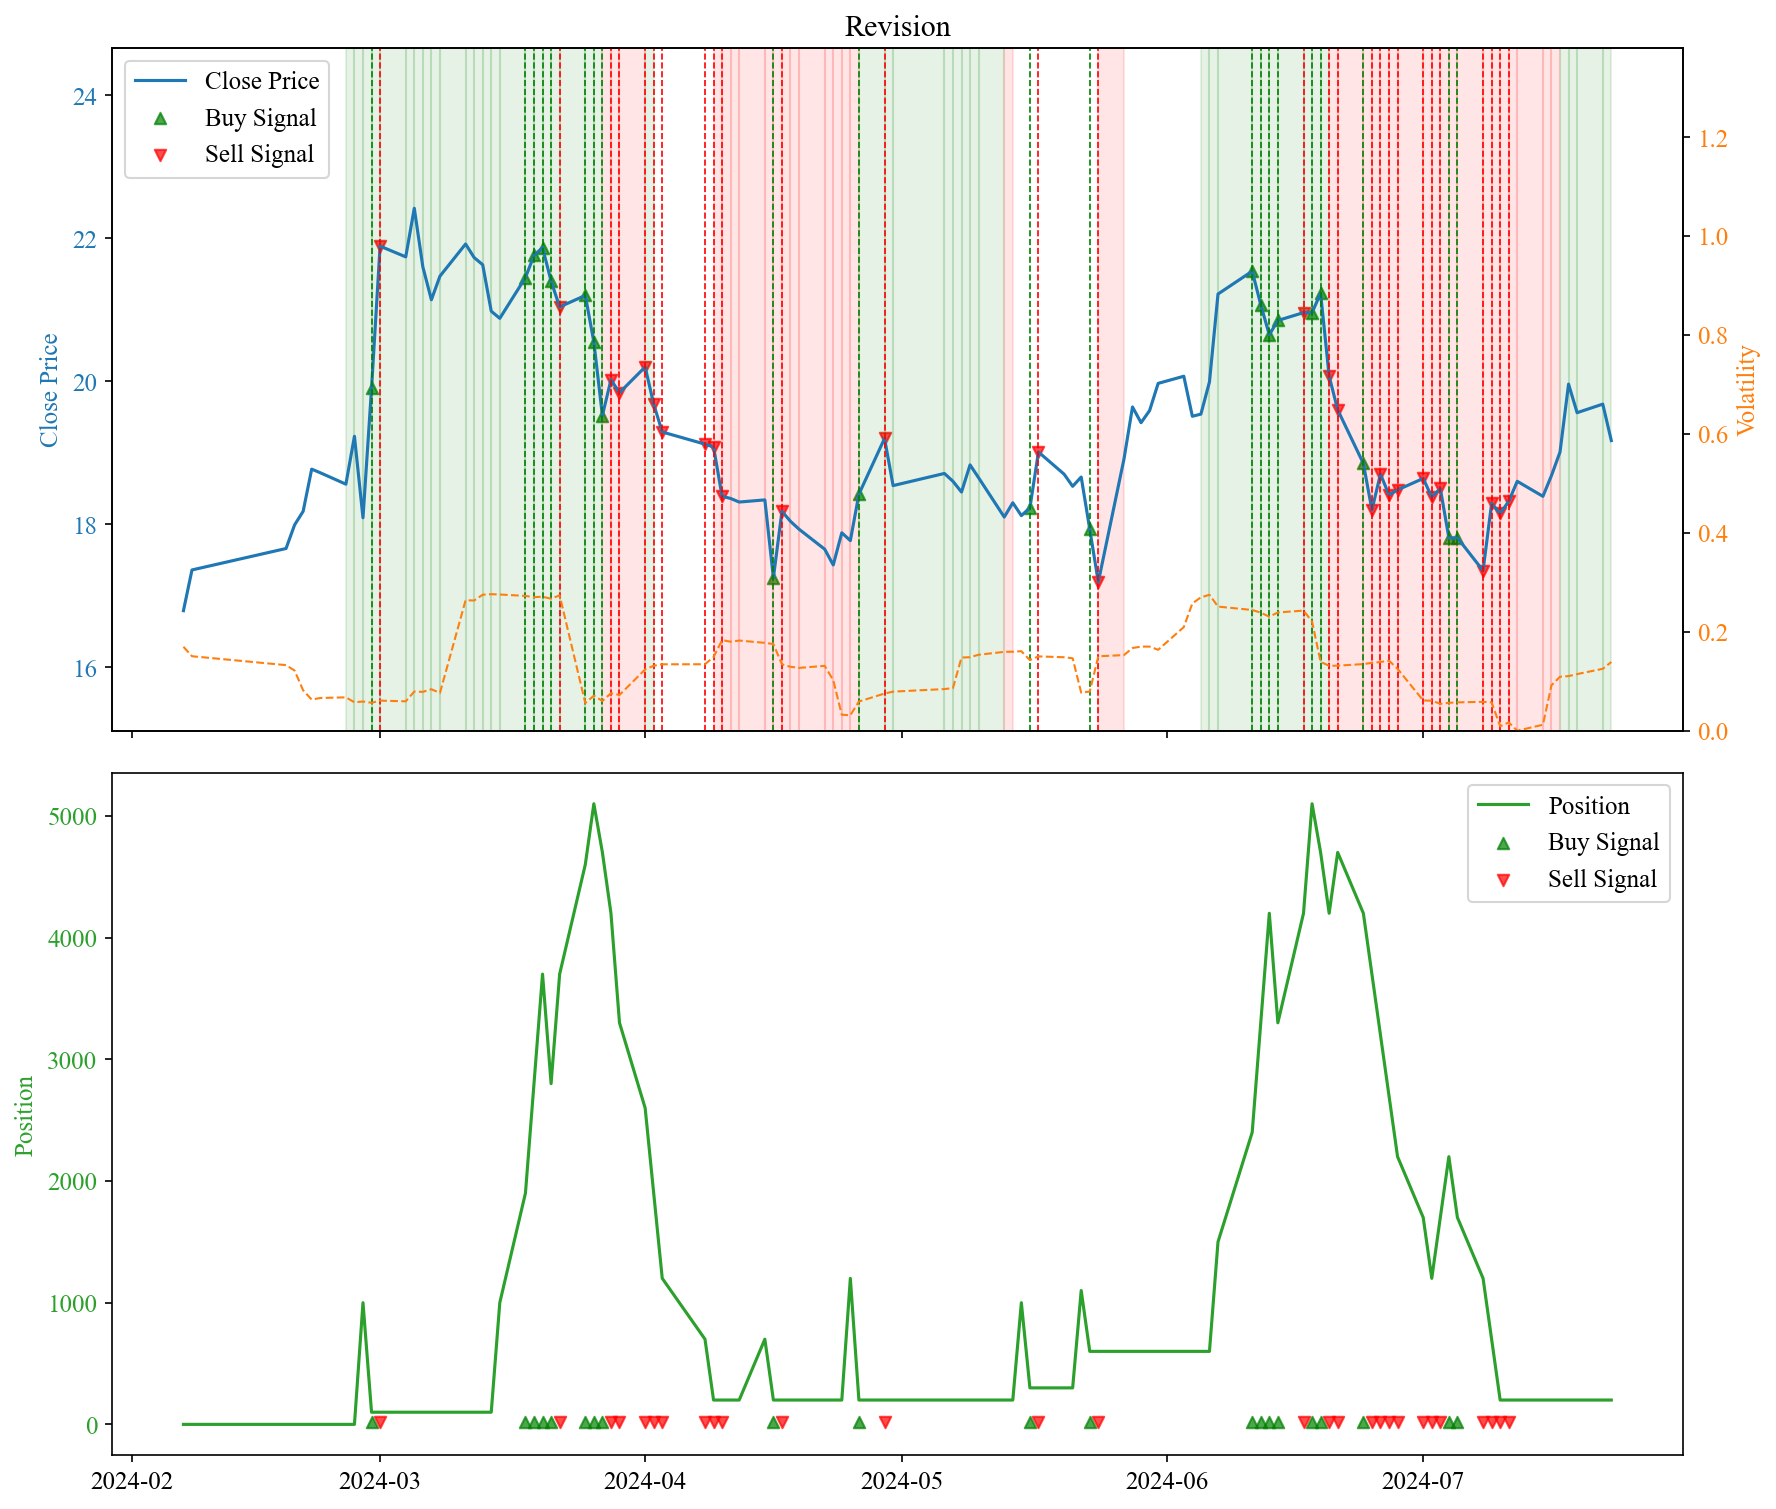

[*********************100%%**********************]  1 of 1 completed

Processing 601985.SS (中国核电)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 39, 'turnover_window': 57}
Best score:  -0.8889741385786611
Final Balance: [115389.99452591]  
 Annualized Return: [50.89] 
 Max Drawdown: [2.31]


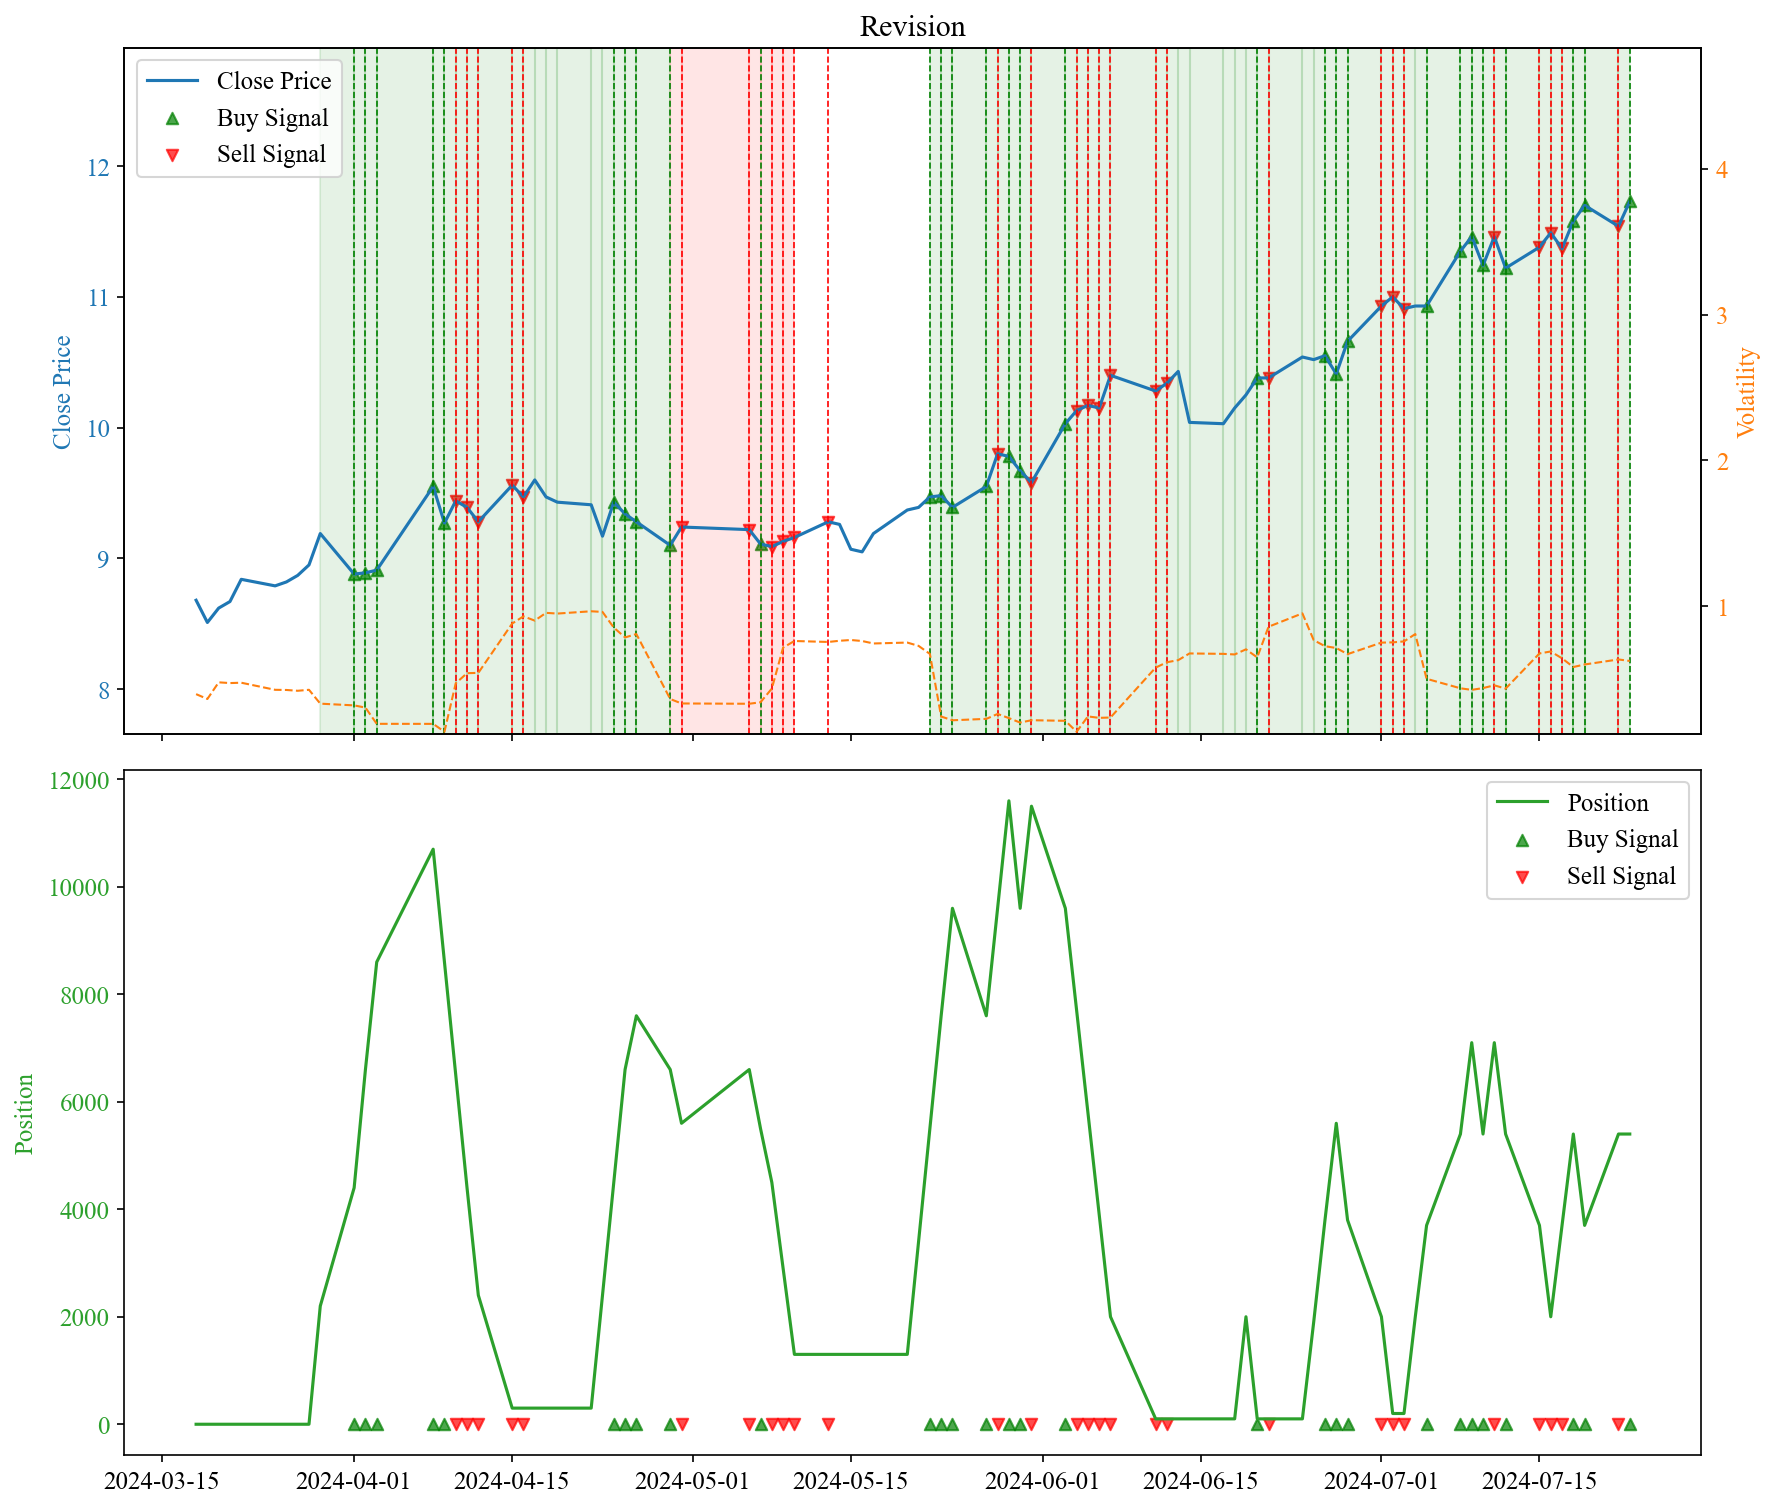

[*********************100%%**********************]  1 of 1 completed

Processing 600900.SS (长江电力)...



/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_51945/3732971809.py:4: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df_stock = df_stock.replace(0, method='ffill')


Best parameters found:  {'volatility_window': 57, 'turnover_window': 57}
Best score:  -0.6892292941125776
Final Balance: [108587.0016098]  
 Annualized Return: [26.71] 
 Max Drawdown: [3.43]


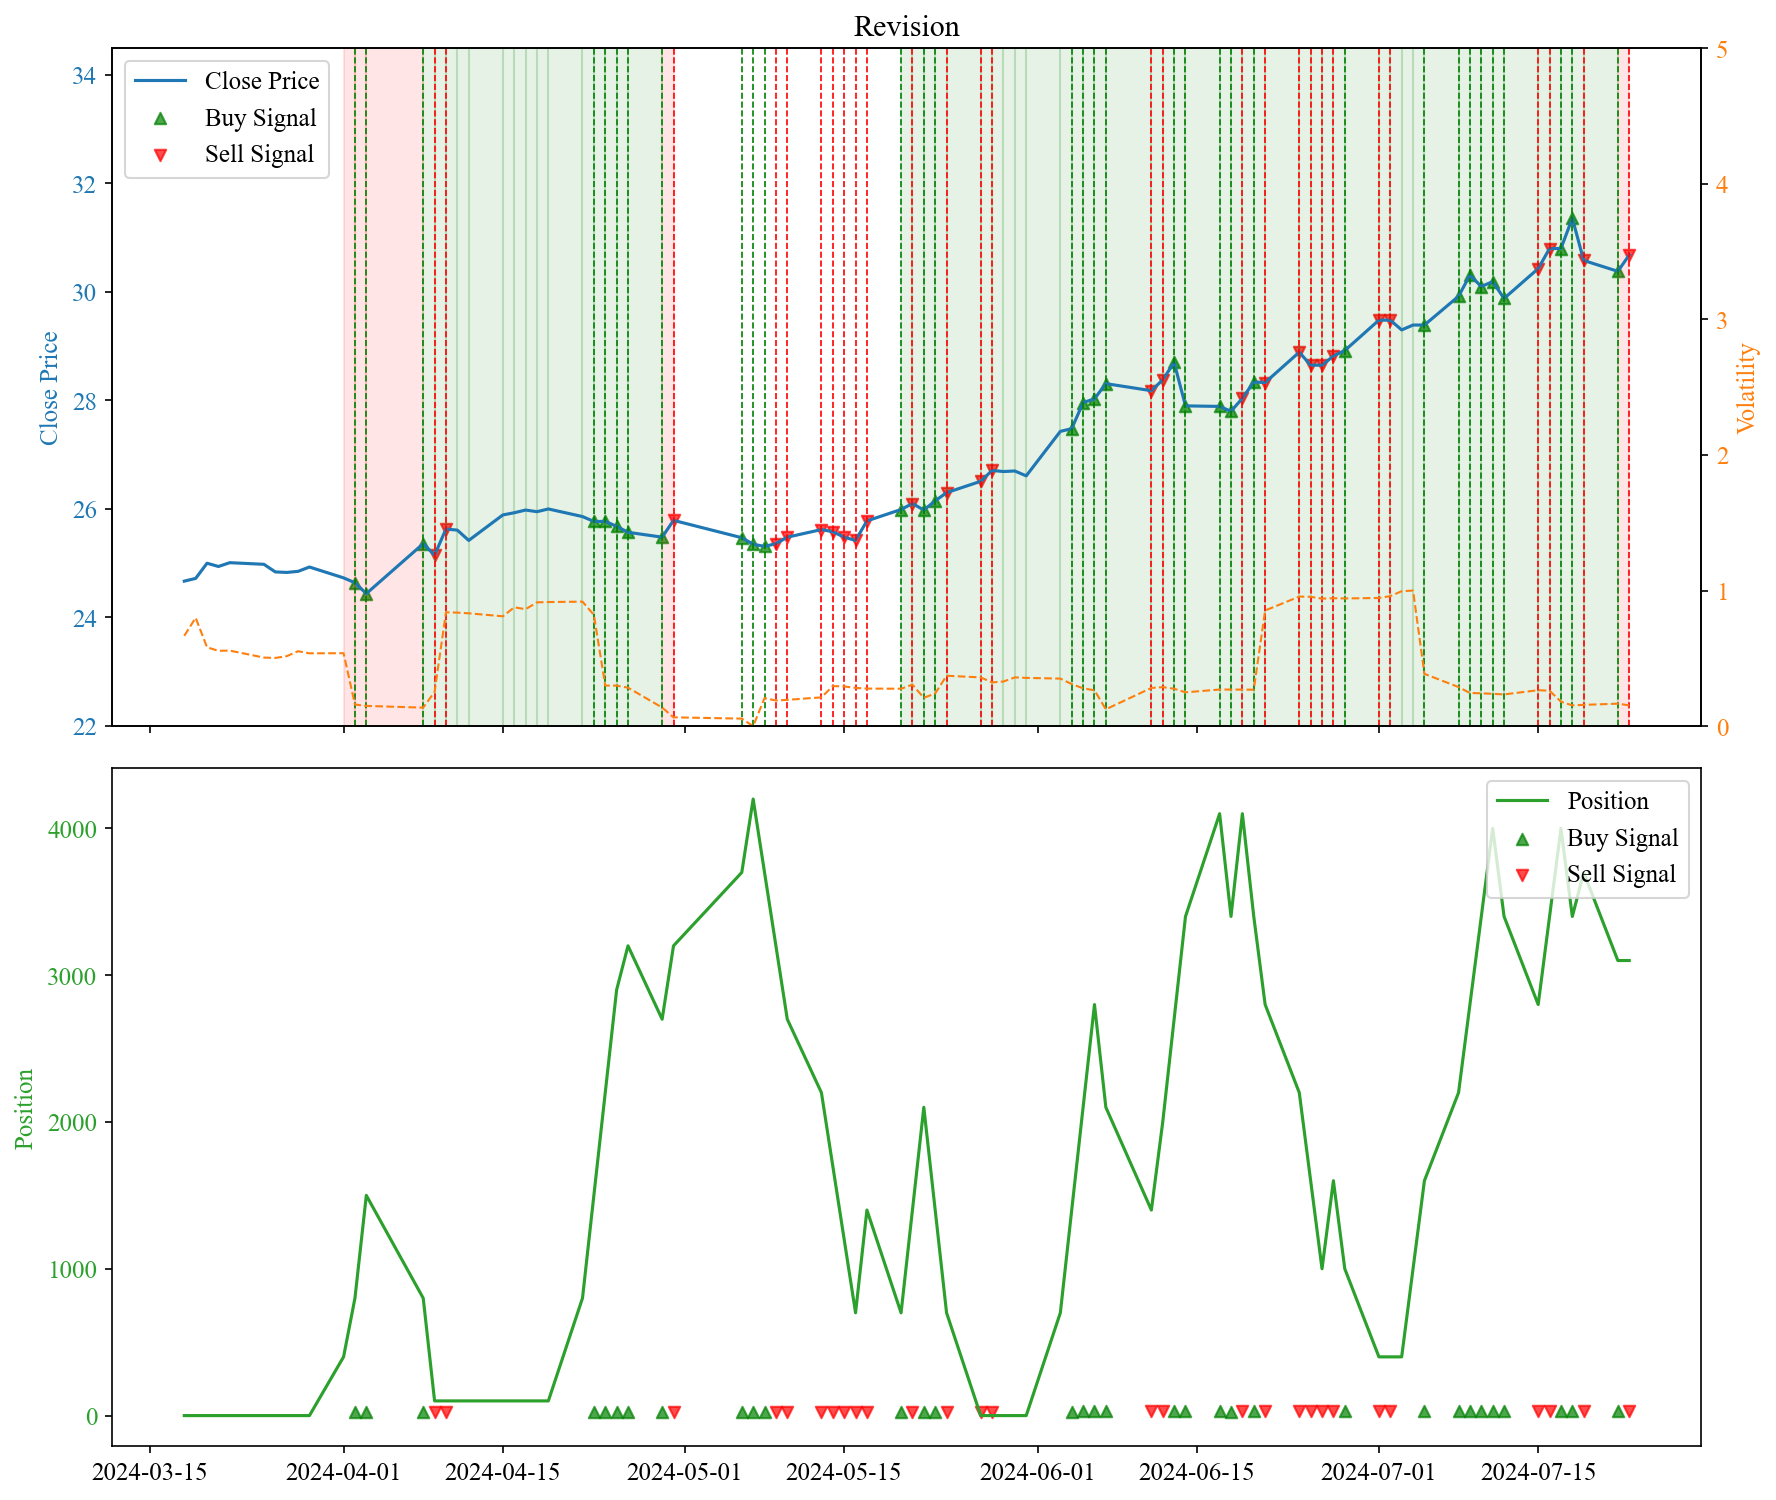

In [36]:
# 主函数，读取股票代码并运行策略和评估
all_results = []
annual_results = []
    
for stock_symbol, stock_name, industry in zip(stock_symbols, stock_names, stock_industry):
    print(f"Processing {stock_symbol} ({stock_name})...")
        
    # 加载和预处理数据
    df_stock = yf.download(stock_symbol, period="1y")
    df = add_technical_indicators(df_stock, stock_symbol)
    # 参数网格
    volatility_windows = range(3, 60, 3)
    turnover_windows = range(3, 60, 3)

    # 初始化变量保存最佳参数和最优得分
    best_score = float('inf')
    best_params = {}

    # 遍历参数网格
    for vw in volatility_windows:
        for tw in turnover_windows:
            score = custom_loss_function(vw, tw, df)
            # print(score)
            if not np.isnan(score) and score < best_score:
                best_score = score
                best_params = {'volatility_window': vw, 'turnover_window': tw}

    # 输出最优参数
    print("Best parameters found: ", best_params)
    print("Best score: ", best_score)

    df = df[df['Returns'].notnull()].copy()
    df.loc[:,'Vol'] = df['Returns'].rolling(window=best_params['volatility_window']).std()
    df.loc[:,'Turnover'] = df['Turnover Rate'].rolling(window=best_params['turnover_window']).mean()
    df = df.dropna()
    # 计算牛熊指标
    df['BullBearIndex'] = df['Vol'] / df['Turnover']
    # 标准化上证指数
    scaler = MinMaxScaler()
    df['BullBearIndex_scaled'] = scaler.fit_transform(df[['BullBearIndex']])
    
    features = ['Returns', 'Historical Volatility', 'Volume Volatility']
    data, scaler = preprocess_data(df[features])
        
    time_step = 1
    X, Y = create_dataset(data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], len(features))

    split = int(len(X) * 0.5)
    Y_test = Y[split:]
    length = len(Y_test)
    # split = 0
    # Y_test = Y
    
    test_dates  = df.index[-length:]
    test_prices = df['Close'].values[-length:]
    high_prices = df['High'].values[-length:]
    low_prices  = df['Low'].values[-length:]
    turnover_rate = df['Turnover Rate'].values[-length:]
        
    Y_test_scaled = Y_test.flatten().reshape(-1, 1)
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(Y_test_scaled)
    Y_test_unscaled = scaler_Y.inverse_transform(Y_test_scaled)
        
    test_volatility = Y_test_unscaled
    hist_volatility = df['Historical Volatility'].values[-len(Y_test):]
        
    # 回测时采用每日真实数据
    pnl_v1, buy_dates_v1, sell_dates_v1, position_list_v1 = momentum_v1_strategy(test_volatility, df, length, principle)
    # plot_trading_strategy(test_volatility, df, length, buy_dates_v1, sell_dates_v1, 'Standard')
    # 评估 Momentum 策略
    v1_results_df = evaluate_strategy(df, length, pnl_v1, buy_dates_v1, sell_dates_v1, principle)
    v1_results_df['Stock Symbol'] = stock_symbol
    v1_results_df['Stock Name'] = stock_name
    v1_results_df['Industry'] = industry
    v1_results_df['Strategy'] = 'Standard'
    # print(f"Final Balance: {v1_results_df['Final Balance'].values}  \n Annualized Return: {v1_results_df['Annualized Return'].values} \n Max Drawdown: {v1_results_df['Max Drawdown'].values}")
    # plot_trading_strategy(test_volatility, df, length, buy_dates_v1, sell_dates_v1, position_list_v1, title='Revision')

    all_results.append(v1_results_df)
        
    #  # 计算年化绩效
    # v1_annual_results = annual_performance(pnl_v1, test_dates, buy_dates_v1, sell_dates_v1, principle)

    # # 添加股票符号和股票名称到结果中
    # v1_annual_results['Stock Symbol'] = stock_symbol
    # v1_annual_results['Stock Name'] = stock_name

    # annual_results.append(v1_annual_results)
        
    # 回测时采用每日真实数据
    # pnl_v2, buy_dates_v2, sell_dates_v2 = momentum_v2_strategy(test_dates, test_prices, test_volatility, df, length, principle)
    
    # 调用优化函数
    # best_params, best_performance = optimize_strategy(test_volatility, df, length, principle)
    # print("Best Parameters:", best_params)
    # print("Best Performance:", best_performance)
    
    pnl_v2, buy_dates_v2, sell_dates_v2, position_list_v2 = momentum_v2_strategy(test_volatility, df, length, principle, short_window=5, trend_window=10)
    
    # 评估 Momentum 策略
    v2_results_df = evaluate_strategy(df, length, pnl_v2, buy_dates_v2, sell_dates_v2, principle)
    v2_results_df['Stock Symbol'] = stock_symbol
    v2_results_df['Stock Name'] = stock_name
    v2_results_df['Industry'] = industry
    v2_results_df['Strategy'] = 'Revision'
    print(f"Final Balance: {v2_results_df['Final Balance'].values}  \n Annualized Return: {v2_results_df['Annualized Return'].values} \n Max Drawdown: {v2_results_df['Max Drawdown'].values}")
    plot_trading_strategy(test_volatility, df, length, buy_dates_v2, sell_dates_v2, position_list_v2, title='Revision')

    all_results.append(v2_results_df)
        
    # 运行 Buy-and-Hold 策略并获取 PnL 和买卖日期
    pnl_bh, buy_dates_bh, sell_dates_bh = buy_and_hold_strategy(df, length, principle)
        
    # 评估 Buy-and-Hold 策略
    bh_results_df = evaluate_strategy(df, length, pnl_bh, buy_dates_bh, sell_dates_bh, principle)
    bh_results_df['Stock Symbol'] = stock_symbol
    bh_results_df['Stock Name'] = stock_name
    bh_results_df['Industry'] = industry
    bh_results_df['Strategy'] = 'BH'
        
    all_results.append(bh_results_df)


# 合并所有结果
final_results_df = pd.concat(all_results, ignore_index=True)

In [37]:
# annual_results

In [38]:
output = results(final_results_df)

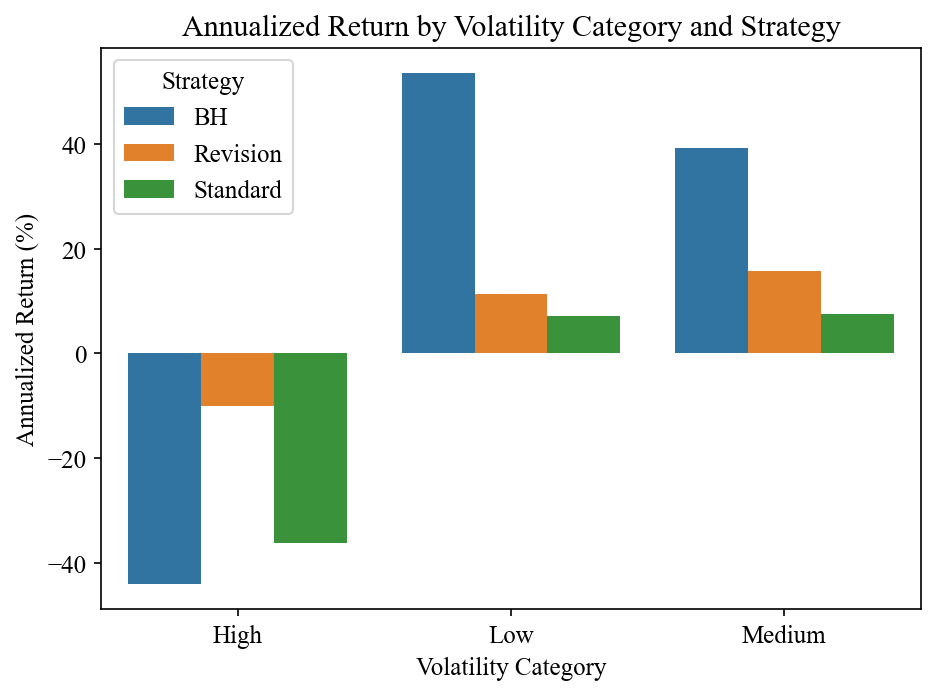

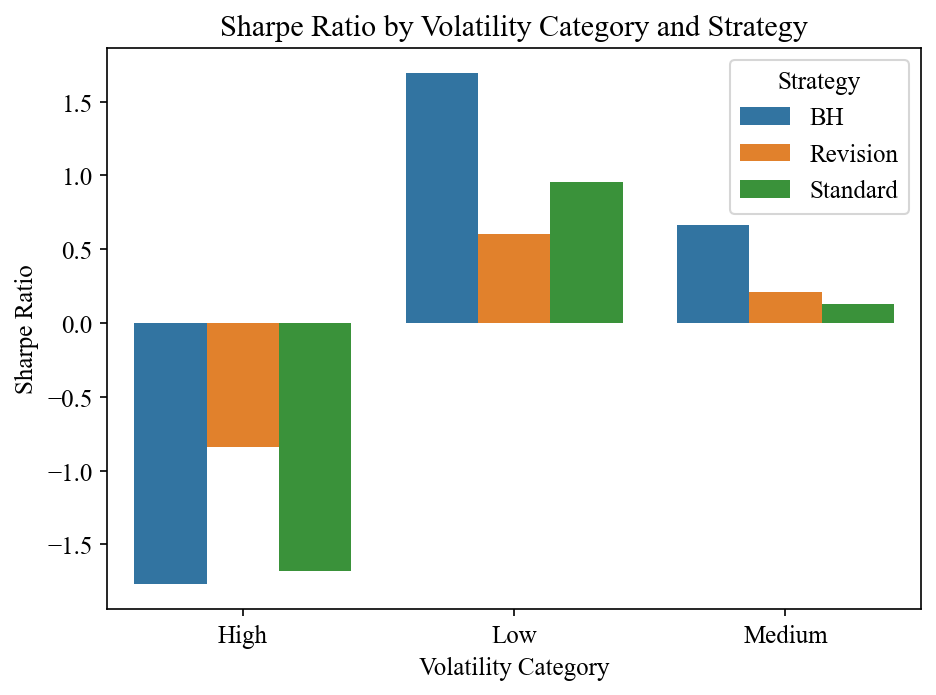

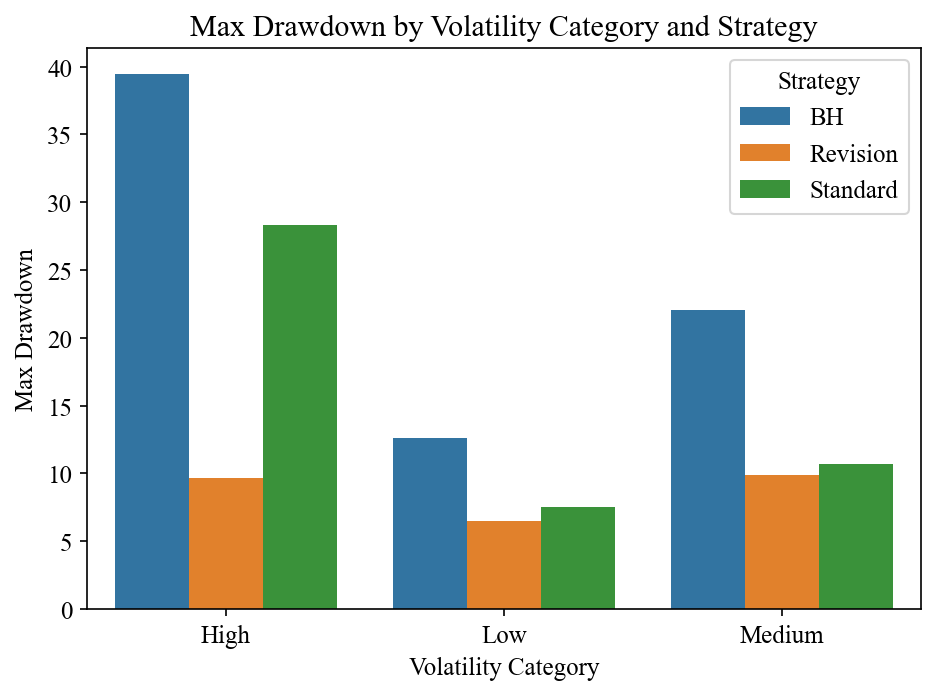

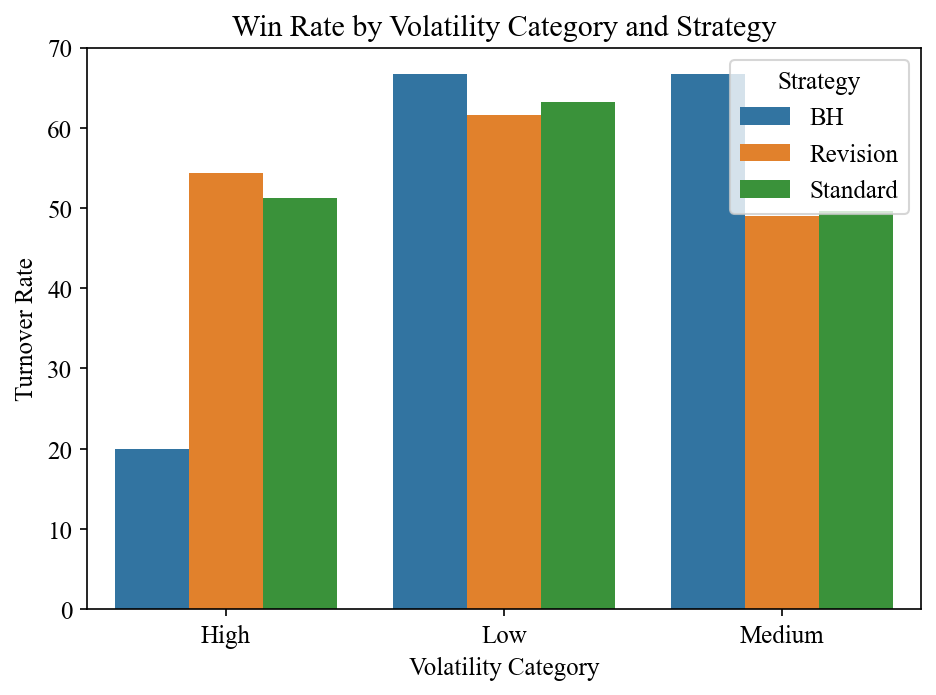

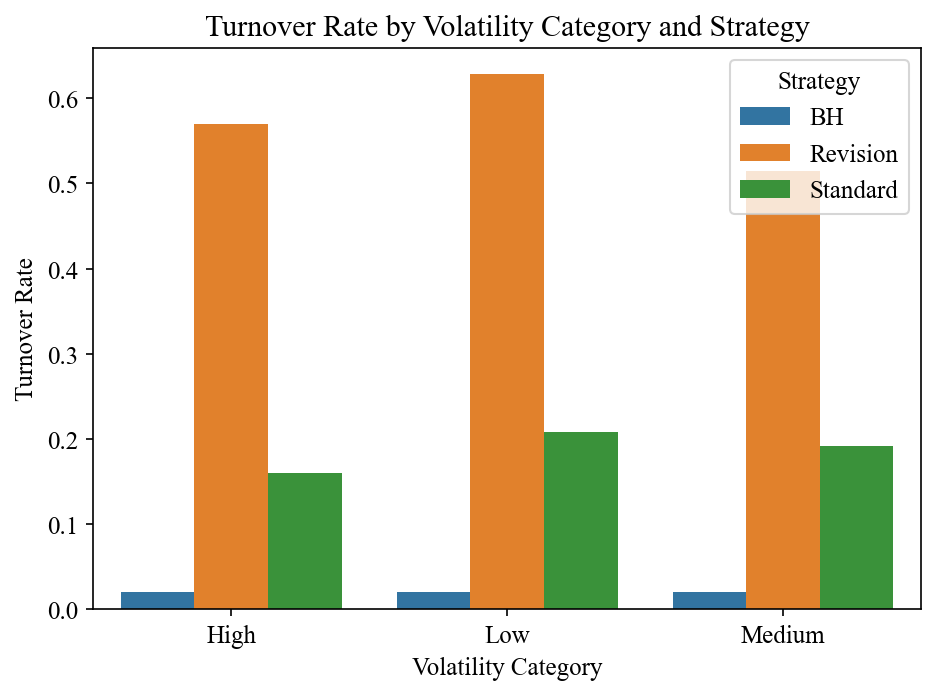

In [39]:
volatility_category_dict = {symbol: categorize_volatility(vol) for symbol, vol in volatility_dict.items()}

# 将波动率类别和股票名称添加到 final_results_df 中
output['Volatility Category'] = output.index.map(volatility_category_dict)
output['Stock Name'] = output.index.map(stock_names_dic)

# 调整列顺序
output = output.reset_index()
output = output[['Stock Symbol', 'Stock Name', 'Volatility Category', 'Industry', 'Strategy', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown','Win Rate', 'Turnover Rate', 'Long Count', 'Short Count']]

# 计算每种波动率类型中每个策略的平均表现
grouped_by_volatility = output.groupby(['Volatility Category', 'Strategy']).agg(
    {'Annualized Return': 'mean', 'Sharpe Ratio': 'mean', 'Max Drawdown': 'mean', 'Win Rate': 'mean','Turnover Rate': 'mean'})


# 调用可视化函数
visualize_strategy_performance_by_volatility(grouped_by_volatility)

display_results(output)

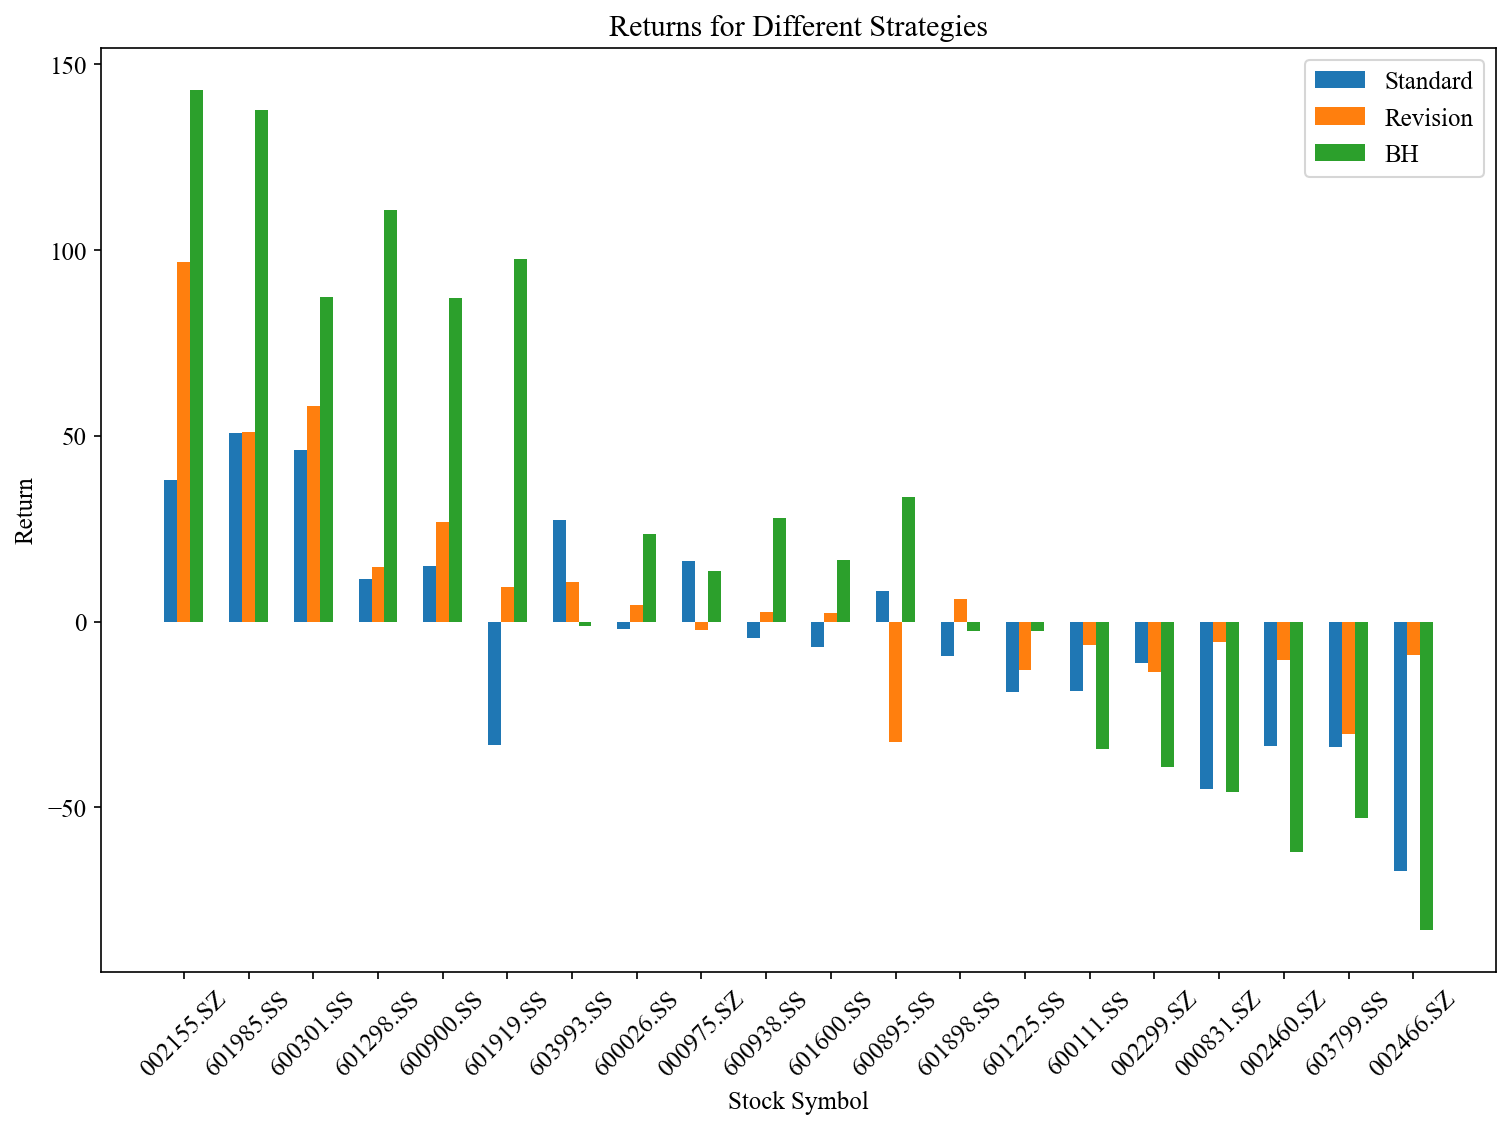

In [40]:
def plot_combined_returns(df):
    """
    对所有股票的不同策略的回报率进行可视化。
    
    参数:
    df: pandas DataFrame，包含列 'Stock Symbol', 'Strategy', 'Return'
    """
    # 获取所有的股票代码和策略
    stock_symbols = df['Stock Symbol'].unique()
    strategies = df['Strategy'].unique()
    
    # 设置柱状图的宽度
    bar_width = 0.2
    index = np.arange(len(stock_symbols))
    
    # 创建图表
    plt.figure(figsize=(12, 8))
    
    # 对每种策略进行绘图
    for i, strategy in enumerate(strategies):
        strategy_data = df[df['Strategy'] == strategy]
        returns = []
        for symbol in stock_symbols:
            return_value = strategy_data[strategy_data['Stock Symbol'] == symbol]['Annualized Return']
            if not return_value.empty:
                returns.append(return_value.values[0])
            else:
                returns.append(0)
        
        plt.bar(index + i * bar_width, returns, bar_width, label=strategy)
    
    # 设置图表的属性
    plt.xlabel('Stock Symbol')
    plt.ylabel('Return')
    plt.title('Returns for Different Strategies')
    plt.xticks(index + bar_width * (len(strategies) - 1) / 2, stock_symbols, rotation=45)
    plt.legend()
    plt.show()

# 调用绘图函数
plot_combined_returns(output)